# Profile

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
datadir = '../kingston'
datadir = './'
libdir = '.'
outputdir = '.'
otherdir = '.'

train_bs_ = 16 # train_batch_size
valid_bs_ = 128 # valid_batch_size
num_workers_ = 0

In [3]:
os.chdir("G:/rsna-2023-abdominal-trauma-detection/")

# CFG

In [4]:
class CFG:
    seed=42
    device='GPU' # ['TPU', 'GPU']
    nprocs=1 # [1, 8]
    num_workers=num_workers_
    train_bs=train_bs_
    valid_bs=valid_bs_
    fold_num=5 
    
    target_cols=["C1", "C2", "C3", "C4", "C5"]#, "C6", "C7", "OT"]
    num_classes=5
    
    normalize_mean=[0.4824, 0.4824, 0.4824] 
    normalize_std=[0.22, 0.22, 0.22] 
    
    fold_list=[0]

    model_arch="efficientnet-b0" 
    img_size=512 
    croped_img_size = 320 # 裁剪后的图片尺寸
    weight_path = f"G:/rsna-2023-abdominal-trauma-detection/models/segmentation/efficientnet-b0_109_fold0_epoch3.pth" 

# Import

In [5]:
# !pip install -q git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git
    
import sys; 

package_paths = [f'{libdir}pytorch-image-models-master']
for pth in package_paths:
    sys.path.append(pth)
    
import ast
from glob import glob
import cv2
from skimage import io
import os
from datetime import datetime
import time
import random
from tqdm import tqdm
from contextlib import contextmanager
import math

import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.model_selection import GroupKFold, StratifiedKFold, KFold
import torch
import torchvision
from torchvision import transforms
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.optim import Adam, SGD, AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler
import timm
import warnings
import joblib
from scipy.ndimage.interpolation import zoom
import nibabel as nib
import pydicom as dicom
import gc 


if CFG.device == 'TPU':
    !pip install -q pytorch-ignite
    import ignite.distributed as idist
elif CFG.device == 'GPU':
    from torch.cuda.amp import autocast, GradScaler

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

C:\Users\Menghao\AppData\Local\Temp\ipykernel_19288\1262559851.py:43: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom


In [6]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True 

seed_everything(CFG.seed)


def get_score(y_true, y_pred):
    scores = []
    for i in range(y_true.shape[1]):
        score = roc_auc_score(y_true[:,i], y_pred[:,i])
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores



# 日志记录函数
def init_logger(log_file=outputdir+'/train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


def get_timediff(time1,time2):
    minute_,second_ = divmod(time2-time1,60)
    return f"{int(minute_):02d}:{int(second_):02d}"  


class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb


def load_dicom(path):
    """
    This supports loading both regular and compressed JPEG images. 
    See the first sell with `pip install` commands for the necessary dependencies
    """
    img = dicom.dcmread(path)
    img.PhotometricInterpretation = 'YBR_FULL'
    data = img.pixel_array
    data = data - np.min(data)
    if np.max(data) != 0:
        data = data / np.max(data)
    # data = (data * 255).astype(np.uint8)
    return data

In [7]:
p_s = glob("./train_images/*/*")
s_id_p_id = {x.split("\\")[-1]:x.split("\\")[-2] for x in p_s}
# p_id = s_id_p_id[str(s_id)]

In [8]:
seg_paths = glob(f"{datadir}/segmentations/*")
seg_gt_list = [path.split('\\')[-1][:-4] for path in seg_paths]
print(len(seg_gt_list))
seg_gt_list[:3]

206


['10000', '10109', '10180']

# 87Sampler Peek Mask

In [9]:
study_train_df = pd.read_csv(f'{datadir}/seg_25d.csv')
print('train_df shape:', study_train_df.shape)
study_train_df.head(3)

train_df shape: (70129, 6)


id  StudyInstanceUID  slice_num                    image_path  \
0  10000_1             10000          1  .//seg_25d_image/10000_1.npy   
1  10000_2             10000          2  .//seg_25d_image/10000_2.npy   
2  10000_3             10000          3  .//seg_25d_image/10000_3.npy   

                     mask_path  fold  
0  .//seg_25d_mask/10000_1.npy     3  
1  .//seg_25d_mask/10000_2.npy     3  
2  .//seg_25d_mask/10000_3.npy     3

In [10]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name=CFG.model_arch,    # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path)["model"])
    model.eval()
    return model

model = load_model(CFG.weight_path)
model.eval()
gc.collect()

25

In [11]:
len(np.unique(study_train_df.StudyInstanceUID))

206

In [12]:
study_train_df.groupby("StudyInstanceUID").agg("count")
study_train_df

id  StudyInstanceUID  slice_num                     image_path  \
0       10000_1             10000          1   .//seg_25d_image/10000_1.npy   
1       10000_2             10000          2   .//seg_25d_image/10000_2.npy   
2       10000_3             10000          3   .//seg_25d_image/10000_3.npy   
3       10000_4             10000          4   .//seg_25d_image/10000_4.npy   
4       10000_5             10000          5   .//seg_25d_image/10000_5.npy   
...         ...               ...        ...                            ...   
70124  8413_318              8413        318  .//seg_25d_image/8413_318.npy   
70125  8413_319              8413        319  .//seg_25d_image/8413_319.npy   
70126  8413_320              8413        320  .//seg_25d_image/8413_320.npy   
70127  8413_321              8413        321  .//seg_25d_image/8413_321.npy   
70128  8413_322              8413        322  .//seg_25d_image/8413_322.npy   

                          mask_path  fold  
0       .//seg_25d_mask/10000_1.npy     3  
1       .//seg_25d_mask/10000_2.npy     3  
2       .//seg_25d_mask/10000_3.npy     3  
3       .//seg_25d_mask/10000_4.npy     3  
4       .//seg_25d_mask/10000_5.npy     3  
...                             ...   ...  
70124  .//seg_25d_mask/8413_318.npy     1  
70125  .//seg_25d_mask/8413_319.npy     1  
70126  .//seg_25d_mask/8413_320.npy     1  
70127  .//seg_25d_mask/8413_321.npy     1  
70128  .//seg_25d_mask/8413_322.npy     1  

[70129 rows x 6 columns]

rand_idx:14592
rand_idx:3278
rand_idx:36048
rand_idx:32098
rand_idx:29256
rand_idx:18289


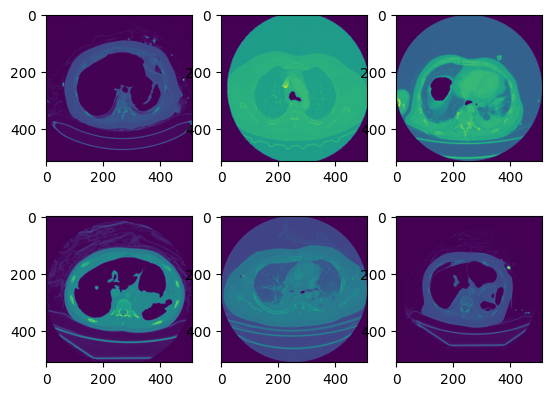

In [13]:
import random
rand_idices = random.sample(range(0, len(study_train_df)),6)
for i,rand_idx in enumerate(rand_idices):
    print(f"rand_idx:{rand_idx}")
    example = study_train_df.iloc[rand_idx]
    #example = study_train_df[study_train_df.StudyInstanceUID==22397].iloc[200]
    exa_image = np.load(example["image_path"])
    exa_mask = np.load(example["mask_path"])
    # print(f"exa_image.shape: {exa_image.shape}, exa_mask.shape: {exa_mask.shape}")

    exa_image = np.expand_dims((exa_image/255).transpose(2,0,1), 0)
    exa_image = torch.from_numpy(exa_image)
    exa_image = exa_image.to(device, dtype=torch.float)
    with torch.no_grad():
        y_pred = model(exa_image)
    y_pred = y_pred.sigmoid() ####
    y_pred = (y_pred).to('cpu').numpy()
    slice_pred = y_pred[0] # num_classes * img_size * img_size
    slice_mask_argmax = slice_pred.argmax(0) # img_size * img_size
    slice_mask_max = slice_pred.max(0) # img_size * img_size
    # print(exa_image.shape)
    slice_mask = np.where(slice_mask_max>0.5, 1.0, exa_image.cpu()[0,0]*255).astype(np.uint8)
    plt.subplot(2,3,i+1)
    plt.imshow(slice_mask)

In [14]:
# import torch
# slice_mask_max = torch.max(y_pred, 1) # bs*img_size*img_size
# slice_mask = torch.where((slice_mask_max.values)>0.5, slice_mask_max.indices+1, 0) # bs*img_size*img_size; 0-8 classes
# slice_mask = torch.where(slice_mask==8,0,slice_mask).type(torch.uint8)

In [15]:
# plt.imshow(slice_mask.cpu().squeeze())

In [16]:
# slice_mask_max

In [17]:
s_id = example.StudyInstanceUID
p_s = glob("./train_images/*/*")
s_id_p_id = {x.split("\\")[-1]:x.split("\\")[-2] for x in p_s}
p_id = s_id_p_id[str(s_id)]
p_id,s_id,example


('35653',
 23644,
 id                                       23644_34
 StudyInstanceUID                            23644
 slice_num                                      34
 image_path          .//seg_25d_image/23644_34.npy
 mask_path            .//seg_25d_mask/23644_34.npy
 fold                                            2
 Name: 18289, dtype: object)

In [18]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot
config = 'E:\mmdetection-master\mmdetection-master\work_dirs/rsna/rsna.py'
checkpoint = 'E:\mmdetection-master\mmdetection-master\work_dirs/rsna/epoch_3.pth'
mmdet_model = init_detector(config, checkpoint, device='cuda:0')
basename = f"../rsna-abdominal-2023/reduced_512_tickness_1/{p_id}/{s_id}"
f_names = sorted([int(x.split("\\")[-1].split(".")[0]) for x in glob(f"{basename}/*.jpeg")])
result = inference_detector(mmdet_model, f"{basename}/{f_names[example.slice_num]}.jpeg")

# mmdet_pred = np.array([np.sum(x,axis=0) if len(x)>0 else np.zeros((512,512)) for x in result[1]])
# mmdet_mask_argmax = mmdet_pred.argmax(0) # img_size * img_size
# mmdet_mask_max = mmdet_pred.max(0) # img_size * img_size
# mmdet_mask = np.where(mmdet_mask_max>0.5, mmdet_mask_argmax, 0).astype(np.uint8)
# plt.imshow(mmdet_mask)

e:\Anaconda\envs\tt\lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


load checkpoint from local path: E:\mmdetection-master\mmdetection-master\work_dirs/rsna/epoch_3.pth


e:\mmdetection-master\mmdetection-master\mmdet\datasets\utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


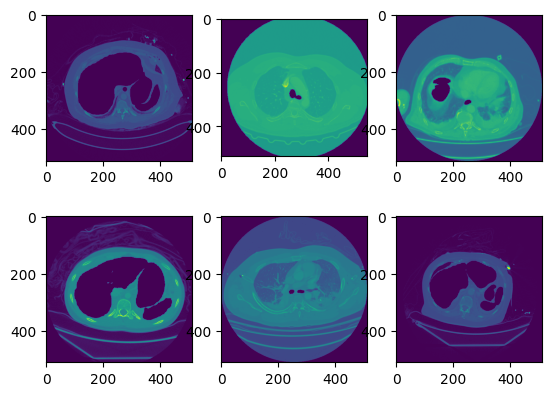

In [19]:

for i,rand_idx in enumerate(rand_idices):
    example = study_train_df.iloc[rand_idx]
    s_id = example.StudyInstanceUID
    p_id = s_id_p_id[str(s_id)]
    basename = f"../rsna-abdominal-2023/reduced_512_tickness_1/{p_id}/{s_id}"
    f_names = sorted([int(x.split("\\")[-1].split(".")[0]) for x in glob(f"{basename}/*.jpeg")])
    result = inference_detector(mmdet_model, f"{basename}/{f_names[example.slice_num]}.jpeg")
    img_data = cv2.imread(f"{basename}/{f_names[example.slice_num]}.jpeg")

    mmdet_pred = np.array([np.sum(x,axis=0) if len(x)>0 else np.zeros((512,img_data.shape[1])) for x in result[1]])
    mmdet_mask_argmax = mmdet_pred.argmax(0) # img_size * img_size
    mmdet_mask_max = mmdet_pred.max(0) # img_size * img_size
    # exa_image = np.load(example["image_path"])
    mmdet_mask = np.where(mmdet_mask_max>0.5, 0.0, img_data[:,:,1]).astype(np.uint8)
    plt.subplot(2,3,i+1);plt.imshow(mmdet_mask)

In [20]:
result[1][5][0].shape

(512, 512)

In [21]:
# iii = 21000
# basename = f"E:/mmdetection-master/mmdetection-master/mmdet/datasets/data/rsna/train/images/"
# f_names = sorted([(x.split("\\")[-1].split(".")[0]) for x in glob(f"{basename}/*.jpeg")])
# f_names

# result = inference_detector(model, f"{basename}/{f_names[iii]}.jpeg")


In [22]:
# for i in range(len(result[1])):
#     print(len(result[1][i]))
#     for j in range(len(result[1][i])):
#         print(result[1][i][j].shape)
#         print(np.unique(result[1][i][j]))

In [23]:
# np.unique(mmdet_pred[1])

# result[1][1]

In [24]:
# result[1][0].shape

In [25]:
mmdet_img = cv2.imread(f"{basename}/{f_names[example.slice_num]}.jpeg")
label_to_color = [(0,0,0),(255,0,0),(0,255,0),(0,0,255),(255,255,0),(0,255,255)]
for class_id in range(len(result[0])):
    assert len(result[0][class_id])==len(result[1][class_id])
    #if class_id!=1: continue
    for idx in range(len(result[0][class_id])):
        #if idx!=0: continue 
        bbox = result[0][class_id][idx]
        if bbox[4]<0.12:continue
        mmdet_img = cv2.rectangle(mmdet_img.astype(int),(int(bbox[0]),int(bbox[1])),\
            (int(bbox[2]),int(bbox[3])),color=(128,256,0))
        binary_img = result[1][class_id][idx]
        mmdet_img[:,:,0]=np.where(binary_img,label_to_color[class_id][0],mmdet_img[:,:,0])
        mmdet_img[:,:,1]=np.where(binary_img,label_to_color[class_id][1],mmdet_img[:,:,1])
        mmdet_img[:,:,2]=np.where(binary_img,label_to_color[class_id][2],mmdet_img[:,:,2])
# plt.imshow(mmdet_img)

In [26]:
mmdet_img[binary_img]

array([[  0, 255, 255],
       [  0, 255, 255],
       [  0, 255, 255],
       ...,
       [  0, 255, 255],
       [  0, 255, 255],
       [  0, 255, 255]])

In [27]:
slice_mask_argmax

array([[0, 0, 0, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       ...,
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4],
       [4, 4, 4, ..., 4, 4, 4]], dtype=int64)

In [28]:
slice_mask_max

array([[3.6378525e-04, 4.1029703e-06, 2.3650884e-06, ..., 1.9435745e-05,
        1.0405957e-05, 3.4465632e-04],
       [6.3433040e-06, 1.3064888e-08, 9.0207797e-09, ..., 3.1132251e-07,
        1.5650697e-07, 1.4733474e-05],
       [4.3615319e-06, 1.1438232e-08, 8.1302662e-09, ..., 6.1523849e-07,
        3.0536128e-07, 2.7435957e-05],
       ...,
       [4.0644190e-06, 8.6729157e-09, 4.7955262e-09, ..., 4.0636117e-09,
        1.3326198e-09, 7.5963106e-07],
       [8.1684184e-06, 1.4148841e-08, 6.0273635e-09, ..., 4.3870623e-09,
        1.5486075e-09, 8.2429648e-07],
       [6.4329099e-04, 7.7654040e-06, 3.6579279e-06, ..., 3.6801648e-06,
        2.4528097e-06, 1.3208832e-04]], dtype=float32)

In [29]:
for i in range(1,6):
    print(i, np.sum(exa_mask[:,:,1]==i))
for i in range(1,6):
    print(i, np.sum(mmdet_mask[:,:]==i))

1 14150
2 1346
3 1430
4 0
5 7111
1 32507
2 17208
3 8785
4 6928
5 4745


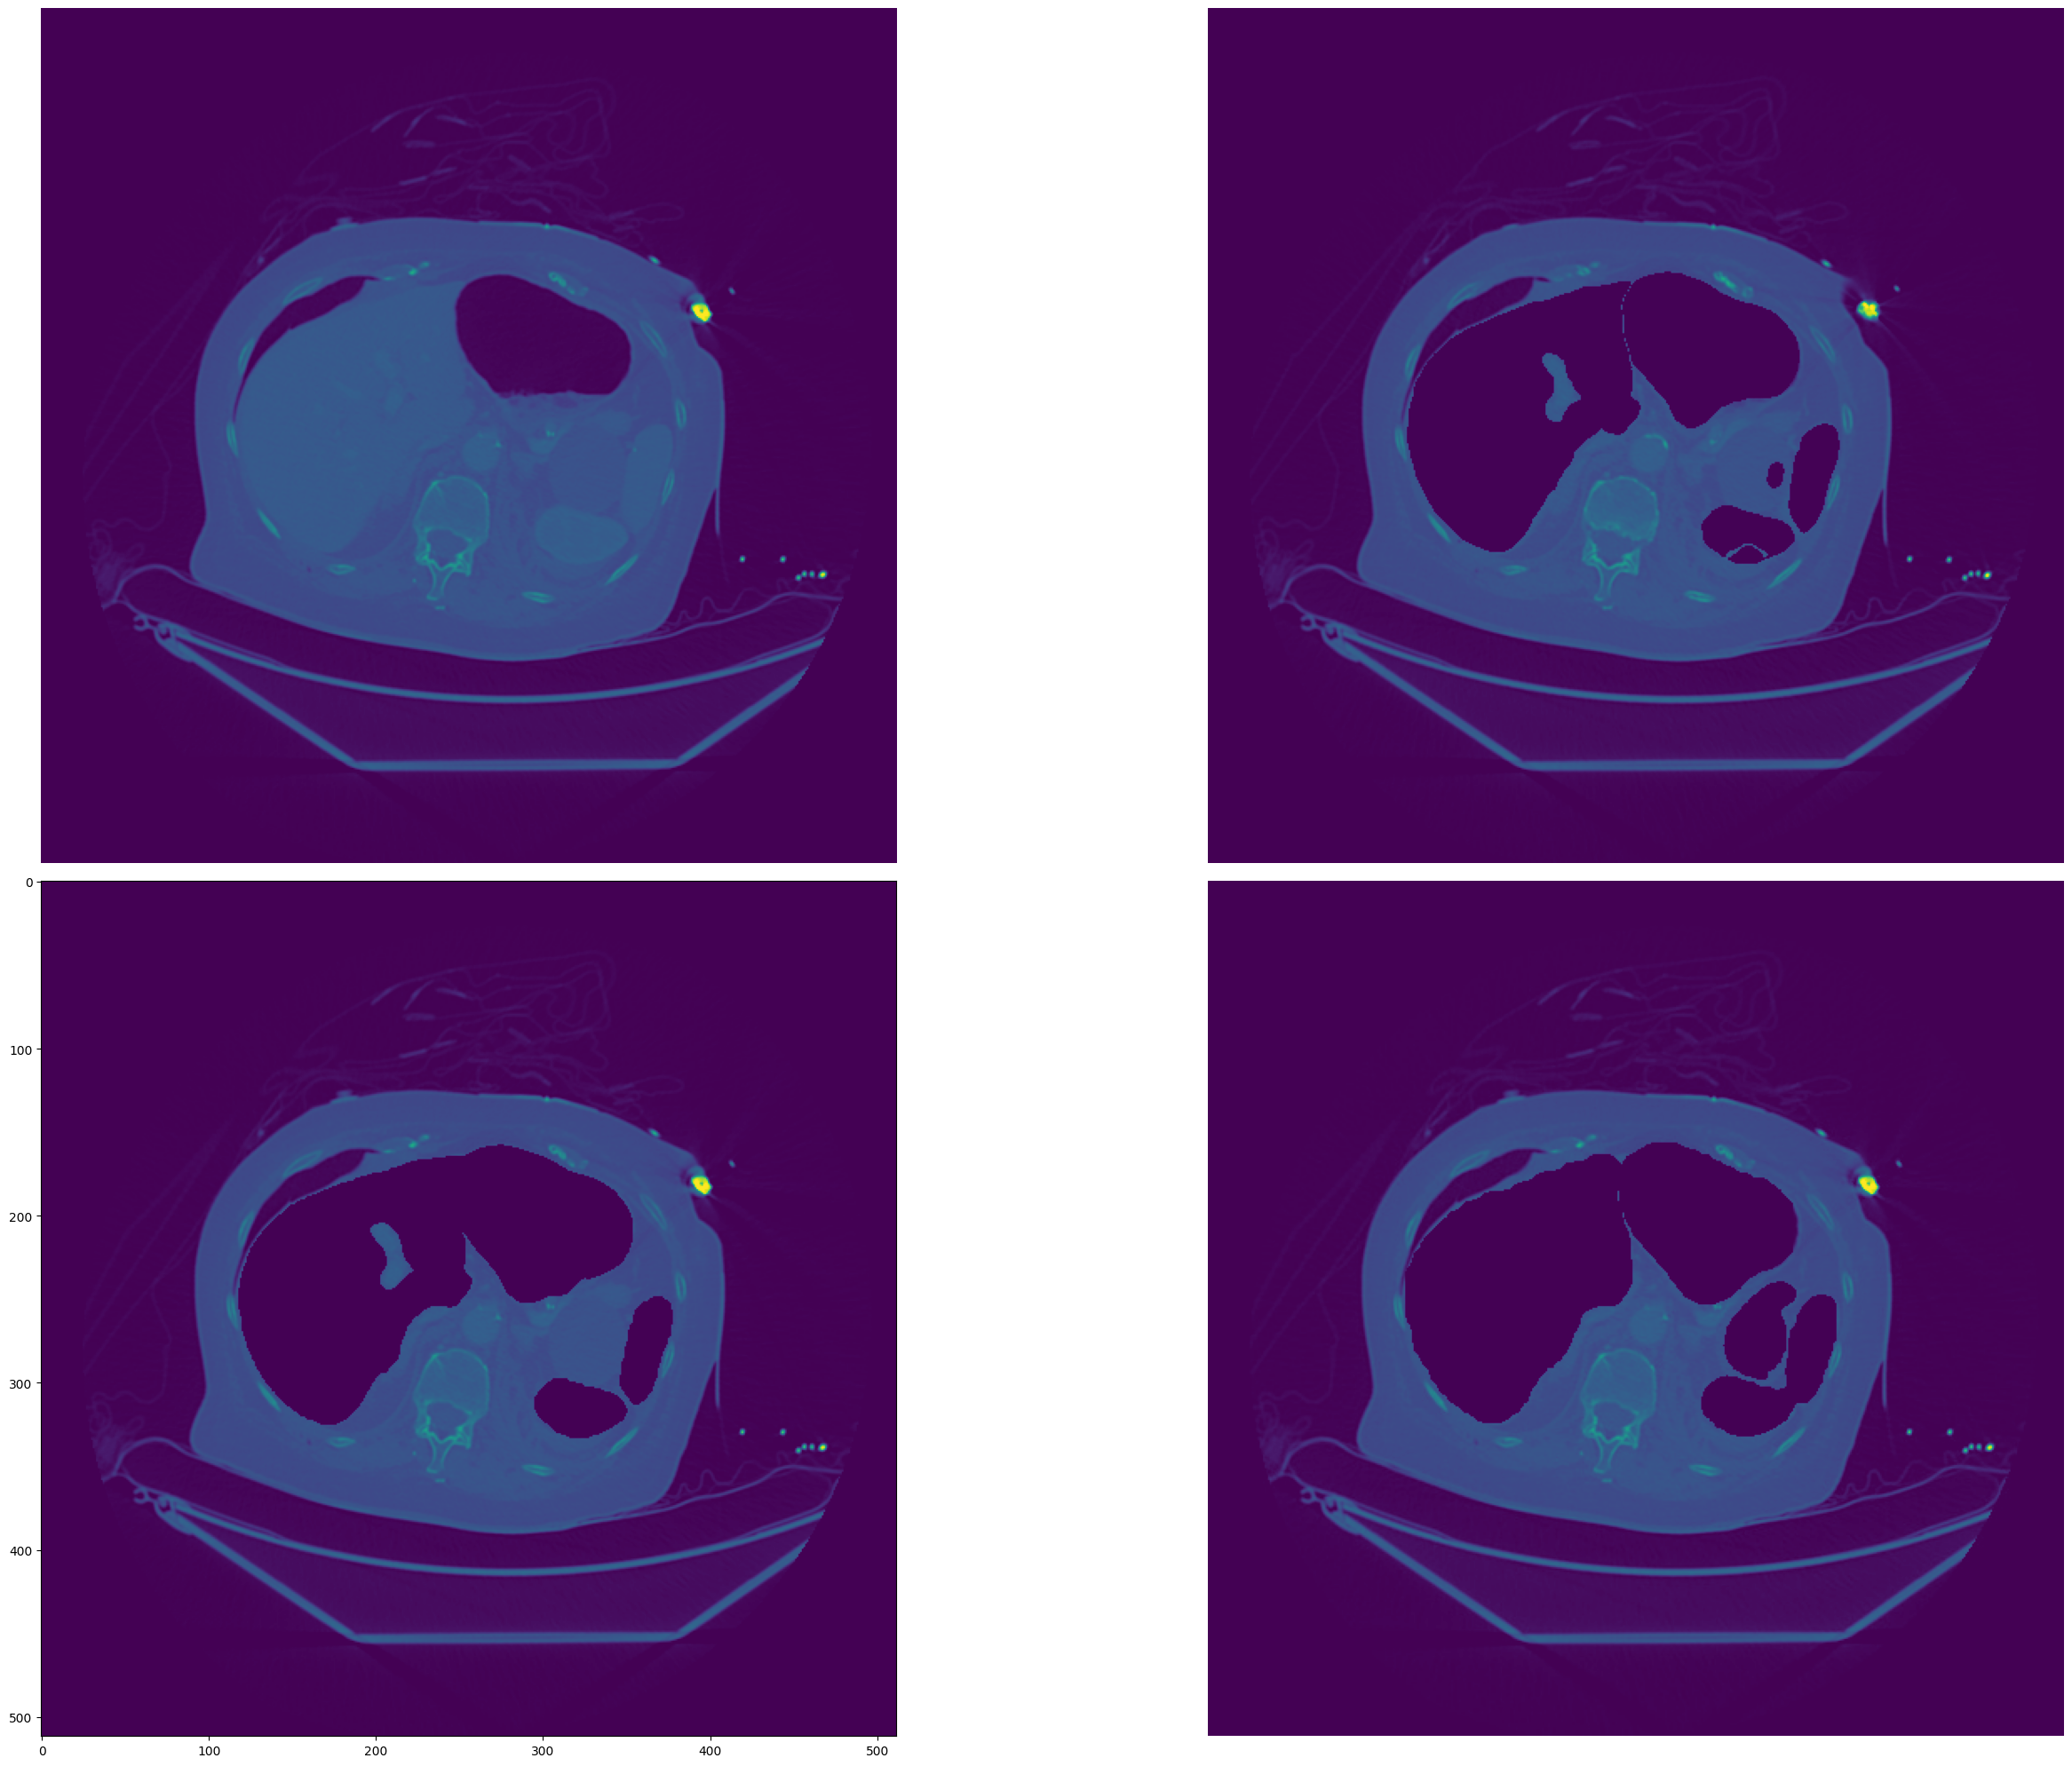

In [30]:
from matplotlib.patches import Rectangle

plt.figure(figsize=(30, 20))

img = exa_image[0][1].cpu().numpy() # 512*512; 0-1;
slice_mask = slice_mask # 512*512; 0or1; From mmdet
label_mask = exa_mask[:,:,1].astype("uint8") # 512*512; 0-8 classes; From ground trueth
plt.subplot(2, 2, 1); plt.imshow(img); plt.axis('OFF'); # 512*512; 0-1;
plt.subplot(2, 2, 2); plt.imshow(slice_mask); plt.axis('OFF');
plt.subplot(2, 2, 3); plt.imshow(np.where(exa_mask[:,:,1],0.0,img)); 

plt.subplot(2,2,4); plt.imshow(mmdet_mask)
plt.axis('OFF'); 
# plt.subplot(1, 3, 3); plt.imshow(slice_mask); plt.imshow(img,alpha=0.7); plt.axis('OFF');
# # plt.colorbar()
plt.tight_layout()
plt.show()

In [31]:
slice_mask.shape,exa_mask[:,:,1].shape
# np.sum(exa_mask[:,:,1]==slice_mask)

((512, 512), (512, 512))

In [32]:
# plt.imshow(exa_image[0][1].cpu())

# 2019Train CSV

In [33]:
study_train_df = pd.read_csv(f'{datadir}/train.csv')
print('train_df shape:', study_train_df.shape)
study_train_df.head(3)


train_df shape: (3147, 15)


patient_id  bowel_healthy  bowel_injury  extravasation_healthy  \
0       10004              1             0                      0   
1       10005              1             0                      1   
2       10007              1             0                      1   

   extravasation_injury  kidney_healthy  kidney_low  kidney_high  \
0                     1               0           1            0   
1                     0               1           0            0   
2                     0               1           0            0   

   liver_healthy  liver_low  liver_high  spleen_healthy  spleen_low  \
0              1          0           0               0           0   
1              1          0           0               1           0   
2              1          0           0               1           0   

   spleen_high  any_injury  
0            1           1  
1            0           0  
2            0           0

In [34]:
seg_paths = glob(f"{datadir}/segmentations/*")
seg_gt_list = [path.split('\\')[-1][:-4] for path in seg_paths]
print(len(seg_gt_list))
seg_gt_list[:3]

206


['10000', '10109', '10180']

In [35]:
len(np.unique([x.split("_")[-2] for x in glob(f"./seg_25d_image/*")]))

206

In [36]:
p_s = glob("G:/rsna-2023-abdominal-trauma-detection/train_images/*/*")

s_id_p_id = {x.split("\\")[-1]:x.split("\\")[-2] for x in p_s}
seg_p_id = [int(s_id_p_id[xx]) for xx in seg_gt_list]

In [37]:

seg_total = set([x.split("\\")[-1] for x in p_s])
len(p_s),len(seg_total), seg_gt_list[:10]

(4711,
 4711,
 ['10000',
  '10109',
  '10180',
  '10252',
  '10385',
  '10494',
  '11748',
  '1201',
  '12039',
  '12102'])

In [38]:
len(set(seg_p_id))

128

In [39]:
# s_id_p_id
# seg_gt_list

In [40]:
seg_psuedo_list = [x for x in seg_total if x not in seg_gt_list]
half_len = int(len(seg_psuedo_list)/2)
len1 = int(len(seg_psuedo_list)/3)
len2 = int(len(seg_psuedo_list)/3)*2

In [41]:
train_slice_list = []
for file_name in tqdm(sorted(seg_psuedo_list)[len1:len2]):
    #print(file_name)
    p_id = s_id_p_id[file_name]
    train_image_path = glob(f"{datadir}/train_images/{p_id}/{file_name}/*.dcm")
    train_image_path = sorted(train_image_path, key=lambda x:int(x.split("\\")[-1].replace(".dcm","")))
    #print("processing ",p_id,file_name,len(train_image_path))
    for path_idx in range(len(train_image_path)):
        path1 = "nofile" if path_idx-1 < 0 else train_image_path[path_idx-1].replace(f"{datadir}/", "")
        path2 = train_image_path[path_idx].replace(f"{datadir}/", "")
        path3 = "nofile" if path_idx+1 >= len(train_image_path) else train_image_path[path_idx+1].replace(f"{datadir}/", "")
        slice_num = int(path2.split("\\")[-1].replace(".dcm",""))
        train_slice_list.append([f"{file_name}_{slice_num}", file_name, slice_num, path1, path2, path3])

100%|██████████| 1501/1501 [00:02<00:00, 704.99it/s]


In [42]:
train_df = pd.DataFrame(train_slice_list, columns=["id", "StudyInstanceUID", "slice_num", "path1", "path2", "path3"])
train_df = train_df.sort_values(['StudyInstanceUID', 'slice_num'], ascending = [True, True]).reset_index(drop=True)
train_df.to_csv(f'{datadir}/train_slice_list.csv', index=False)
train_df

id StudyInstanceUID  slice_num  \
0        29431_82            29431         82   
1        29431_83            29431         83   
2        29431_84            29431         84   
3        29431_85            29431         85   
4        29431_86            29431         86   
...           ...              ...        ...   
460151  48873_909            48873        909   
460152  48873_910            48873        910   
460153  48873_911            48873        911   
460154  48873_912            48873        912   
460155  48873_913            48873        913   

                                   path1                             path2  \
0                                 nofile   train_images/28786/29431\82.dcm   
1        train_images/28786/29431\82.dcm   train_images/28786/29431\83.dcm   
2        train_images/28786/29431\83.dcm   train_images/28786/29431\84.dcm   
3        train_images/28786/29431\84.dcm   train_images/28786/29431\85.dcm   
4        train_images/28786/29431\85.dcm   train_images/28786/29431\86.dcm   
...                                  ...                               ...   
460151  train_images/30365/48873\908.dcm  train_images/30365/48873\909.dcm   
460152  train_images/30365/48873\909.dcm  train_images/30365/48873\910.dcm   
460153  train_images/30365/48873\910.dcm  train_images/30365/48873\911.dcm   
460154  train_images/30365/48873\911.dcm  train_images/30365/48873\912.dcm   
460155  train_images/30365/48873\912.dcm  train_images/30365/48873\913.dcm   

                                   path3  
0        train_images/28786/29431\83.dcm  
1        train_images/28786/29431\84.dcm  
2        train_images/28786/29431\85.dcm  
3        train_images/28786/29431\86.dcm  
4        train_images/28786/29431\87.dcm  
...                                  ...  
460151  train_images/30365/48873\910.dcm  
460152  train_images/30365/48873\911.dcm  
460153  train_images/30365/48873\912.dcm  
460154  train_images/30365/48873\913.dcm  
460155                            nofile  

[460156 rows x 6 columns]

In [43]:
# print(sorted(list(train_df.StudyInstanceUID.unique())))

In [44]:
len(train_df)
np.unique(train_df[train_df.StudyInstanceUID=="10006"].slice_num.values)

array([], dtype=int64)

In [45]:
glob("./"+train_df.iloc[0]["path2"])

['./train_images/28786/29431\\82.dcm']

# Dataset

In [46]:
# 构造 dataset类
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        im2 = load_dicom(f"{datadir}/{row['path2']}")   # 512*512  
        im2h = im2.shape[0]
        im2w = im2.shape[1]

        im1 = load_dicom(f"{datadir}/{row['path1']}") if row['path1'] != "nofile" else np.zeros((im2h, im2w))  # 512*512                                                       
        im3 = load_dicom(f"{datadir}/{row['path3']}") if row['path3'] != "nofile" else np.zeros((im2h, im2w))  # 512*512  

        if im1.shape !=  (im2h, im2w):
            im1 = cv2.resize(im1, (im2w, im2h))
        if im3.shape !=  (im2h, im2w):
            im3 = cv2.resize(im3, (im2w, im2h)) 
        image_list = [im1, im2, im3]
        image = np.stack(image_list, axis=2) # 512*512*3; 0-1

        # transform
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        # image = image/255.0
        image = np.transpose(image, (2, 0, 1)) # 3*img_size*img_size; 0-1
        return torch.from_numpy(image.astype(np.float32)), row['StudyInstanceUID'], row['slice_num'],row['path2']

In [47]:
# 图像AUG策略
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, 
    CenterCrop, Resize, RandomCrop, GaussianBlur, JpegCompression, Downscale, ElasticTransform
)
import albumentations

from albumentations.pytorch import ToTensorV2

def get_transforms(data):
    if data == 'train':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
            OneOf([
                GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
                OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
                ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=0.25),
            CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
                            min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
            ], p=1.0)

    elif data == 'light_train':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
            HorizontalFlip(p=0.5),
            # VerticalFlip(p=0.5),
            ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=10, p=0.5),
            OneOf([
                GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
                # OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
                ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
            ], p=0.25),
            # CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
            #              min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
            ], p=1.0)

    elif data == 'valid':
        return Compose([
            Resize(CFG.img_size, CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ])

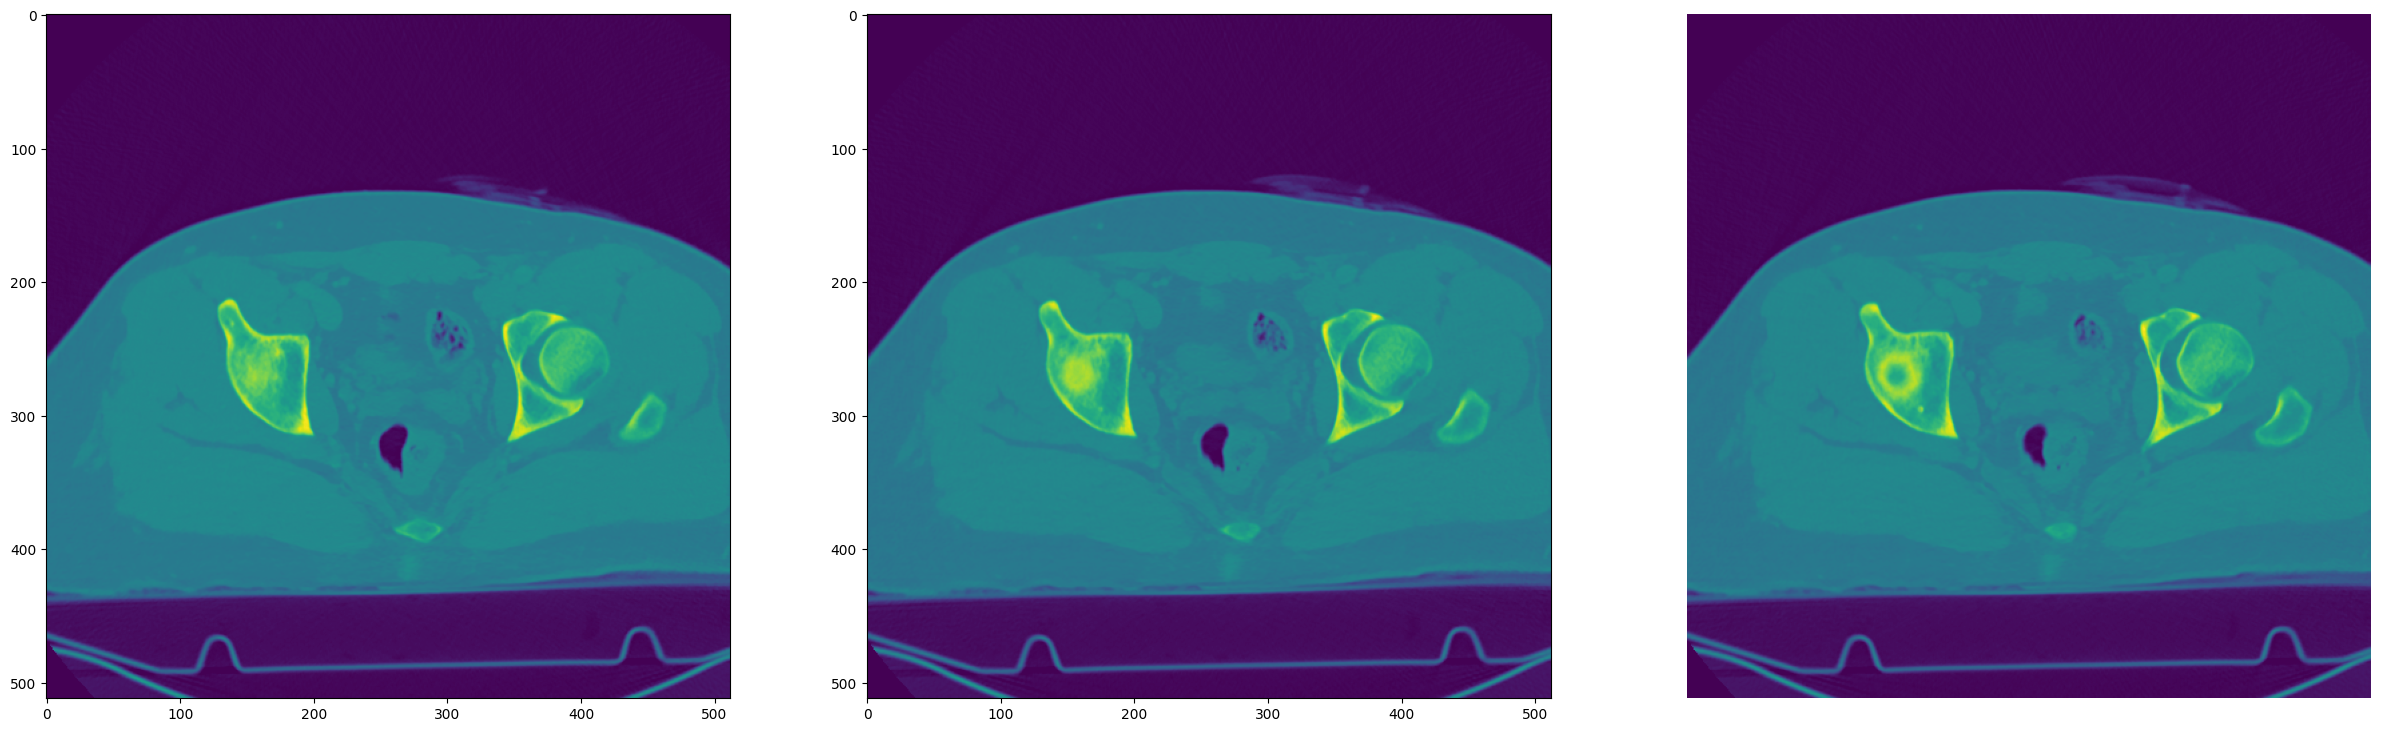

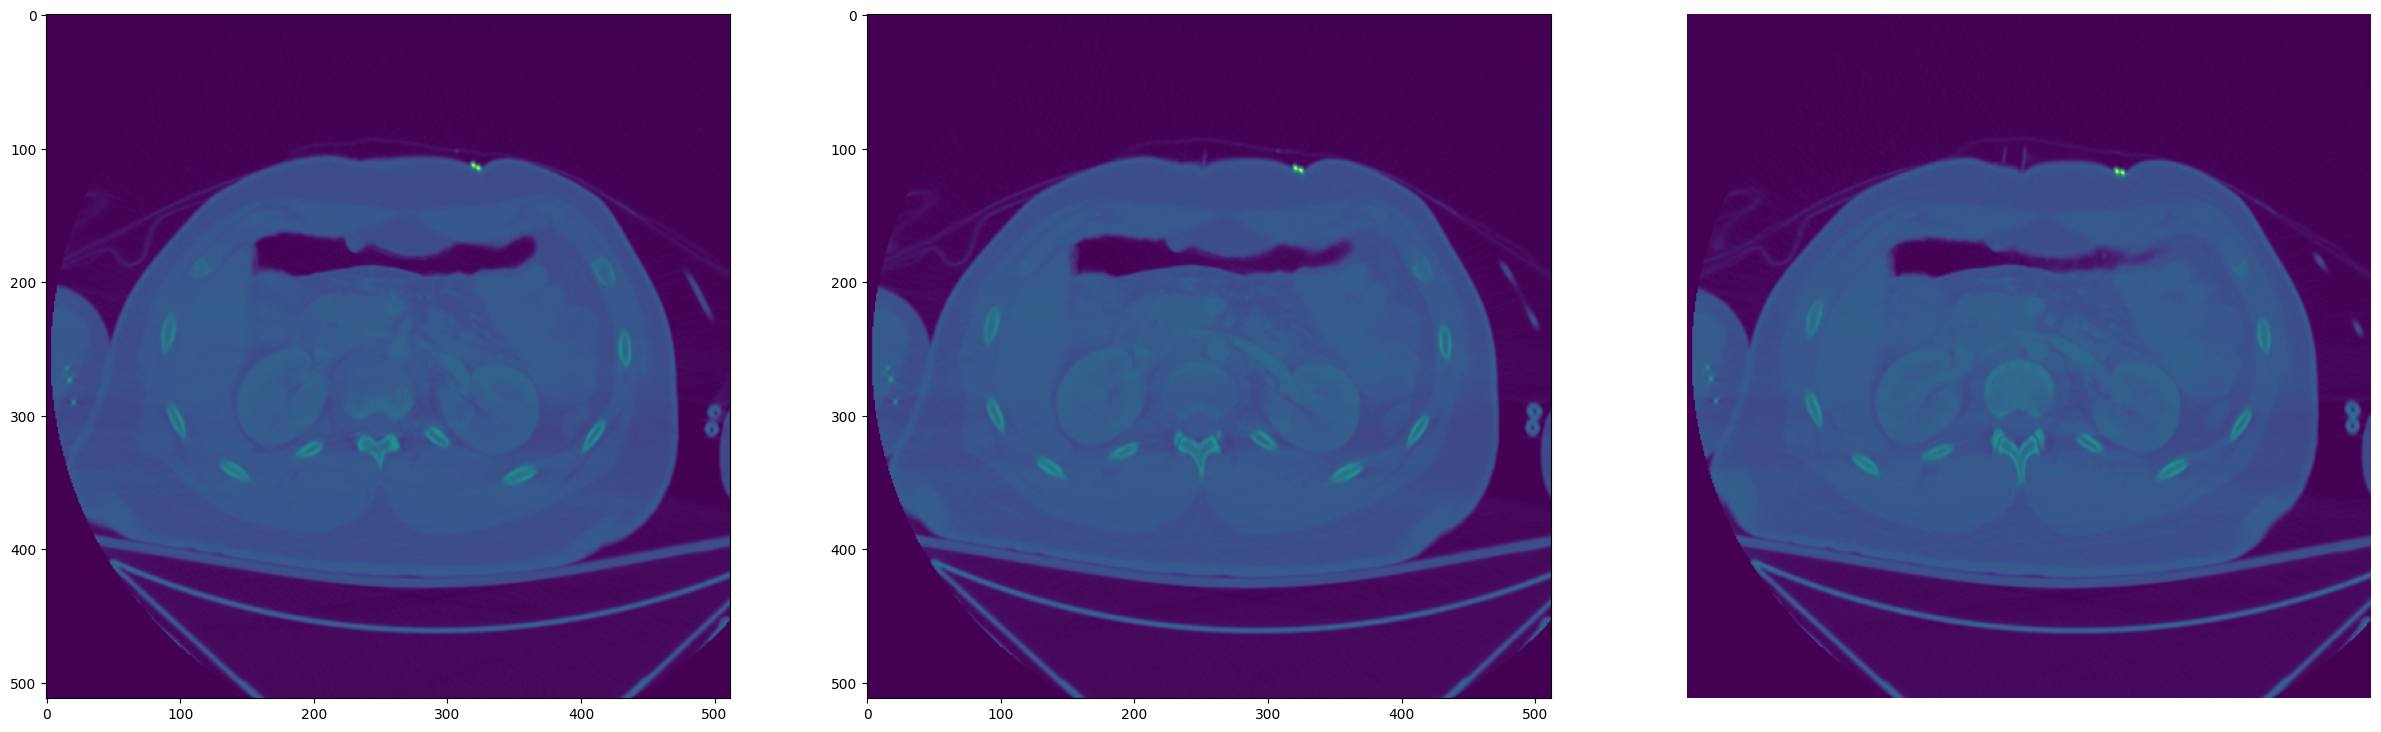

In [48]:
from pylab import rcParams
dataset_show = TrainDataset(
    train_df, 
    get_transforms("valid") # None, get_transforms("train")
    )
rcParams['figure.figsize'] = 30,20
for i in range(2):
    f, axarr = plt.subplots(1,3)
    idx = np.random.randint(0, len(dataset_show))
    img, file_name, n_slice,_= dataset_show[idx]
    # axarr[p].imshow(img) # transform=None
    axarr[0].imshow(img[0]); plt.axis('OFF');
    axarr[1].imshow(img[1]); plt.axis('OFF');
    axarr[2].imshow(img[2]); plt.axis('OFF');

In [49]:
np.unique(img[0]==img[1])

array([False,  True])

# Model

In [50]:
import segmentation_models_pytorch as smp

def build_model():
    model = smp.Unet(
        encoder_name=CFG.model_arch,    # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        activation=None,
    )
    model.to(device)
    return model

def load_model(path):
    model = build_model()
    model.load_state_dict(torch.load(path)["model"])
    model.eval()
    return model

# Inference

In [51]:
# os.makedirs(f"{outputdir}/train_voxel", exist_ok=True)
# os.makedirs(f"{outputdir}/train_voxel_mask", exist_ok=True)
# for filename in train_df["StudyInstanceUID"].values:
#     os.makedirs(f"{outputdir}/train_mask/{filename}", exist_ok=True)

In [52]:
slice_class_list = []
voxel_crop_list = []
def crop_voxel(voxel_mask, last_f_name):
    area_thr = 10
    # x
    x_list = []
    length = voxel_mask.shape[0]
    for i in range(length):
        if torch.count_nonzero(voxel_mask[i]).item() >= area_thr:
            x_list.append(i)
            break
    else:
        x_list.append(0)

    for i in range(length-1, -1, -1):
        if torch.count_nonzero(voxel_mask[i]).item() >= area_thr:
            x_list.append(i)
            break
    else:
        x_list.append(length-1)

    # y
    y_list = []
    length = voxel_mask.shape[1]
    for i in range(length):
        if torch.count_nonzero(voxel_mask[:, i]).item() >= area_thr:
            y_list.append(i)
            break
    else:
        y_list.append(0)

    for i in range(length-1, -1, -1):
        if torch.count_nonzero(voxel_mask[:, i]).item() >= area_thr:
            y_list.append(i)
            break
    else:
        y_list.append(length-1)

    torch.cuda.empty_cache()
    # z
    z_list = []
    length = voxel_mask.shape[2]
    for i in range(length):
        if torch.count_nonzero(voxel_mask[:, :, i]).item() >= area_thr:
            z_list.append(i)
            break
    else:
        z_list.append(0)

    for i in range(length-1, -1, -1):
        if torch.count_nonzero(voxel_mask[:, :, i]).item() >= area_thr:
            z_list.append(i)
            break
    else:
        z_list.append(length-1)
    # croped_voxel = voxels[x_list[0]:x_list[1]+1, y_list[0]:y_list[1]+1, z_list[0]:z_list[1]+1]
    try:
        croped_voxel_mask = voxel_mask[x_list[0]:x_list[1]+1, y_list[0]:y_list[1]+1, z_list[0]:z_list[1]+1]
    except:
        print(f"last_f_name:{last_f_name}, voxel_mask.shape:{voxel_mask.shape}, x_list:{x_list}, y_list:{y_list}, z_list:{z_list}")
        x_list = [0, voxel_mask.shape[0]-1]; y_list = [0, voxel_mask.shape[1]-1]; z_list = [0, voxel_mask.shape[2]-1]
        croped_voxel_mask = voxel_mask
    voxel_crop_list.append([last_f_name, voxel_mask.shape[1], x_list[0], x_list[1]+1, y_list[0], y_list[1]+1, z_list[0], z_list[1]+1])

    # croped_voxel = croped_voxel.to('cpu').numpy() # bs*img_size*img_size; 0-8 classes
    croped_voxel_mask = croped_voxel_mask.to('cpu').numpy().astype(np.uint8) # bs*img_size*img_size; 0-8 classes
    for x_idx in range(croped_voxel_mask.shape[0]):
        slice_mask = croped_voxel_mask[x_idx]

        unique, counts = np.unique(slice_mask, return_counts=True)
        if len(unique) == 1 and unique[0] == 0:
            slice_class_list.append([last_f_name, x_idx, x_idx+x_list[0], 0])
        elif unique[0] == 0:
            unique = unique[1:]
            counts = counts[1:]
            slice_class_list.append([last_f_name, x_idx, x_idx+x_list[0]+1, unique[counts.argmax()]])
        else:
            slice_class_list.append([last_f_name, x_idx, x_idx+x_list[0]+1, unique[counts.argmax()]])

    return None, croped_voxel_mask

In [53]:
torch.cuda.empty_cache()

In [54]:

result = inference_detector(mmdet_model, f"{basename}/{f_names[example.slice_num]}.jpeg")

mmdet_pred = np.array([np.sum(x,axis=0) if len(x)>0 else np.zeros((512,512)) for x in result[1]])
mmdet_mask_argmax = mmdet_pred.argmax(0) # img_size * img_size
mmdet_mask_max = mmdet_pred.max(0) # img_size * img_size
mmdet_mask = np.where(mmdet_mask_max>0.5, mmdet_mask_argmax, 0).astype(np.uint8)
# plt.subplot(1,3,1);plt.imshow(mmdet_mask)

In [55]:
os.getcwd()

'G:\\rsna-2023-abdominal-trauma-detection'

In [56]:
test_voxel_mask = []
test_last_name = []
test_img_data = []
voxel_mask_2=[]
def crop_voxel2(voxel_mask, last_f_name,img_data,slice_mask_2):
    img_data = np.array(img_data)
    mask_img = np.array(voxel_mask.cpu())
    print(mask_img.shape, s_id_p_id[last_f_name],last_f_name)
    assert mask_img.shape == img_data.shape
    for ii in range(1,6):
        mask_idx = np.where(np.array(mask_img==ii))
        if len(mask_idx)==0 or len(mask_idx[0])==0: continue
        #print(mask_idx)
        x_0,y_0,z_0 = np.mean(mask_idx[0]),np.mean(mask_idx[1]),np.mean(mask_idx[2])
        #print(x_0,y_0,z_0)
        x_0 = min(max(int(x_0-7),0),len(mask_img)-15)
        y_0 =min(max(int(y_0-112), 0), mask_img.shape[1]-224)
        z_0 =min(max(int(z_0-112), 0), mask_img.shape[2]-224)
        for jj in range(15):
            img_save = img_data[x_0+jj,y_0:y_0+224,z_0:z_0+224]
            #print(img_save.shape)
            cv2.imwrite(f"./224files/{s_id_p_id[last_f_name]}_{last_f_name}_{ii}_{jj}.jpeg",img_save*255.0)
    test_voxel_mask.append(voxel_mask)
    test_last_name.append(last_f_name)
    test_img_data.append(img_data)
    voxel_mask_2.append(slice_mask_2)

In [57]:
test_voxel_mask = []
test_last_name = []
test_img_data = []
voxel_mask_2=[]
voxel_mask_3=[]
def crop_voxel3(voxel_mask, last_f_name,img_data,slice_mask_2,slice_mask_3):
    img_data = np.array(img_data)
    mask_img = np.array(voxel_mask.cpu())
    print(mask_img.shape, s_id_p_id[last_f_name],last_f_name)
    assert mask_img.shape == img_data.shape
    coords_save = []
    for ii in range(1,6):
        mask_cls = (np.array(mask_img==ii))
        max_count = 0
        best_x = 0
        for x in range(mask_img.shape[0]-14):
            if np.sum(mask_cls[x:x+15]) > max_count:
                best_x = x
                max_count = np.sum(mask_cls[x:x+15])
        if max_count==0:continue
        y_z = np.where(mask_cls[best_x:best_x+15]==1)
        best_y =min(max(int(np.mean(y_z[1])-112), 0), mask_img.shape[1]-224)
        best_z =min(max(int(np.mean(y_z[2])-112), 0), mask_img.shape[1]-224)
        for jj in range(15):
            img_save = img_data[best_x+jj,best_y:best_y+224,best_z:best_z+224]
            #print(img_save.shape)
            # cv2.imwrite(f"./224files/{s_id_p_id[last_f_name]}_{last_f_name}_{ii}_{jj}.jpeg",img_save*255.0)
        coords_save.append([best_x,best_y,best_z])
    # np.save(f"./224files/{s_id_p_id[last_f_name]}_{last_f_name}_coord.npy",coords_save)
    # np.save(f"./224files/{s_id_p_id[last_f_name]}_{last_f_name}_mask.npy",mask_img)

    test_voxel_mask.append(voxel_mask)
    test_last_name.append(last_f_name)
    # test_img_data.append(img_data)
    voxel_mask_2.append(slice_mask_2)
    voxel_mask_3.append(slice_mask_3)

In [58]:
test_voxel_mask = []
test_last_sid = []
test_img_data = []
voxel_mask_2=[]
voxel_mask_3=[]
def crop_voxel4(voxel_mask, last_sid,img_data,slice_mask_2,slice_mask_3):
    img_data = np.array(img_data)
    mask_img = np.array(voxel_mask.cpu())
    print(mask_img.shape, s_id_p_id[last_sid],last_sid)
    assert mask_img.shape == img_data.shape
    for ii in range(1,6):
        idx_count = []
        for jj in range(mask_img.shape[0]):
            idx_count.append([jj, np.sum(mask_img[jj]==ii)])
        idx_count = sorted(idx_count,key=lambda x:-x[1])
        idx_count = idx_count[:25]
        idx_count = [x for x in idx_count if x[1]>15]
        print(idx_count[:10])
        for jj in range(len(idx_count)):
            idx_write = idx_count[jj][0]
            if idx_write ==0:
                indices_write = [idx_write,idx_write+1,idx_write+2]
            elif idx_write == img_data.shape[0]-1:
                indices_write = [idx_write-2,idx_write-1,idx_write]
            else:
                indices_write = [idx_write-1,idx_write,idx_write+1]
            y_z = np.where(mask_img[idx_write]==ii)
            # print(len(y_z[0]),len(y_z[1]))
            best_y =min(max(int(np.mean(y_z[0])-112), 0), mask_img.shape[1]-224)
            best_z =min(max(int(np.mean(y_z[1])-112), 0), mask_img.shape[1]-224)
            img_save = img_data[indices_write,best_y:best_y+224,best_z:best_z+224]
            img_save = img_save.transpose(1,2,0)
            # print(img_save.shape)
            cv2.imwrite(f"./cropped_images_3ch/{s_id_p_id[last_sid]}_{last_sid}_{ii}_{idx_write}.jpeg",img_save*255.0)
    
    # test_voxel_mask.append(voxel_mask)
    # test_last_sid.append(last_f_name)
    # test_img_data.append(img_data)
    # voxel_mask_2.append(slice_mask_2)
    # voxel_mask_3.append(slice_mask_3)

In [59]:
test_voxel_mask = []
test_last_sid = []
test_img_data = []
voxel_mask_2=[]
voxel_mask_3=[]
# find all nonzero and resize
def crop_voxel5(voxel_mask, last_sid,img_data,slice_mask_2,slice_mask_3):
    img_data = np.array(img_data)
    mask_img = np.array(voxel_mask.cpu())
    print(mask_img.shape, s_id_p_id[last_sid],last_sid)
    assert mask_img.shape == img_data.shape
    for ii in range(1,6):
        idx_count = []
        for jj in range(mask_img.shape[0]):
            idx_count.append([jj, np.sum(mask_img[jj]==ii)])
        idx_count = sorted(idx_count,key=lambda x:-x[1])
        idx_count = idx_count[:25]
        idx_count = [x for x in idx_count if x[1]>15]
        print(idx_count[:10])
        for jj in range(len(idx_count)):

            idx_write = idx_count[jj][0]
            y_list = np.where((mask_img[idx_write]==ii).sum(1)>10)[0]
            z_list = np.where((mask_img[idx_write]==ii).sum(0)>10)[0]
            # find crop range
            if len(y_list) == 0 or len(z_list) == 0:
                continue
            y_min, y_max = min(y_list), max(y_list)
            z_min, z_max = min(z_list), max(z_list)
            if y_max - y_min < 100:
                y_center = (y_max+y_min)/2
                y_max,y_min = int(y_center+50),int(y_center-50)
            if z_max - z_min < 100:
                z_center = (z_max+z_min)/2
                z_max,z_min = int(z_center+50),int(z_center-50)
            # 3 channels image
            if idx_write ==0:
                indices_write = [idx_write,idx_write+1,idx_write+2]
            elif idx_write == img_data.shape[0]-1:
                indices_write = [idx_write-2,idx_write-1,idx_write]
            else:
                indices_write = [idx_write-1,idx_write,idx_write+1]
            y_z = np.where(mask_img[idx_write]==ii)
            # print(len(y_z[0]),len(y_z[1]))
            img_save = img_data[indices_write,y_min:y_max+1,z_min:z_max+1]
            img_save = img_save.transpose(1,2,0)
            img_save = cv2.resize(img_save,(384,384))
            # print(img_save.shape)
            cv2.imwrite(f"./cropped_images_resize/{s_id_p_id[last_sid]}_{last_sid}_{ii}_{idx_write}.jpeg",img_save*255.0)
    
    # test_voxel_mask.append(voxel_mask)
    # test_last_sid.append(last_f_name)
    # test_img_data.append(img_data)
    # voxel_mask_2.append(slice_mask_2)
    # voxel_mask_3.append(slice_mask_3)

In [60]:
test_last_name
[s_id_p_id[x] for x in test_last_name]

[]

In [61]:
def expand_array(input_mask):
    added1 = added2 = added3 = added4 = np.zeros(input_mask.shape)
    added1[:,1:] = input_mask[:,:-1]
    added2[:,:-1] = input_mask[:,1:]
    added3[1:,:] = input_mask[:-1,:]
    added3[:-1,:] = input_mask[1:,:]
    return added1+added2+added3+added4+input_mask>0
test_image = np.random.choice(glob("./segmentations/*"))

test_mask = nib.load(test_image)
print(test_mask.shape)
test_mask = test_mask.get_fdata()  # convert to numpy array
test_mask = test_mask[:, ::-1, ::-1].transpose(1, 0, 2).transpose(2,0,1)
test_mask = test_mask==1
test_mask = test_mask[np.random.choice(np.where(test_mask.sum(1).sum(1)>20)[0])]
print(test_mask.shape)
# plt.subplot(1,2,1);plt.imshow(test_mask)
expanded_mask = test_mask
for jj in range(5):
    expanded_mask = expand_array(expanded_mask)
print(np.sum(test_mask),np.sum(expanded_mask))
# plt.subplot(1,2,2);plt.imshow(expanded_mask)

(512, 512, 62)
(512, 512)
20723 21876


In [62]:
# np.stack([np.array([1,2]),np.array([1,2])]),np.array([np.array([1,2]),np.array([1,2])])

In [63]:
test_voxel_mask = []
test_last_name = []
test_img_data = []
voxel_mask_2=[]
test_tensor = []
import torch.nn.functional as F
VOLUME = (128,256,256)
def interpolate_tensor(input_arr):
    tmp_tensor = torch.Tensor(input_arr)
    tmp_tensor = tmp_tensor.unsqueeze(dim=0).unsqueeze(dim=0)
    tmp_tensor = F.interpolate(tmp_tensor, [VOLUME[0], VOLUME[1], VOLUME[2]]).squeeze()
    return tmp_tensor


def crop_voxel6(voxel_mask, last_f_name,img_data,slice_mask_2,slice_mask_3):
    img_data = np.array(img_data)
    mask_img = np.array(voxel_mask.cpu())
    print(mask_img.shape, s_id_p_id[last_f_name],last_f_name)
    assert mask_img.shape == img_data.shape
    coords_save = []
    pid = s_id_p_id[last_f_name]
    dcm_files = glob(f"./train_images/{pid}/{last_f_name}/*.dcm")
    dcm_ids = [int(x.split("\\")[-1].split(".")[0]) for x in dcm_files]
    min_dcm_id = min(dcm_ids)
    for ii in range(1,6):
        mask_cls = (np.array(mask_img==ii))
        img_list = []
        mask_list = []
        for jj in range(mask_img.shape[0]):
            if np.sum(mask_cls[jj])==0:continue
            
            mask_list.append(mask_cls[jj])  #cv2.resize(mask_cls[jj],(256,256))
            img_list.append(img_data[jj]) #cv2.resize(img_data[jj],(256,256))
            r_img = np.where(mask_cls[jj],  mask_cls[jj],0.0)
            save_img = np.array([r_img,img_data[jj],img_data[jj]]).transpose(1,2,0)
            # print(save_img.shape)
            cv2.imwrite(f"D:/cropped_organs_img/{pid}_{last_f_name}_{ii}_{jj+min_dcm_id}.jpeg",\
                        (save_img*255))

        # img_tensor = interpolate_tensor(np.array(img_list))
        # mask_tensor = interpolate_tensor(np.array(mask_list))
        # if len(img_list)==0: continue
        
        # # subsample_indices = [int(x) for x in np.linspace(0,len(img_list)-1,VOLUME[0])]
        # # img_tensor = torch.Tensor(np.array(img_list)[subsample_indices])
        # # mask_tensor = torch.Tensor(np.array(mask_list)[subsample_indices])
        # cls_tensor = torch.transpose(torch.stack([img_tensor,mask_tensor],dim=0),0,1)
        # print("cls interpolated data", np.array(cls_tensor).shape)
        # np.save(f"D:/cropped_organs_npy/{pid}_{last_f_name}_{ii}.npy",np.array(cls_tensor))
        # test_tensor.append(np.array(cls_tensor))

    # test_voxel_mask.append(voxel_mask)
    # test_last_name.append(last_f_name)
    # test_img_data.append(img_data)
    # voxel_mask_2.append(slice_mask_2)
# trn_X = train_df
# print(train_df.shape,len(np.unique(trn_X.StudyInstanceUID.values)),trn_X.StudyInstanceUID.values[:10])
# processed = [x.split("_")[-3] for x in glob(f"./cropped_organs/*_*_*.jpeg")]
# processed = [x.split("_")[-2] for x in glob(f"D:/cropped_organs_npy/*_*_*.npy")]
# existing = set(np.unique(train_df.StudyInstanceUID.values))
# print(len(np.unique(processed)))
# trn_X = train_df[~train_df.StudyInstanceUID.isin(processed)]
# len(processed),len(set(processed)),len(np.unique(trn_X.StudyInstanceUID.values))

In [64]:
before_images = []
after_images = []
test_tensor = []

def crop_voxel7(voxel_mask, last_f_name,img_data,slice_mask_2,slice_mask_3):
    img_data = np.array(img_data)
    mask_img = np.array(voxel_mask.cpu())
    print(mask_img.shape, s_id_p_id[last_f_name],last_f_name)
    assert mask_img.shape == img_data.shape
    coords_save = []
    pid = s_id_p_id[last_f_name]
    dcm_files = glob(f"./train_images/{pid}/{last_f_name}/*.dcm")
    dcm_ids = [int(x.split("\\")[-1].split(".")[0]) for x in dcm_files]
    min_dcm_id = min(dcm_ids)
    tensor_6ch = [img_data]
    for cls_id in range(1,6):
        tensor_6ch.append(mask_img==cls_id)
    # print(torch.Tensor(tensor_6ch).shape)
    tensor_6ch = F.interpolate(torch.Tensor(np.array(tensor_6ch)).unsqueeze(dim=0), [VOLUME[0], VOLUME[1], VOLUME[2]]).squeeze()
    print(tensor_6ch.shape)
    # test_tensor.append(np.array(tensor_6ch))
    np.save(f"D:/tensor_6ch/{pid}_{last_f_name}.npy",np.array(tensor_6ch))
    for ii in range(5):
        np.save(f"D:/tensor_2ch/{pid}_{last_f_name}_{ii+1}.npy",np.array(tensor_6ch[[0,ii+1]]))
    # r_img = np.where(mask_img<3, mask_img*100, 0)
    # g_img = np.where(mask_img>2, (mask_img-2)*80,0)
    # before_images.append([])
    # after_images.append([])
    # for jj in range(mask_img.shape[0]):
    #     save_img = np.array([r_img[jj],g_img[jj],img_data[jj]*255.0]).transpose(1,2,0)
    #     cv2.imwrite(f"./cropped_6ch/{pid}_{last_f_name}_{jj+min_dcm_id}.jpeg",\
    #                 (save_img))
    #     before_images[-1].append(save_img)
    #     recovered = cv2.imread(f"./cropped_6ch/{pid}_{last_f_name}_{jj+min_dcm_id}.jpeg")
    #     after_images[-1].append(recovered)
trn_X = train_df

print(train_df.shape)
processed = [x.split("_")[-1].split(".")[0] for x in glob(f"D:/tensor_6ch/*_*.npy")]
existing = set(np.unique(train_df.StudyInstanceUID.values))
print(len(np.unique(processed)))
trn_X = train_df[~train_df.StudyInstanceUID.isin(processed)]
len(processed),len(set(processed)),len(np.unique(trn_X.StudyInstanceUID.values))


(460156, 6)
2323


(2323, 2323, 611)

In [65]:
test_dataset = TrainDataset(trn_X, transform=get_transforms("valid")) # get_transforms("valid")
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)

last_sid = ""#train_df.iloc[0].StudyInstanceUID
voxel_mask = []
img_data = []
slice_mask_2=[]
slice_mask_3=[]
# voxels = []
rr = []
for step, (images, sids, n_slice,img_paths) in tqdm(enumerate(test_loader),total=len(test_loader)):
    #print(file_names[0])
    #if step<131: continue
    batch_size = images.size(0)
    # print(images.shape)
    # with torch.no_grad():
    #     y_pred = model(images.to(device, dtype=torch.float)) # [B, 8, H, W]
    results = []
    #print(img_paths)
    # mmdetection reuls
    batch_img_data=[]
    for b_i in range(batch_size):
        img_tmp = np.array(images[b_i][1])
        # print("max min ", img_tmp.max(),img_tmp.min())
        # print(img_tmp.shape)
        if img_tmp.shape != (512,512):
            break
        if os.path.exists(f"./tmp_images/tmp{sids[b_i]}_{b_i}.jpeg"):
            os.remove(f"./tmp_images/tmp{sids[b_i]}_{b_i}.jpeg")
        batch_img_data.append(img_tmp)
        # print(img_paths[b_i], img_tmp.shape)
        cv2.imwrite(f"./tmp_images/tmp{sids[b_i]}_{b_i}.jpeg",cv2.cvtColor((img_tmp*255).astype(np.uint8), cv2.COLOR_GRAY2RGB))
    for b_i in range(batch_size):
        if not os.path.exists(f"./tmp_images/tmp{sids[b_i]}_{b_i}.jpeg"): continue
        result = (inference_detector(mmdet_model, f"./tmp_images/tmp{sids[b_i]}_{b_i}.jpeg"))
        os.remove(f"./tmp_images/tmp{sids[b_i]}_{b_i}.jpeg")
        mmdet_pred = np.array([np.sum(x,axis=0) if len(x)>0 else np.zeros((512,512)) for x in result[1]])
        results.append(mmdet_pred)
    # y_pred = y_pred.sigmoid()
    # print("pred 1 shape", y_pred.shape)
    # slice_mask_max2 = torch.max(y_pred, 1) # bs*img_size*img_size
    # slice_mask2 = torch.where((slice_mask_max2.values)>0.5, slice_mask_max2.indices+1, 0) # bs*img_size*img_size; 0-8 classes
    # slice_mask2 = torch.where(slice_mask2==8,0,slice_mask2).type(torch.uint8)    
    # slice_mask = slice_mask2
    # print("pred 2 shape", torch.from_numpy(np.array(results)).shape)
    slice_mask_max3 = torch.max(torch.from_numpy(np.array(results)), 1) # bs*img_size*img_size
    slice_mask3 = torch.where((slice_mask_max3.values)>0.5, slice_mask_max3.indices, 0) # bs*img_size*img_size; 0-8 classes
    slice_mask3 = torch.where(slice_mask3==8,0,slice_mask3).type(torch.uint8)
    slice_mask = slice_mask3
    # slice_mask_max = torch.max(torch.from_numpy(np.array(results))[:,1:].cuda()+y_pred, 1) # bs*img_size*img_size
    # slice_mask = torch.where((slice_mask_max.values)>0.5, slice_mask_max.indices+1, 0) # bs*img_size*img_size; 0-8 classes
    # slice_mask = torch.where(slice_mask==8,0,slice_mask).type(torch.uint8)

    #slice_mask = slice_mask.to('cpu').numpy().astype(np.uint8) # bs*img_size*img_size; 0-8 classes
    # slice_image = images[:, 1, :, :] # bs*img_size*img_size
    torch.cuda.empty_cache()
    start_idx = 0
    for bs_idx in range(len(slice_mask)):
        sid = sids[bs_idx]
        if sid != last_sid:
            voxel_mask.append(slice_mask[start_idx:bs_idx])
            # slice_mask_2.append(slice_mask2[start_idx:bs_idx])
            # slice_mask_3.append(slice_mask3[start_idx:bs_idx])
            img_data+=batch_img_data[start_idx:bs_idx]
            # voxels.append(slice_image[start_idx:bs_idx])
            voxel_mask = torch.cat(voxel_mask, dim=0) # n_slice*img_size*img_size; 0-8 classes
            # slice_mask_2 = torch.cat(slice_mask_2, dim=0)
            # slice_mask_3 = torch.cat(slice_mask_3, dim=0)
            # voxels = torch.cat(voxels, dim=0) # n_slice*img_size*img_size
            if len(voxel_mask) > 0:
                # print(len(voxel_mask))
                crop_voxel7(voxel_mask, last_sid,img_data,slice_mask_2,slice_mask_3)
                crop_voxel6(voxel_mask, last_sid,img_data,slice_mask_2,slice_mask_3)
            print("new sid", sid)
            last_sid = sid
            img_data=[]
            start_idx = bs_idx
            voxel_mask = []
            slice_mask_2 = []
            slice_mask_3 = []
            # voxels = []
        elif bs_idx == len(slice_mask)-1:
            voxel_mask.append(slice_mask[start_idx:len(slice_mask)])
            # slice_mask_2.append(slice_mask2[start_idx:len(slice_mask)])
            # slice_mask_3.append(slice_mask3[start_idx:len(slice_mask)])
            img_data+=batch_img_data[start_idx:len(slice_mask)]
            # voxels.append(slice_image[start_idx:batch_size])
    gc.collect()
voxel_mask = torch.cat(voxel_mask, dim=0)
# slice_mask_2 = torch.cat(slice_mask_2, dim=0)
# slice_mask_3 = torch.cat(slice_mask_3, dim=0)
if len(voxel_mask) > 0:
    crop_voxel7(voxel_mask, last_sid,img_data,slice_mask_2,slice_mask_3)
    crop_voxel6(voxel_mask, last_sid,img_data,slice_mask_2,slice_mask_3)


  0%|          | 1/12233 [00:01<4:30:16,  1.33s/it]

new sid 37836


  0%|          | 43/12233 [00:52<4:02:59,  1.20s/it]

(695, 512, 512) 35863 37836
torch.Size([6, 128, 256, 256])
(695, 512, 512) 35863 37836
new sid 37872


  1%|          | 82/12233 [02:03<4:05:36,  1.21s/it] 

(623, 512, 512) 43388 37872
torch.Size([6, 128, 256, 256])
(623, 512, 512) 43388 37872
new sid 37876


  1%|          | 94/12233 [02:41<4:50:57,  1.44s/it] 

(186, 512, 512) 46764 37876
torch.Size([6, 128, 256, 256])
(186, 512, 512) 46764 37876


  1%|          | 95/12233 [02:47<10:02:36,  2.98s/it]

new sid 37930


  1%|          | 126/12233 [03:24<3:35:24,  1.07s/it]

(516, 512, 512) 44374 37930
torch.Size([6, 128, 256, 256])
(516, 512, 512) 44374 37930
new sid 37944


  1%|          | 129/12233 [03:44<12:13:15,  3.63s/it]

(59, 512, 512) 48657 37944
torch.Size([6, 128, 256, 256])
(59, 512, 512) 48657 37944


  1%|          | 130/12233 [03:48<13:02:50,  3.88s/it]

new sid 37953


  1%|          | 143/12233 [04:03<3:32:57,  1.06s/it] 

(222, 512, 512) 29692 37953
torch.Size([6, 128, 256, 256])
(222, 512, 512) 29692 37953


  1%|          | 144/12233 [04:10<9:48:06,  2.92s/it]

new sid 37971


  2%|▏         | 187/12233 [05:00<3:23:51,  1.02s/it]

(700, 512, 512) 48915 37971
torch.Size([6, 128, 256, 256])
(700, 512, 512) 48915 37971


  2%|▏         | 188/12233 [05:20<22:12:15,  6.64s/it]

new sid 37975


  2%|▏         | 193/12233 [05:26<7:03:57,  2.11s/it] 

(97, 512, 512) 56836 37975
torch.Size([6, 128, 256, 256])
(97, 512, 512) 56836 37975


  2%|▏         | 194/12233 [05:31<9:43:32,  2.91s/it]

new sid 38009


  2%|▏         | 203/12233 [05:41<4:00:05,  1.20s/it]

(162, 512, 512) 36832 38009
torch.Size([6, 128, 256, 256])
(162, 512, 512) 36832 38009


  2%|▏         | 204/12233 [05:47<8:48:27,  2.64s/it]

new sid 38013


  2%|▏         | 248/12233 [06:40<3:30:43,  1.05s/it]

(718, 512, 512) 13012 38013
torch.Size([6, 128, 256, 256])
(718, 512, 512) 13012 38013


  2%|▏         | 249/12233 [06:58<21:00:39,  6.31s/it]

new sid 38015


  2%|▏         | 260/12233 [07:10<3:35:03,  1.08s/it] 

(183, 512, 512) 36695 38015
torch.Size([6, 128, 256, 256])
(183, 512, 512) 36695 38015


  2%|▏         | 261/12233 [07:16<9:02:06,  2.72s/it]

new sid 38027


  2%|▏         | 299/12233 [08:01<3:28:24,  1.05s/it]

(632, 512, 512) 27392 38027
torch.Size([6, 128, 256, 256])
(632, 512, 512) 27392 38027
new sid 38031


  3%|▎         | 338/12233 [09:11<4:04:44,  1.23s/it] 

(617, 512, 512) 36364 38031
torch.Size([6, 128, 256, 256])
(617, 512, 512) 36364 38031


  3%|▎         | 339/12233 [09:27<18:50:09,  5.70s/it]

new sid 38062


  3%|▎         | 347/12233 [09:37<4:57:52,  1.50s/it] 

(152, 512, 512) 22443 38062
torch.Size([6, 128, 256, 256])
(152, 512, 512) 22443 38062
new sid 38081


  3%|▎         | 370/12233 [10:08<3:50:12,  1.16s/it]

(362, 512, 512) 26164 38081
torch.Size([6, 128, 256, 256])
(362, 512, 512) 26164 38081
new sid 38121


  3%|▎         | 377/12233 [10:26<4:57:12,  1.50s/it] 

(117, 512, 512) 52513 38121
torch.Size([6, 128, 256, 256])
(117, 512, 512) 52513 38121
new sid 38179


  3%|▎         | 389/12233 [10:53<5:49:58,  1.77s/it] 

(187, 512, 512) 64851 38179
torch.Size([6, 128, 256, 256])
(187, 512, 512) 64851 38179


  3%|▎         | 390/12233 [11:04<14:47:13,  4.49s/it]

new sid 38191


  3%|▎         | 427/12233 [12:21<6:39:34,  2.03s/it] 

(604, 512, 512) 18240 38191
torch.Size([6, 128, 256, 256])
(604, 512, 512) 18240 38191
new sid 38226


  4%|▍         | 465/12233 [14:20<7:06:58,  2.18s/it] 

(615, 512, 512) 32036 38226
torch.Size([6, 128, 256, 256])
(615, 512, 512) 32036 38226
new sid 38242


  4%|▍         | 504/12233 [16:14<7:01:25,  2.16s/it] 

(616, 512, 512) 16926 38242
torch.Size([6, 128, 256, 256])
(616, 512, 512) 16926 38242


  4%|▍         | 505/12233 [16:43<32:34:47, 10.00s/it]

new sid 38271


  4%|▍         | 514/12233 [17:04<8:30:22,  2.61s/it] 

(162, 512, 512) 30683 38271
torch.Size([6, 128, 256, 256])
(162, 512, 512) 30683 38271
new sid 38273


  5%|▍         | 556/12233 [18:33<5:25:26,  1.67s/it] 

(682, 512, 512) 57106 38273
torch.Size([6, 128, 256, 256])
(682, 512, 512) 57106 38273
new sid 3828


  5%|▍         | 563/12233 [19:13<9:11:48,  2.84s/it] 

(115, 512, 512) 34386 3828
torch.Size([6, 128, 256, 256])
(115, 512, 512) 34386 3828


  5%|▍         | 564/12233 [19:20<13:55:10,  4.29s/it]

new sid 38290


  5%|▍         | 570/12233 [19:32<7:03:24,  2.18s/it] 

(102, 512, 512) 45361 38290
torch.Size([6, 128, 256, 256])
(102, 512, 512) 45361 38290
new sid 383


  5%|▍         | 580/12233 [20:04<8:01:39,  2.48s/it] 

(160, 512, 512) 30890 383
torch.Size([6, 128, 256, 256])
(160, 512, 512) 30890 383


  5%|▍         | 581/12233 [20:15<16:02:30,  4.96s/it]

new sid 38305


  5%|▌         | 626/12233 [21:50<6:13:32,  1.93s/it] 

(730, 512, 512) 2602 38305
torch.Size([6, 128, 256, 256])
(730, 512, 512) 2602 38305


  5%|▌         | 627/12233 [22:25<37:46:22, 11.72s/it]

new sid 38307


  5%|▌         | 638/12233 [22:49<6:58:23,  2.17s/it] 

(204, 512, 512) 16859 38307
torch.Size([6, 128, 256, 256])
(204, 512, 512) 16859 38307


  5%|▌         | 639/12233 [23:00<15:32:11,  4.82s/it]

new sid 3831


  5%|▌         | 650/12233 [23:21<6:05:30,  1.89s/it] 

(187, 512, 512) 48778 3831
torch.Size([6, 128, 256, 256])
(187, 512, 512) 48778 3831
new sid 38339


  5%|▌         | 662/12233 [23:52<5:42:25,  1.78s/it] 

(200, 512, 512) 8978 38339
torch.Size([6, 128, 256, 256])
(200, 512, 512) 8978 38339
new sid 38341


  6%|▌         | 685/12233 [24:55<7:06:36,  2.22s/it] 

(364, 512, 512) 62822 38341
torch.Size([6, 128, 256, 256])
(364, 512, 512) 62822 38341


  6%|▌         | 686/12233 [25:18<27:11:06,  8.48s/it]

new sid 38350


  6%|▌         | 699/12233 [25:44<6:14:34,  1.95s/it] 

(212, 512, 512) 19247 38350
torch.Size([6, 128, 256, 256])
(212, 512, 512) 19247 38350
new sid 38353


  6%|▌         | 707/12233 [26:12<7:19:03,  2.29s/it] 

(139, 512, 512) 24435 38353
torch.Size([6, 128, 256, 256])
(139, 512, 512) 24435 38353


  6%|▌         | 708/12233 [26:21<13:50:03,  4.32s/it]

new sid 3836


  6%|▌         | 715/12233 [26:36<7:36:39,  2.38s/it] 

(122, 512, 512) 15620 3836
torch.Size([6, 128, 256, 256])
(122, 512, 512) 15620 3836


  6%|▌         | 716/12233 [26:47<16:09:26,  5.05s/it]

new sid 38360


  6%|▌         | 754/12233 [28:17<7:18:56,  2.29s/it] 

(623, 512, 512) 10795 38360
torch.Size([6, 128, 256, 256])
(623, 512, 512) 10795 38360


  6%|▌         | 755/12233 [28:47<33:49:55, 10.61s/it]

new sid 38396


  6%|▌         | 761/12233 [29:00<9:49:49,  3.08s/it] 

(113, 512, 512) 41002 38396
torch.Size([6, 128, 256, 256])
(113, 512, 512) 41002 38396


  6%|▌         | 762/12233 [29:08<15:06:00,  4.74s/it]

new sid 38402


  6%|▋         | 766/12233 [29:15<7:57:41,  2.50s/it] 

(77, 512, 512) 9125 38402
torch.Size([6, 128, 256, 256])
(77, 512, 512) 9125 38402


  6%|▋         | 767/12233 [29:22<11:44:44,  3.69s/it]

new sid 38405


  6%|▋         | 772/12233 [29:31<6:36:19,  2.07s/it] 

(104, 512, 512) 2482 38405
torch.Size([6, 128, 256, 256])
(104, 512, 512) 2482 38405


  6%|▋         | 773/12233 [29:40<12:38:11,  3.97s/it]

new sid 38440


  6%|▋         | 785/12233 [30:03<6:10:19,  1.94s/it] 

(212, 512, 512) 8684 38440
torch.Size([6, 128, 256, 256])
(212, 512, 512) 8684 38440
new sid 38450


  7%|▋         | 799/12233 [30:35<4:55:04,  1.55s/it] 

(211, 512, 512) 25716 38450
torch.Size([6, 128, 256, 256])
(211, 512, 512) 25716 38450
new sid 38489


  7%|▋         | 814/12233 [31:09<5:24:39,  1.71s/it] 

(250, 512, 512) 4353 38489
torch.Size([6, 128, 256, 256])
(250, 512, 512) 4353 38489
new sid 38563


  7%|▋         | 856/12233 [32:32<5:01:47,  1.59s/it] 

(675, 512, 512) 57714 38563
torch.Size([6, 128, 256, 256])
(675, 512, 512) 57714 38563


  7%|▋         | 857/12233 [33:00<29:51:52,  9.45s/it]

new sid 38566


  7%|▋         | 911/12233 [34:40<7:56:54,  2.53s/it] 

(878, 512, 512) 15529 38566
torch.Size([6, 128, 256, 256])
(878, 512, 512) 15529 38566
new sid 38572


  8%|▊         | 959/12233 [37:08<6:20:45,  2.03s/it] 

(757, 512, 512) 24975 38572
torch.Size([6, 128, 256, 256])
(757, 512, 512) 24975 38572
new sid 38576


  8%|▊         | 970/12233 [38:15<8:45:40,  2.80s/it] 

(183, 512, 512) 19263 38576
torch.Size([6, 128, 256, 256])
(183, 512, 512) 19263 38576
new sid 38586


  8%|▊         | 1012/12233 [39:55<4:53:18,  1.57s/it]

(676, 512, 512) 27238 38586
torch.Size([6, 128, 256, 256])
(676, 512, 512) 27238 38586
new sid 38605


  9%|▊         | 1061/12233 [42:00<6:31:03,  2.10s/it] 

(787, 512, 512) 7493 38605
torch.Size([6, 128, 256, 256])
(787, 512, 512) 7493 38605
new sid 38615


  9%|▊         | 1070/12233 [42:58<8:26:16,  2.72s/it] 

(139, 512, 512) 25121 38615
torch.Size([6, 128, 256, 256])
(139, 512, 512) 25121 38615
new sid 38619


  9%|▉         | 1093/12233 [43:54<6:03:32,  1.96s/it] 

(362, 512, 512) 32266 38619
torch.Size([6, 128, 256, 256])
(362, 512, 512) 32266 38619


  9%|▉         | 1094/12233 [44:13<22:03:16,  7.13s/it]

new sid 38629


  9%|▉         | 1108/12233 [44:47<8:16:24,  2.68s/it] 

(235, 512, 512) 42487 38629
torch.Size([6, 128, 256, 256])
(235, 512, 512) 42487 38629
new sid 38634


  9%|▉         | 1157/12233 [46:36<5:08:52,  1.67s/it] 

(785, 512, 512) 61462 38634
torch.Size([6, 128, 256, 256])
(785, 512, 512) 61462 38634
new sid 38639


 10%|▉         | 1168/12233 [47:30<5:41:53,  1.85s/it] 

(180, 512, 512) 3847 38639
torch.Size([6, 128, 256, 256])
(180, 512, 512) 3847 38639


 10%|▉         | 1169/12233 [47:39<12:11:56,  3.97s/it]

new sid 38641


 10%|▉         | 1182/12233 [48:01<5:33:03,  1.81s/it] 

(220, 512, 512) 23208 38641
torch.Size([6, 128, 256, 256])
(220, 512, 512) 23208 38641
new sid 38658


 10%|█         | 1229/12233 [49:30<6:08:03,  2.01s/it] 

(763, 512, 512) 53581 38658
torch.Size([6, 128, 256, 256])
(763, 512, 512) 53581 38658
new sid 3873


 10%|█         | 1275/12233 [51:14<4:32:58,  1.49s/it] 

(738, 512, 512) 41238 3873
torch.Size([6, 128, 256, 256])
(738, 512, 512) 41238 3873
new sid 3875


 10%|█         | 1280/12233 [51:53<11:33:31,  3.80s/it]

(66, 512, 512) 49712 3875
torch.Size([6, 128, 256, 256])
(66, 512, 512) 49712 3875


 10%|█         | 1281/12233 [51:58<13:00:11,  4.27s/it]

new sid 3877


 11%|█         | 1285/12233 [52:05<7:44:13,  2.54s/it] 

(93, 512, 512) 18148 3877
torch.Size([6, 128, 256, 256])
(93, 512, 512) 18148 3877


 11%|█         | 1286/12233 [52:12<11:41:21,  3.84s/it]

new sid 38778


 11%|█         | 1299/12233 [52:33<4:36:53,  1.52s/it] 

(217, 512, 512) 53096 38778
torch.Size([6, 128, 256, 256])
(217, 512, 512) 53096 38778


 11%|█         | 1300/12233 [52:45<13:45:01,  4.53s/it]

new sid 38794


 11%|█         | 1305/12233 [52:53<6:47:13,  2.24s/it] 

(95, 512, 512) 56046 38794
torch.Size([6, 128, 256, 256])
(95, 512, 512) 56046 38794
new sid 38797


 11%|█         | 1317/12233 [53:17<4:55:17,  1.62s/it] 

(196, 512, 512) 57901 38797
torch.Size([6, 128, 256, 256])
(196, 512, 512) 57901 38797


 11%|█         | 1318/12233 [53:28<13:47:12,  4.55s/it]

new sid 38807


 11%|█         | 1329/12233 [53:49<5:18:32,  1.75s/it] 

(189, 512, 512) 40819 38807
torch.Size([6, 128, 256, 256])
(189, 512, 512) 40819 38807
new sid 38809


 11%|█         | 1344/12233 [54:24<4:55:10,  1.63s/it] 

(234, 512, 512) 820 38809
torch.Size([6, 128, 256, 256])
(234, 512, 512) 820 38809


 11%|█         | 1345/12233 [54:34<11:50:06,  3.91s/it]

new sid 38812


 11%|█         | 1374/12233 [55:21<4:48:27,  1.59s/it] 

(485, 512, 512) 51813 38812
torch.Size([6, 128, 256, 256])
(485, 512, 512) 51813 38812
new sid 3884


 12%|█▏        | 1429/12233 [57:07<5:01:30,  1.67s/it] 

(876, 512, 512) 3399 3884
torch.Size([6, 128, 256, 256])
(876, 512, 512) 3399 3884
new sid 38887


 12%|█▏        | 1439/12233 [57:48<5:22:00,  1.79s/it] 

(167, 512, 512) 55681 38887
torch.Size([6, 128, 256, 256])
(167, 512, 512) 55681 38887


 12%|█▏        | 1440/12233 [57:55<9:51:30,  3.29s/it]

new sid 38958


 12%|█▏        | 1445/12233 [58:03<5:27:56,  1.82s/it]

(103, 512, 512) 64982 38958
torch.Size([6, 128, 256, 256])
(103, 512, 512) 64982 38958


 12%|█▏        | 1446/12233 [58:09<9:06:38,  3.04s/it]

new sid 38968


 12%|█▏        | 1491/12233 [59:19<4:13:35,  1.42s/it]

(728, 512, 512) 55410 38968
torch.Size([6, 128, 256, 256])
(728, 512, 512) 55410 38968
new sid 38981


 12%|█▏        | 1501/12233 [59:57<5:29:40,  1.84s/it] 

(156, 512, 512) 55530 38981
torch.Size([6, 128, 256, 256])
(156, 512, 512) 55530 38981


 12%|█▏        | 1502/12233 [1:00:04<10:29:28,  3.52s/it]

new sid 38989


 12%|█▏        | 1512/12233 [1:00:20<5:06:01,  1.71s/it] 

(177, 512, 512) 5877 38989
torch.Size([6, 128, 256, 256])
(177, 512, 512) 5877 38989


 12%|█▏        | 1513/12233 [1:00:29<11:58:01,  4.02s/it]

new sid 38992


 13%|█▎        | 1531/12233 [1:00:57<4:58:30,  1.67s/it] 

(309, 512, 512) 62330 38992
torch.Size([6, 128, 256, 256])
(309, 512, 512) 62330 38992
new sid 39006


 13%|█▎        | 1538/12233 [1:01:20<5:44:43,  1.93s/it] 

(113, 512, 512) 4888 39006
torch.Size([6, 128, 256, 256])
(113, 512, 512) 4888 39006
new sid 39023


 13%|█▎        | 1556/12233 [1:01:52<4:15:33,  1.44s/it] 

(277, 512, 512) 796 39023
torch.Size([6, 128, 256, 256])
(277, 512, 512) 796 39023


 13%|█▎        | 1557/12233 [1:02:03<12:41:16,  4.28s/it]

new sid 39024


 13%|█▎        | 1563/12233 [1:02:12<5:08:42,  1.74s/it] 

(122, 512, 512) 36695 39024
torch.Size([6, 128, 256, 256])
(122, 512, 512) 36695 39024


 13%|█▎        | 1564/12233 [1:02:18<9:14:52,  3.12s/it]

new sid 39030


 13%|█▎        | 1570/12233 [1:02:26<4:32:26,  1.53s/it]

(113, 512, 512) 53510 39030
torch.Size([6, 128, 256, 256])
(113, 512, 512) 53510 39030


 13%|█▎        | 1571/12233 [1:02:31<7:48:41,  2.64s/it]

new sid 39049


 13%|█▎        | 1598/12233 [1:03:11<4:55:52,  1.67s/it]

(449, 512, 512) 39548 39049
torch.Size([6, 128, 256, 256])
(449, 512, 512) 39548 39049


 13%|█▎        | 1599/12233 [1:03:27<17:55:05,  6.07s/it]

new sid 3905


 13%|█▎        | 1603/12233 [1:03:33<7:34:12,  2.56s/it] 

(77, 512, 512) 30697 3905
torch.Size([6, 128, 256, 256])
(77, 512, 512) 30697 3905


 13%|█▎        | 1604/12233 [1:03:38<9:43:12,  3.29s/it]

new sid 39060


 13%|█▎        | 1615/12233 [1:03:54<4:02:02,  1.37s/it]

(185, 512, 512) 15347 39060
torch.Size([6, 128, 256, 256])
(185, 512, 512) 15347 39060


 13%|█▎        | 1616/12233 [1:04:01<8:57:22,  3.04s/it]

new sid 39062


 13%|█▎        | 1626/12233 [1:04:15<4:14:48,  1.44s/it]

(175, 512, 512) 37171 39062
torch.Size([6, 128, 256, 256])
(175, 512, 512) 37171 39062


 13%|█▎        | 1627/12233 [1:04:22<8:58:12,  3.04s/it]

new sid 39072


 13%|█▎        | 1633/12233 [1:04:30<4:37:49,  1.57s/it]

(114, 512, 512) 12138 39072
torch.Size([6, 128, 256, 256])
(114, 512, 512) 12138 39072


 13%|█▎        | 1634/12233 [1:04:36<8:27:08,  2.87s/it]

new sid 39083


 14%|█▎        | 1670/12233 [1:05:33<5:31:28,  1.88s/it]

(604, 512, 512) 35979 39083
torch.Size([6, 128, 256, 256])
(604, 512, 512) 35979 39083
new sid 39095


 14%|█▎        | 1677/12233 [1:06:09<7:50:01,  2.67s/it] 

(108, 512, 512) 30204 39095
torch.Size([6, 128, 256, 256])
(108, 512, 512) 30204 39095


 14%|█▎        | 1678/12233 [1:06:16<12:25:16,  4.24s/it]

new sid 39099


 14%|█▍        | 1683/12233 [1:06:25<6:00:11,  2.05s/it] 

(89, 512, 512) 6968 39099
torch.Size([6, 128, 256, 256])
(89, 512, 512) 6968 39099


 14%|█▍        | 1684/12233 [1:06:31<9:14:34,  3.15s/it]

new sid 41815


 14%|█▍        | 1696/12233 [1:06:57<6:20:05,  2.16s/it]

(217, 512, 512) 49274 41815
torch.Size([6, 128, 256, 256])
(217, 512, 512) 49274 41815


 14%|█▍        | 1697/12233 [1:07:09<14:58:10,  5.11s/it]

new sid 41831


 14%|█▍        | 1703/12233 [1:07:23<7:39:39,  2.62s/it] 

(108, 512, 512) 30499 41831
torch.Size([6, 128, 256, 256])
(108, 512, 512) 30499 41831


 14%|█▍        | 1704/12233 [1:07:32<13:12:32,  4.52s/it]

new sid 41840


 14%|█▍        | 1711/12233 [1:07:46<6:58:22,  2.39s/it] 

(123, 512, 512) 54519 41840
torch.Size([6, 128, 256, 256])
(123, 512, 512) 54519 41840
new sid 41845


 14%|█▍        | 1716/12233 [1:08:05<8:39:11,  2.96s/it] 

(79, 512, 512) 20125 41845
torch.Size([6, 128, 256, 256])
(79, 512, 512) 20125 41845


 14%|█▍        | 1717/12233 [1:08:13<12:57:36,  4.44s/it]

new sid 41848


 14%|█▍        | 1737/12233 [1:08:56<6:12:30,  2.13s/it] 

(345, 512, 512) 42617 41848
torch.Size([6, 128, 256, 256])
(345, 512, 512) 42617 41848
new sid 41849


 14%|█▍        | 1748/12233 [1:09:38<6:42:51,  2.31s/it] 

(177, 512, 512) 34422 41849
torch.Size([6, 128, 256, 256])
(177, 512, 512) 34422 41849
new sid 41875


 14%|█▍        | 1760/12233 [1:10:13<6:11:12,  2.13s/it] 

(190, 512, 512) 64732 41875
torch.Size([6, 128, 256, 256])
(190, 512, 512) 64732 41875


 14%|█▍        | 1761/12233 [1:10:26<15:20:39,  5.27s/it]

new sid 41882


 14%|█▍        | 1767/12233 [1:10:39<7:29:45,  2.58s/it] 

(100, 512, 512) 51177 41882
torch.Size([6, 128, 256, 256])
(100, 512, 512) 51177 41882


 14%|█▍        | 1768/12233 [1:10:48<13:04:57,  4.50s/it]

new sid 41894


 15%|█▍        | 1800/12233 [1:12:00<6:37:42,  2.29s/it] 

(543, 512, 512) 3934 41894
torch.Size([6, 128, 256, 256])
(543, 512, 512) 3934 41894
new sid 41895


 15%|█▍        | 1811/12233 [1:12:49<8:24:55,  2.91s/it] 

(171, 512, 512) 31992 41895
torch.Size([6, 128, 256, 256])
(171, 512, 512) 31992 41895
new sid 419


 15%|█▍        | 1826/12233 [1:13:35<6:05:24,  2.11s/it] 

(240, 512, 512) 58538 419
torch.Size([6, 128, 256, 256])
(240, 512, 512) 58538 419


 15%|█▍        | 1827/12233 [1:13:48<15:32:19,  5.38s/it]

new sid 41937


 15%|█▌        | 1839/12233 [1:14:18<7:05:13,  2.45s/it] 

(209, 512, 512) 15541 41937
torch.Size([6, 128, 256, 256])
(209, 512, 512) 15541 41937


 15%|█▌        | 1840/12233 [1:14:31<16:37:26,  5.76s/it]

new sid 41963


 15%|█▌        | 1845/12233 [1:14:42<7:54:26,  2.74s/it] 

(93, 512, 512) 37313 41963
torch.Size([6, 128, 256, 256])
(93, 512, 512) 37313 41963


 15%|█▌        | 1846/12233 [1:14:52<13:55:38,  4.83s/it]

new sid 41981


 15%|█▌        | 1850/12233 [1:15:02<9:11:32,  3.19s/it] 

(71, 512, 512) 24529 41981
torch.Size([6, 128, 256, 256])
(71, 512, 512) 24529 41981


 15%|█▌        | 1851/12233 [1:15:11<13:50:30,  4.80s/it]

new sid 41985


 15%|█▌        | 1856/12233 [1:15:23<7:48:41,  2.71s/it] 

(109, 512, 512) 33483 41985
torch.Size([6, 128, 256, 256])
(109, 512, 512) 33483 41985


 15%|█▌        | 1857/12233 [1:15:32<13:45:33,  4.77s/it]

new sid 41994


 15%|█▌        | 1877/12233 [1:16:18<6:39:23,  2.31s/it] 

(327, 512, 512) 12451 41994
torch.Size([6, 128, 256, 256])
(327, 512, 512) 12451 41994


 15%|█▌        | 1878/12233 [1:16:35<19:50:52,  6.90s/it]

new sid 41997


 15%|█▌        | 1887/12233 [1:16:56<6:47:09,  2.36s/it] 

(170, 512, 512) 26 41997
torch.Size([6, 128, 256, 256])
(170, 512, 512) 26 41997
new sid 42015


 15%|█▌        | 1895/12233 [1:17:21<6:57:41,  2.42s/it] 

(127, 512, 512) 39607 42015
torch.Size([6, 128, 256, 256])
(127, 512, 512) 39607 42015


 15%|█▌        | 1896/12233 [1:17:31<13:05:25,  4.56s/it]

new sid 4203


 16%|█▌        | 1908/12233 [1:17:59<6:54:15,  2.41s/it] 

(202, 512, 512) 16069 4203
torch.Size([6, 128, 256, 256])
(202, 512, 512) 16069 4203
new sid 42059


 16%|█▌        | 1951/12233 [1:19:48<6:00:11,  2.10s/it] 

(687, 512, 512) 62822 42059
torch.Size([6, 128, 256, 256])
(687, 512, 512) 62822 42059
new sid 42081


 16%|█▋        | 1992/12233 [1:21:54<6:34:37,  2.31s/it] 

(654, 512, 512) 28704 42081
torch.Size([6, 128, 256, 256])
(654, 512, 512) 28704 42081
new sid 42083


 17%|█▋        | 2039/12233 [1:24:09<6:17:18,  2.22s/it] 

(748, 512, 512) 44895 42083
torch.Size([6, 128, 256, 256])
(748, 512, 512) 44895 42083


 17%|█▋        | 2040/12233 [1:24:47<36:45:30, 12.98s/it]

new sid 4209


 17%|█▋        | 2056/12233 [1:25:23<6:37:39,  2.34s/it] 

(276, 512, 512) 21734 4209
torch.Size([6, 128, 256, 256])
(276, 512, 512) 21734 4209


 17%|█▋        | 2057/12233 [1:25:38<17:23:33,  6.15s/it]

new sid 42092


 17%|█▋        | 2067/12233 [1:26:05<7:36:01,  2.69s/it] 

(175, 512, 512) 48052 42092
torch.Size([6, 128, 256, 256])
(175, 512, 512) 48052 42092


 17%|█▋        | 2068/12233 [1:26:16<14:19:21,  5.07s/it]

new sid 42103


 17%|█▋        | 2107/12233 [1:27:44<5:54:22,  2.10s/it] 

(648, 512, 512) 51298 42103
torch.Size([6, 128, 256, 256])
(648, 512, 512) 51298 42103


 17%|█▋        | 2108/12233 [1:28:11<26:15:25,  9.34s/it]

new sid 42123


 17%|█▋        | 2120/12233 [1:28:37<6:19:26,  2.25s/it] 

(202, 512, 512) 14870 42123
torch.Size([6, 128, 256, 256])
(202, 512, 512) 14870 42123
new sid 4213


 17%|█▋        | 2131/12233 [1:29:19<7:43:53,  2.76s/it] 

(178, 512, 512) 2232 4213
torch.Size([6, 128, 256, 256])
(178, 512, 512) 2232 4213


 17%|█▋        | 2132/12233 [1:29:31<15:59:33,  5.70s/it]

new sid 42130


 18%|█▊        | 2180/12233 [1:31:25<6:46:17,  2.42s/it] 

(789, 512, 512) 23332 42130
torch.Size([6, 128, 256, 256])
(789, 512, 512) 23332 42130
new sid 42139


 18%|█▊        | 2194/12233 [1:32:34<6:38:36,  2.38s/it] 

(227, 512, 512) 57785 42139
torch.Size([6, 128, 256, 256])
(227, 512, 512) 57785 42139
new sid 42154


 18%|█▊        | 2227/12233 [1:33:58<5:52:01,  2.11s/it] 

(519, 512, 512) 2230 42154
torch.Size([6, 128, 256, 256])
(519, 512, 512) 2230 42154


 18%|█▊        | 2228/12233 [1:34:23<25:22:36,  9.13s/it]

new sid 42155


 19%|█▊        | 2268/12233 [1:35:57<6:21:56,  2.30s/it] 

(652, 512, 512) 63811 42155
torch.Size([6, 128, 256, 256])
(652, 512, 512) 63811 42155
new sid 4219


 19%|█▉        | 2314/12233 [1:38:15<5:49:59,  2.12s/it] 

(736, 512, 512) 40817 4219
torch.Size([6, 128, 256, 256])
(736, 512, 512) 40817 4219
new sid 42217


 19%|█▉        | 2324/12233 [1:39:08<6:44:28,  2.45s/it] 

(172, 512, 512) 15425 42217
torch.Size([6, 128, 256, 256])
(172, 512, 512) 15425 42217


 19%|█▉        | 2325/12233 [1:39:18<13:01:21,  4.73s/it]

new sid 42229


 19%|█▉        | 2330/12233 [1:39:30<7:41:54,  2.80s/it] 

(92, 512, 512) 31919 42229
torch.Size([6, 128, 256, 256])
(92, 512, 512) 31919 42229


 19%|█▉        | 2331/12233 [1:39:38<11:35:59,  4.22s/it]

new sid 42233


 19%|█▉        | 2338/12233 [1:39:54<6:36:19,  2.40s/it] 

(116, 512, 512) 51775 42233
torch.Size([6, 128, 256, 256])
(116, 512, 512) 51775 42233


 19%|█▉        | 2339/12233 [1:40:03<12:41:25,  4.62s/it]

new sid 4224


 19%|█▉        | 2348/12233 [1:40:27<7:11:16,  2.62s/it] 

(163, 512, 512) 59427 4224
torch.Size([6, 128, 256, 256])
(163, 512, 512) 59427 4224
new sid 4225


 20%|█▉        | 2396/12233 [1:42:27<6:04:42,  2.22s/it] 

(771, 512, 512) 6083 4225
torch.Size([6, 128, 256, 256])
(771, 512, 512) 6083 4225
new sid 42253


 20%|█▉        | 2402/12233 [1:43:13<10:47:55,  3.95s/it]

(101, 512, 512) 63882 42253
torch.Size([6, 128, 256, 256])
(101, 512, 512) 63882 42253


 20%|█▉        | 2403/12233 [1:43:22<15:04:18,  5.52s/it]

new sid 42262


 20%|█▉        | 2412/12233 [1:43:44<7:20:36,  2.69s/it] 

(157, 512, 512) 19574 42262
torch.Size([6, 128, 256, 256])
(157, 512, 512) 19574 42262


 20%|█▉        | 2413/12233 [1:43:55<14:23:46,  5.28s/it]

new sid 42264


 20%|█▉        | 2418/12233 [1:44:07<7:38:27,  2.80s/it] 

(96, 512, 512) 47486 42264
torch.Size([6, 128, 256, 256])
(96, 512, 512) 47486 42264
new sid 42287


 20%|█▉        | 2425/12233 [1:44:28<7:13:23,  2.65s/it] 

(116, 512, 512) 44921 42287
torch.Size([6, 128, 256, 256])
(116, 512, 512) 44921 42287
new sid 42288


 20%|██        | 2458/12233 [1:45:54<5:51:44,  2.16s/it] 

(531, 512, 512) 3401 42288
torch.Size([6, 128, 256, 256])
(531, 512, 512) 3401 42288


 20%|██        | 2459/12233 [1:46:23<27:06:18,  9.98s/it]

new sid 42315


 20%|██        | 2491/12233 [1:47:39<6:55:15,  2.56s/it] 

(525, 512, 512) 9093 42315
torch.Size([6, 128, 256, 256])
(525, 512, 512) 9093 42315
new sid 42332


 21%|██        | 2536/12233 [1:49:44<6:04:48,  2.26s/it] 

(709, 512, 512) 6358 42332
torch.Size([6, 128, 256, 256])
(709, 512, 512) 6358 42332
new sid 42352


 21%|██        | 2552/12233 [1:50:56<7:02:12,  2.62s/it] 

(263, 512, 512) 24031 42352
torch.Size([6, 128, 256, 256])
(263, 512, 512) 24031 42352
new sid 42360


 21%|██        | 2565/12233 [1:51:41<6:56:30,  2.58s/it] 

(202, 512, 512) 20423 42360
torch.Size([6, 128, 256, 256])
(202, 512, 512) 20423 42360
new sid 42377


 21%|██        | 2578/12233 [1:52:21<5:45:08,  2.14s/it] 

(217, 512, 512) 53395 42377
torch.Size([6, 128, 256, 256])
(217, 512, 512) 53395 42377


 21%|██        | 2579/12233 [1:52:34<14:28:10,  5.40s/it]

new sid 42382


 21%|██        | 2588/12233 [1:52:54<6:20:59,  2.37s/it] 

(162, 512, 512) 21082 42382
torch.Size([6, 128, 256, 256])
(162, 512, 512) 21082 42382
new sid 42392


 21%|██▏       | 2601/12233 [1:53:34<5:41:05,  2.12s/it] 

(194, 512, 512) 4905 42392
torch.Size([6, 128, 256, 256])
(194, 512, 512) 4905 42392
new sid 42398


 21%|██▏       | 2610/12233 [1:54:04<6:22:23,  2.38s/it] 

(152, 512, 512) 51177 42398
torch.Size([6, 128, 256, 256])
(152, 512, 512) 51177 42398
new sid 42407


 22%|██▏       | 2672/12233 [1:56:37<6:16:52,  2.37s/it] 

(985, 512, 512) 61499 42407
torch.Size([6, 128, 256, 256])
(985, 512, 512) 61499 42407
new sid 42408


 22%|██▏       | 2685/12233 [1:57:46<6:32:27,  2.47s/it] 

(211, 512, 512) 32605 42408
torch.Size([6, 128, 256, 256])
(211, 512, 512) 32605 42408


 22%|██▏       | 2686/12233 [1:57:59<15:01:06,  5.66s/it]

new sid 42410


 22%|██▏       | 2726/12233 [1:59:32<5:54:25,  2.24s/it] 

(659, 512, 512) 44073 42410
torch.Size([6, 128, 256, 256])
(659, 512, 512) 44073 42410
new sid 42418


 22%|██▏       | 2733/12233 [2:00:19<8:39:44,  3.28s/it] 

(106, 512, 512) 10105 42418
torch.Size([6, 128, 256, 256])
(106, 512, 512) 10105 42418


 22%|██▏       | 2734/12233 [2:00:27<12:26:32,  4.72s/it]

new sid 42425


 23%|██▎       | 2779/12233 [2:02:08<5:30:42,  2.10s/it] 

(743, 512, 512) 14846 42425
torch.Size([6, 128, 256, 256])
(743, 512, 512) 14846 42425
new sid 42426


 23%|██▎       | 2790/12233 [2:03:07<6:46:10,  2.58s/it] 

(172, 512, 512) 37042 42426
torch.Size([6, 128, 256, 256])
(172, 512, 512) 37042 42426
new sid 42431


 23%|██▎       | 2800/12233 [2:03:37<5:57:13,  2.27s/it] 

(166, 512, 512) 19263 42431
torch.Size([6, 128, 256, 256])
(166, 512, 512) 19263 42431


 23%|██▎       | 2801/12233 [2:03:47<12:13:13,  4.66s/it]

new sid 42443


 23%|██▎       | 2834/12233 [2:05:04<5:40:47,  2.18s/it] 

(548, 512, 512) 9179 42443
torch.Size([6, 128, 256, 256])
(548, 512, 512) 9179 42443


 23%|██▎       | 2835/12233 [2:05:31<25:14:55,  9.67s/it]

new sid 42460


 23%|██▎       | 2849/12233 [2:06:02<5:40:50,  2.18s/it] 

(234, 512, 512) 57295 42460
torch.Size([6, 128, 256, 256])
(234, 512, 512) 57295 42460
new sid 42465


 23%|██▎       | 2861/12233 [2:06:43<6:25:46,  2.47s/it] 

(186, 512, 512) 40659 42465
torch.Size([6, 128, 256, 256])
(186, 512, 512) 40659 42465
new sid 42486


 23%|██▎       | 2873/12233 [2:07:21<5:59:55,  2.31s/it] 

(190, 512, 512) 55889 42486
torch.Size([6, 128, 256, 256])
(190, 512, 512) 55889 42486
new sid 42511


 24%|██▎       | 2894/12233 [2:08:20<6:16:53,  2.42s/it] 

(343, 512, 512) 14281 42511
torch.Size([6, 128, 256, 256])
(343, 512, 512) 14281 42511
new sid 42519


 24%|██▎       | 2905/12233 [2:09:08<6:43:19,  2.59s/it] 

(173, 512, 512) 19082 42519
torch.Size([6, 128, 256, 256])
(173, 512, 512) 19082 42519


 24%|██▍       | 2906/12233 [2:09:20<14:20:40,  5.54s/it]

new sid 42522


 24%|██▍       | 2914/12233 [2:09:39<5:50:59,  2.26s/it] 

(140, 512, 512) 9510 42522
torch.Size([6, 128, 256, 256])
(140, 512, 512) 9510 42522
new sid 42535


 24%|██▍       | 2955/12233 [2:11:22<6:00:03,  2.33s/it] 

(661, 512, 512) 17502 42535
torch.Size([6, 128, 256, 256])
(661, 512, 512) 17502 42535
new sid 42541


 25%|██▍       | 2999/12233 [2:13:33<5:22:34,  2.10s/it] 

(713, 512, 512) 9960 42541
torch.Size([6, 128, 256, 256])
(713, 512, 512) 9960 42541
new sid 4255


 25%|██▍       | 3009/12233 [2:14:32<7:13:09,  2.82s/it] 

(147, 512, 512) 871 4255
torch.Size([6, 128, 256, 256])
(147, 512, 512) 871 4255
new sid 42578


 25%|██▍       | 3028/12233 [2:15:25<6:06:11,  2.39s/it] 

(316, 512, 512) 35794 42578
torch.Size([6, 128, 256, 256])
(316, 512, 512) 35794 42578


 25%|██▍       | 3029/12233 [2:15:42<16:55:20,  6.62s/it]

new sid 42601


 25%|██▍       | 3035/12233 [2:15:56<7:22:23,  2.89s/it] 

(101, 512, 512) 5072 42601
torch.Size([6, 128, 256, 256])
(101, 512, 512) 5072 42601
new sid 42602


 25%|██▍       | 3041/12233 [2:16:18<7:31:55,  2.95s/it] 

(103, 512, 512) 48071 42602
torch.Size([6, 128, 256, 256])
(103, 512, 512) 48071 42602


 25%|██▍       | 3042/12233 [2:16:28<12:56:18,  5.07s/it]

new sid 42623


 25%|██▍       | 3046/12233 [2:16:37<7:45:05,  3.04s/it] 

(74, 512, 512) 12008 42623
torch.Size([6, 128, 256, 256])
(74, 512, 512) 12008 42623


 25%|██▍       | 3047/12233 [2:16:44<10:50:53,  4.25s/it]

new sid 42624


 25%|██▌       | 3074/12233 [2:17:49<6:22:25,  2.51s/it] 

(457, 512, 512) 8889 42624
torch.Size([6, 128, 256, 256])
(457, 512, 512) 8889 42624
new sid 42668


 25%|██▌       | 3086/12233 [2:18:41<6:00:42,  2.37s/it] 

(181, 512, 512) 52227 42668
torch.Size([6, 128, 256, 256])
(181, 512, 512) 52227 42668
new sid 42679


 25%|██▌       | 3097/12233 [2:19:17<5:44:18,  2.26s/it] 

(184, 512, 512) 59544 42679
torch.Size([6, 128, 256, 256])
(184, 512, 512) 59544 42679
new sid 42686


 25%|██▌       | 3107/12233 [2:19:51<6:48:49,  2.69s/it] 

(156, 512, 512) 38511 42686
torch.Size([6, 128, 256, 256])
(156, 512, 512) 38511 42686


 25%|██▌       | 3108/12233 [2:20:02<13:29:55,  5.33s/it]

new sid 42688


 26%|██▌       | 3161/12233 [2:22:10<6:05:56,  2.42s/it] 

(859, 512, 512) 7411 42688
torch.Size([6, 128, 256, 256])
(859, 512, 512) 7411 42688
new sid 42696


 26%|██▌       | 3168/12233 [2:23:09<9:31:06,  3.78s/it] 

(116, 512, 512) 48403 42696
torch.Size([6, 128, 256, 256])
(116, 512, 512) 48403 42696


 26%|██▌       | 3169/12233 [2:23:18<13:30:01,  5.36s/it]

new sid 42698


 26%|██▌       | 3180/12233 [2:23:42<5:31:50,  2.20s/it] 

(197, 512, 512) 57601 42698
torch.Size([6, 128, 256, 256])
(197, 512, 512) 57601 42698


 26%|██▌       | 3181/12233 [2:23:55<13:08:39,  5.23s/it]

new sid 427


 26%|██▌       | 3193/12233 [2:24:21<5:34:30,  2.22s/it] 

(204, 512, 512) 43260 427
torch.Size([6, 128, 256, 256])
(204, 512, 512) 43260 427


 26%|██▌       | 3194/12233 [2:24:33<13:37:48,  5.43s/it]

new sid 42705


 26%|██▌       | 3197/12233 [2:24:41<8:52:09,  3.53s/it] 

(67, 512, 512) 46234 42705
torch.Size([6, 128, 256, 256])
(67, 512, 512) 46234 42705


 26%|██▌       | 3198/12233 [2:24:50<12:33:49,  5.01s/it]

new sid 42718


 26%|██▌       | 3210/12233 [2:25:18<5:43:58,  2.29s/it] 

(204, 512, 512) 63561 42718
torch.Size([6, 128, 256, 256])
(204, 512, 512) 63561 42718
new sid 42724


 26%|██▋       | 3241/12233 [2:26:36<5:13:05,  2.09s/it] 

(495, 512, 512) 55785 42724
torch.Size([6, 128, 256, 256])
(495, 512, 512) 55785 42724
new sid 42774


 27%|██▋       | 3283/12233 [2:28:37<5:18:24,  2.13s/it] 

(675, 512, 512) 50413 42774
torch.Size([6, 128, 256, 256])
(675, 512, 512) 50413 42774
new sid 42787


 27%|██▋       | 3325/12233 [2:30:42<6:59:50,  2.83s/it] 

(669, 512, 512) 52827 42787
torch.Size([6, 128, 256, 256])
(669, 512, 512) 52827 42787


 27%|██▋       | 3326/12233 [2:31:14<29:11:23, 11.80s/it]

new sid 42791


 28%|██▊       | 3366/12233 [2:32:43<5:08:43,  2.09s/it] 

(653, 512, 512) 26272 42791
torch.Size([6, 128, 256, 256])
(653, 512, 512) 26272 42791


 28%|██▊       | 3367/12233 [2:33:13<25:36:35, 10.40s/it]

new sid 42797


 28%|██▊       | 3411/12233 [2:34:59<5:52:19,  2.40s/it] 

(732, 512, 512) 4098 42797
torch.Size([6, 128, 256, 256])
(732, 512, 512) 4098 42797
new sid 42798


 28%|██▊       | 3420/12233 [2:35:58<7:17:51,  2.98s/it] 

(146, 512, 512) 58097 42798
torch.Size([6, 128, 256, 256])
(146, 512, 512) 58097 42798
new sid 428


 28%|██▊       | 3434/12233 [2:36:38<5:30:52,  2.26s/it] 

(217, 512, 512) 20399 428
torch.Size([6, 128, 256, 256])
(217, 512, 512) 20399 428


 28%|██▊       | 3435/12233 [2:36:50<13:11:08,  5.40s/it]

new sid 42805


 28%|██▊       | 3448/12233 [2:37:21<5:38:39,  2.31s/it] 

(227, 512, 512) 17858 42805
torch.Size([6, 128, 256, 256])
(227, 512, 512) 17858 42805


 28%|██▊       | 3449/12233 [2:37:34<13:16:53,  5.44s/it]

new sid 4281


 28%|██▊       | 3457/12233 [2:37:54<6:33:50,  2.69s/it] 

(139, 512, 512) 16088 4281
torch.Size([6, 128, 256, 256])
(139, 512, 512) 16088 4281


 28%|██▊       | 3458/12233 [2:38:04<11:48:17,  4.84s/it]

new sid 42815


 28%|██▊       | 3462/12233 [2:38:14<7:18:40,  3.00s/it] 

(83, 512, 512) 19916 42815
torch.Size([6, 128, 256, 256])
(83, 512, 512) 19916 42815


 28%|██▊       | 3463/12233 [2:38:21<10:10:29,  4.18s/it]

new sid 42818


 28%|██▊       | 3469/12233 [2:38:34<6:01:33,  2.48s/it] 

(111, 512, 512) 18517 42818
torch.Size([6, 128, 256, 256])
(111, 512, 512) 18517 42818
new sid 42819


 28%|██▊       | 3480/12233 [2:39:08<6:04:42,  2.50s/it] 

(181, 512, 512) 49255 42819
torch.Size([6, 128, 256, 256])
(181, 512, 512) 49255 42819
new sid 42832


 29%|██▊       | 3490/12233 [2:39:40<5:43:15,  2.36s/it] 

(155, 512, 512) 36738 42832
torch.Size([6, 128, 256, 256])
(155, 512, 512) 36738 42832


 29%|██▊       | 3491/12233 [2:39:51<12:06:48,  4.99s/it]

new sid 42835


 29%|██▊       | 3500/12233 [2:40:14<6:18:39,  2.60s/it] 

(156, 512, 512) 58701 42835
torch.Size([6, 128, 256, 256])
(156, 512, 512) 58701 42835


 29%|██▊       | 3501/12233 [2:40:26<13:35:25,  5.60s/it]

new sid 42836


 29%|██▉       | 3543/12233 [2:42:05<5:27:04,  2.26s/it] 

(687, 512, 512) 19314 42836
torch.Size([6, 128, 256, 256])
(687, 512, 512) 19314 42836
new sid 42844


 29%|██▉       | 3550/12233 [2:42:49<7:54:01,  3.28s/it] 

(125, 512, 512) 56269 42844
torch.Size([6, 128, 256, 256])
(125, 512, 512) 56269 42844


 29%|██▉       | 3551/12233 [2:42:59<12:15:30,  5.08s/it]

new sid 429


 29%|██▉       | 3568/12233 [2:43:38<5:20:03,  2.22s/it] 

(286, 512, 512) 64068 429
torch.Size([6, 128, 256, 256])
(286, 512, 512) 64068 429


 29%|██▉       | 3569/12233 [2:43:51<13:42:42,  5.70s/it]

new sid 4290


 29%|██▉       | 3582/12233 [2:44:26<6:07:07,  2.55s/it] 

(215, 512, 512) 1908 4290
torch.Size([6, 128, 256, 256])
(215, 512, 512) 1908 4290
new sid 42903


 29%|██▉       | 3605/12233 [2:45:31<5:36:06,  2.34s/it] 

(372, 512, 512) 42412 42903
torch.Size([6, 128, 256, 256])
(372, 512, 512) 42412 42903
new sid 42914


 30%|██▉       | 3618/12233 [2:46:17<6:00:32,  2.51s/it] 

(203, 512, 512) 52993 42914
torch.Size([6, 128, 256, 256])
(203, 512, 512) 52993 42914
new sid 4292


 30%|██▉       | 3657/12233 [2:48:01<5:16:31,  2.21s/it] 

(635, 512, 512) 48130 4292
torch.Size([6, 128, 256, 256])
(635, 512, 512) 48130 4292
new sid 42929


 30%|██▉       | 3668/12233 [2:48:55<6:11:07,  2.60s/it] 

(161, 512, 512) 30078 42929
torch.Size([6, 128, 256, 256])
(161, 512, 512) 30078 42929


 30%|██▉       | 3669/12233 [2:49:07<13:13:30,  5.56s/it]

new sid 42932


 30%|███       | 3678/12233 [2:49:33<7:00:04,  2.95s/it] 

(169, 512, 512) 10026 42932
torch.Size([6, 128, 256, 256])
(169, 512, 512) 10026 42932
new sid 42939


 30%|███       | 3689/12233 [2:50:09<5:50:00,  2.46s/it] 

(180, 512, 512) 13604 42939
torch.Size([6, 128, 256, 256])
(180, 512, 512) 13604 42939
new sid 42943


 30%|███       | 3699/12233 [2:50:41<5:26:45,  2.30s/it] 

(156, 512, 512) 14676 42943
torch.Size([6, 128, 256, 256])
(156, 512, 512) 14676 42943
new sid 42945


 30%|███       | 3707/12233 [2:51:11<6:46:52,  2.86s/it] 

(120, 512, 512) 34469 42945
torch.Size([6, 128, 256, 256])
(120, 512, 512) 34469 42945


 30%|███       | 3708/12233 [2:51:22<12:36:50,  5.33s/it]

new sid 42949


 30%|███       | 3722/12233 [2:51:55<5:23:58,  2.28s/it] 

(242, 512, 512) 43947 42949
torch.Size([6, 128, 256, 256])
(242, 512, 512) 43947 42949


 30%|███       | 3723/12233 [2:52:09<13:40:44,  5.79s/it]

new sid 42953


 31%|███       | 3734/12233 [2:52:35<5:28:38,  2.32s/it] 

(190, 512, 512) 18821 42953
torch.Size([6, 128, 256, 256])
(190, 512, 512) 18821 42953


 31%|███       | 3735/12233 [2:52:44<10:46:48,  4.57s/it]

new sid 42962


 31%|███       | 3771/12233 [2:54:15<5:49:23,  2.48s/it] 

(603, 512, 512) 40451 42962
torch.Size([6, 128, 256, 256])
(603, 512, 512) 40451 42962
new sid 42965


 31%|███       | 3779/12233 [2:54:58<6:26:02,  2.74s/it] 

(128, 512, 512) 46378 42965
torch.Size([6, 128, 256, 256])
(128, 512, 512) 46378 42965


 31%|███       | 3780/12233 [2:55:06<10:02:57,  4.28s/it]

new sid 43002


 31%|███       | 3789/12233 [2:55:25<5:12:44,  2.22s/it] 

(161, 512, 512) 48407 43002
torch.Size([6, 128, 256, 256])
(161, 512, 512) 48407 43002


 31%|███       | 3790/12233 [2:55:35<10:46:59,  4.60s/it]

new sid 43035


 31%|███▏      | 3835/12233 [2:57:21<5:06:27,  2.19s/it] 

(734, 512, 512) 28511 43035
torch.Size([6, 128, 256, 256])
(734, 512, 512) 28511 43035
new sid 43038


 31%|███▏      | 3842/12233 [2:58:08<7:58:53,  3.42s/it] 

(107, 512, 512) 47484 43038
torch.Size([6, 128, 256, 256])
(107, 512, 512) 47484 43038


 31%|███▏      | 3843/12233 [2:58:17<11:48:06,  5.06s/it]

new sid 43041


 32%|███▏      | 3870/12233 [2:59:20<5:28:59,  2.36s/it] 

(442, 512, 512) 34354 43041
torch.Size([6, 128, 256, 256])
(442, 512, 512) 34354 43041
new sid 43042


 32%|███▏      | 3911/12233 [3:01:18<5:03:52,  2.19s/it] 

(657, 512, 512) 55353 43042
torch.Size([6, 128, 256, 256])
(657, 512, 512) 55353 43042
new sid 43050


 32%|███▏      | 3926/12233 [3:02:22<5:29:32,  2.38s/it] 

(253, 512, 512) 6604 43050
torch.Size([6, 128, 256, 256])
(253, 512, 512) 6604 43050
new sid 43056


 32%|███▏      | 3970/12233 [3:04:18<5:16:20,  2.30s/it] 

(695, 512, 512) 36700 43056
torch.Size([6, 128, 256, 256])
(695, 512, 512) 36700 43056


 32%|███▏      | 3971/12233 [3:04:54<28:12:00, 12.29s/it]

new sid 43057


 33%|███▎      | 4010/12233 [3:06:25<5:02:45,  2.21s/it] 

(636, 512, 512) 43381 43057
torch.Size([6, 128, 256, 256])
(636, 512, 512) 43381 43057
new sid 43094


 33%|███▎      | 4027/12233 [3:07:37<6:03:00,  2.65s/it] 

(279, 512, 512) 1316 43094
torch.Size([6, 128, 256, 256])
(279, 512, 512) 1316 43094


 33%|███▎      | 4028/12233 [3:07:52<14:32:08,  6.38s/it]

new sid 4310


 33%|███▎      | 4076/12233 [3:09:46<5:10:41,  2.29s/it] 

(787, 512, 512) 28468 4310
torch.Size([6, 128, 256, 256])
(787, 512, 512) 28468 4310


 33%|███▎      | 4077/12233 [3:10:23<29:07:21, 12.85s/it]

new sid 43109


 33%|███▎      | 4090/12233 [3:10:52<5:11:26,  2.29s/it] 

(225, 512, 512) 35372 43109
torch.Size([6, 128, 256, 256])
(225, 512, 512) 35372 43109


 33%|███▎      | 4091/12233 [3:11:06<12:47:17,  5.65s/it]

new sid 43126


 34%|███▎      | 4100/12233 [3:11:28<5:44:35,  2.54s/it] 

(146, 512, 512) 52044 43126
torch.Size([6, 128, 256, 256])
(146, 512, 512) 52044 43126


 34%|███▎      | 4101/12233 [3:11:39<11:21:51,  5.03s/it]

new sid 43137


 34%|███▎      | 4107/12233 [3:11:53<6:09:10,  2.73s/it] 

(116, 512, 512) 6773 43137
torch.Size([6, 128, 256, 256])
(116, 512, 512) 6773 43137


 34%|███▎      | 4108/12233 [3:12:02<10:50:38,  4.80s/it]

new sid 43194


 34%|███▎      | 4113/12233 [3:12:14<6:12:00,  2.75s/it] 

(92, 512, 512) 4865 43194
torch.Size([6, 128, 256, 256])
(92, 512, 512) 4865 43194
new sid 4320


 34%|███▎      | 4123/12233 [3:12:43<5:12:22,  2.31s/it] 

(171, 512, 512) 37637 4320
torch.Size([6, 128, 256, 256])
(171, 512, 512) 37637 4320


 34%|███▎      | 4124/12233 [3:12:55<11:07:36,  4.94s/it]

new sid 43200


 34%|███▍      | 4165/12233 [3:14:26<4:56:34,  2.21s/it] 

(669, 512, 512) 2629 43200
torch.Size([6, 128, 256, 256])
(669, 512, 512) 2629 43200
new sid 43213


 34%|███▍      | 4185/12233 [3:15:40<4:54:11,  2.19s/it] 

(326, 512, 512) 21518 43213
torch.Size([6, 128, 256, 256])
(326, 512, 512) 21518 43213


 34%|███▍      | 4186/12233 [3:15:54<12:55:58,  5.79s/it]

new sid 43236


 34%|███▍      | 4213/12233 [3:16:56<4:15:30,  1.91s/it] 

(438, 512, 512) 47653 43236
torch.Size([6, 128, 256, 256])
(438, 512, 512) 47653 43236
new sid 43250


 35%|███▍      | 4224/12233 [3:17:39<5:21:14,  2.41s/it] 

(185, 512, 512) 61035 43250
torch.Size([6, 128, 256, 256])
(185, 512, 512) 61035 43250
new sid 43256


 35%|███▍      | 4236/12233 [3:18:18<5:27:22,  2.46s/it] 

(182, 512, 512) 965 43256
torch.Size([6, 128, 256, 256])
(182, 512, 512) 965 43256


 35%|███▍      | 4237/12233 [3:18:29<11:23:41,  5.13s/it]

new sid 43259


 35%|███▍      | 4277/12233 [3:20:04<4:55:28,  2.23s/it] 

(659, 512, 512) 22103 43259
torch.Size([6, 128, 256, 256])
(659, 512, 512) 22103 43259
new sid 43260


 35%|███▌      | 4298/12233 [3:21:19<4:24:10,  2.00s/it] 

(330, 512, 512) 23198 43260
torch.Size([6, 128, 256, 256])
(330, 512, 512) 23198 43260


 35%|███▌      | 4299/12233 [3:21:36<14:29:43,  6.58s/it]

new sid 43286


 35%|███▌      | 4311/12233 [3:22:01<4:56:37,  2.25s/it] 

(215, 512, 512) 26926 43286
torch.Size([6, 128, 256, 256])
(215, 512, 512) 26926 43286
new sid 4330


 35%|███▌      | 4315/12233 [3:22:21<7:07:33,  3.24s/it] 

(70, 512, 512) 36356 4330
torch.Size([6, 128, 256, 256])
(70, 512, 512) 36356 4330


 35%|███▌      | 4316/12233 [3:22:27<9:21:08,  4.25s/it]

new sid 43308


 35%|███▌      | 4326/12233 [3:22:47<4:26:15,  2.02s/it]

(173, 512, 512) 29518 43308
torch.Size([6, 128, 256, 256])
(173, 512, 512) 29518 43308
new sid 43353


 36%|███▌      | 4367/12233 [3:24:16<4:07:41,  1.89s/it]

(653, 512, 512) 56685 43353
torch.Size([6, 128, 256, 256])
(653, 512, 512) 56685 43353
new sid 43355


 36%|███▌      | 4382/12233 [3:25:06<4:14:50,  1.95s/it] 

(244, 512, 512) 47137 43355
torch.Size([6, 128, 256, 256])
(244, 512, 512) 47137 43355


 36%|███▌      | 4383/12233 [3:25:18<10:30:59,  4.82s/it]

new sid 43374


 36%|███▌      | 4399/12233 [3:25:47<4:03:31,  1.87s/it] 

(274, 512, 512) 13857 43374
torch.Size([6, 128, 256, 256])
(274, 512, 512) 13857 43374
new sid 43413


 36%|███▌      | 4405/12233 [3:26:09<5:10:29,  2.38s/it] 

(96, 512, 512) 57853 43413
torch.Size([6, 128, 256, 256])
(96, 512, 512) 57853 43413
new sid 4344


 36%|███▌      | 4409/12233 [3:26:22<5:46:40,  2.66s/it]

(61, 512, 512) 49314 4344
torch.Size([6, 128, 256, 256])
(61, 512, 512) 49314 4344


 36%|███▌      | 4410/12233 [3:26:28<7:55:35,  3.65s/it]

new sid 43451


 36%|███▋      | 4438/12233 [3:27:21<4:01:38,  1.86s/it]

(465, 512, 512) 51807 43451
torch.Size([6, 128, 256, 256])
(465, 512, 512) 51807 43451
new sid 43472


 37%|███▋      | 4470/12233 [3:28:38<3:41:35,  1.71s/it] 

(503, 512, 512) 14351 43472
torch.Size([6, 128, 256, 256])
(503, 512, 512) 14351 43472
new sid 43485


 37%|███▋      | 4476/12233 [3:29:07<6:10:55,  2.87s/it] 

(94, 512, 512) 26698 43485
torch.Size([6, 128, 256, 256])
(94, 512, 512) 26698 43485


 37%|███▋      | 4477/12233 [3:29:15<9:21:49,  4.35s/it]

new sid 43490


 37%|███▋      | 4517/12233 [3:30:33<3:47:26,  1.77s/it]

(665, 512, 512) 48307 43490
torch.Size([6, 128, 256, 256])
(665, 512, 512) 48307 43490
new sid 43506


 37%|███▋      | 4528/12233 [3:31:20<4:39:58,  2.18s/it] 

(172, 512, 512) 5560 43506
torch.Size([6, 128, 256, 256])
(172, 512, 512) 5560 43506
new sid 43529


 37%|███▋      | 4542/12233 [3:31:53<3:56:46,  1.85s/it]

(221, 512, 512) 18366 43529
torch.Size([6, 128, 256, 256])
(221, 512, 512) 18366 43529
new sid 43533


 37%|███▋      | 4565/12233 [3:32:45<4:01:08,  1.89s/it]

(370, 512, 512) 8576 43533
torch.Size([6, 128, 256, 256])
(370, 512, 512) 8576 43533
new sid 43555


 38%|███▊      | 4625/12233 [3:34:54<4:02:04,  1.91s/it] 

(970, 512, 512) 32036 43555
torch.Size([6, 128, 256, 256])
(970, 512, 512) 32036 43555
new sid 43564


 38%|███▊      | 4633/12233 [3:35:40<5:50:21,  2.77s/it] 

(116, 512, 512) 46334 43564
torch.Size([6, 128, 256, 256])
(116, 512, 512) 46334 43564


 38%|███▊      | 4634/12233 [3:35:48<9:37:57,  4.56s/it]

new sid 43565


 38%|███▊      | 4646/12233 [3:36:10<3:34:38,  1.70s/it]

(209, 512, 512) 57981 43565
torch.Size([6, 128, 256, 256])
(209, 512, 512) 57981 43565


 38%|███▊      | 4647/12233 [3:36:20<9:13:16,  4.38s/it]

new sid 43580


 38%|███▊      | 4657/12233 [3:36:39<4:06:16,  1.95s/it]

(175, 512, 512) 28297 43580
torch.Size([6, 128, 256, 256])
(175, 512, 512) 28297 43580


 38%|███▊      | 4658/12233 [3:36:48<8:35:59,  4.09s/it]

new sid 43593


 38%|███▊      | 4667/12233 [3:37:06<4:21:26,  2.07s/it]

(162, 512, 512) 581 43593
torch.Size([6, 128, 256, 256])
(162, 512, 512) 581 43593
new sid 43613


 38%|███▊      | 4677/12233 [3:37:31<3:53:34,  1.85s/it]

(164, 512, 512) 7611 43613
torch.Size([6, 128, 256, 256])
(164, 512, 512) 7611 43613


 38%|███▊      | 4678/12233 [3:37:40<8:20:16,  3.97s/it]

new sid 43629


 38%|███▊      | 4693/12233 [3:38:10<4:18:56,  2.06s/it]

(256, 512, 512) 22626 43629
torch.Size([6, 128, 256, 256])
(256, 512, 512) 22626 43629
new sid 43631


 38%|███▊      | 4706/12233 [3:38:47<3:56:02,  1.88s/it] 

(208, 512, 512) 1713 43631
torch.Size([6, 128, 256, 256])
(208, 512, 512) 1713 43631


 38%|███▊      | 4707/12233 [3:38:57<9:03:33,  4.33s/it]

new sid 43657


 39%|███▊      | 4721/12233 [3:39:25<4:06:18,  1.97s/it]

(233, 512, 512) 17131 43657
torch.Size([6, 128, 256, 256])
(233, 512, 512) 17131 43657


 39%|███▊      | 4722/12233 [3:39:38<10:36:34,  5.09s/it]

new sid 43659


 39%|███▉      | 4745/12233 [3:40:22<3:55:24,  1.89s/it] 

(383, 512, 512) 30497 43659
torch.Size([6, 128, 256, 256])
(383, 512, 512) 30497 43659


 39%|███▉      | 4746/12233 [3:40:38<12:30:12,  6.01s/it]

new sid 43660


 39%|███▉      | 4755/12233 [3:40:56<4:22:46,  2.11s/it] 

(173, 512, 512) 42155 43660
torch.Size([6, 128, 256, 256])
(173, 512, 512) 42155 43660


 39%|███▉      | 4756/12233 [3:41:06<9:10:30,  4.42s/it]

new sid 43681


 39%|███▉      | 4786/12233 [3:42:02<3:45:29,  1.82s/it]

(486, 512, 512) 17598 43681
torch.Size([6, 128, 256, 256])
(486, 512, 512) 17598 43681


 39%|███▉      | 4787/12233 [3:42:21<14:21:03,  6.94s/it]

new sid 43690


 39%|███▉      | 4826/12233 [3:43:35<3:44:09,  1.82s/it] 

(649, 512, 512) 63472 43690
torch.Size([6, 128, 256, 256])
(649, 512, 512) 63472 43690
new sid 43708


 40%|███▉      | 4837/12233 [3:44:21<4:07:39,  2.01s/it] 

(168, 512, 512) 878 43708
torch.Size([6, 128, 256, 256])
(168, 512, 512) 878 43708
new sid 43716


 40%|███▉      | 4846/12233 [3:44:45<3:58:23,  1.94s/it]

(150, 512, 512) 56816 43716
torch.Size([6, 128, 256, 256])
(150, 512, 512) 56816 43716
new sid 43717


 40%|███▉      | 4857/12233 [3:45:13<4:03:52,  1.98s/it]

(179, 512, 512) 54227 43717
torch.Size([6, 128, 256, 256])
(179, 512, 512) 54227 43717
new sid 43792


 40%|███▉      | 4867/12233 [3:45:40<4:14:13,  2.07s/it]

(155, 512, 512) 26668 43792
torch.Size([6, 128, 256, 256])
(155, 512, 512) 26668 43792
new sid 43798


 40%|███▉      | 4884/12233 [3:46:18<3:39:37,  1.79s/it]

(267, 512, 512) 28055 43798
torch.Size([6, 128, 256, 256])
(267, 512, 512) 28055 43798
new sid 43820


 40%|████      | 4903/12233 [3:47:05<3:53:00,  1.91s/it]

(309, 512, 512) 60900 43820
torch.Size([6, 128, 256, 256])
(309, 512, 512) 60900 43820
new sid 43835


 40%|████      | 4949/12233 [3:48:49<3:41:39,  1.83s/it] 

(731, 512, 512) 30137 43835
torch.Size([6, 128, 256, 256])
(731, 512, 512) 30137 43835
new sid 43871


 41%|████      | 4987/12233 [3:50:30<3:51:26,  1.92s/it] 

(610, 512, 512) 15783 43871
torch.Size([6, 128, 256, 256])
(610, 512, 512) 15783 43871
new sid 43930


 41%|████      | 4995/12233 [3:51:07<4:55:33,  2.45s/it] 

(125, 512, 512) 53620 43930
torch.Size([6, 128, 256, 256])
(125, 512, 512) 53620 43930


 41%|████      | 4996/12233 [3:51:15<7:47:25,  3.88s/it]

new sid 43936


 41%|████      | 5037/12233 [3:52:36<4:00:05,  2.00s/it]

(682, 512, 512) 14784 43936
torch.Size([6, 128, 256, 256])
(682, 512, 512) 14784 43936
new sid 43939


 41%|████      | 5042/12233 [3:53:09<7:36:32,  3.81s/it] 

(83, 512, 512) 63316 43939
torch.Size([6, 128, 256, 256])
(83, 512, 512) 63316 43939


 41%|████      | 5043/12233 [3:53:17<9:36:40,  4.81s/it]

new sid 43955


 41%|████▏     | 5060/12233 [3:53:48<3:36:54,  1.81s/it]

(278, 512, 512) 3361 43955
torch.Size([6, 128, 256, 256])
(278, 512, 512) 3361 43955


 41%|████▏     | 5061/12233 [3:54:00<9:53:11,  4.96s/it]

new sid 43956


 42%|████▏     | 5084/12233 [3:54:44<3:30:21,  1.77s/it]

(382, 512, 512) 55628 43956
torch.Size([6, 128, 256, 256])
(382, 512, 512) 55628 43956


 42%|████▏     | 5085/12233 [3:54:57<10:02:42,  5.06s/it]

new sid 43966


 42%|████▏     | 5092/12233 [3:55:10<4:09:26,  2.10s/it] 

(124, 512, 512) 40089 43966
torch.Size([6, 128, 256, 256])
(124, 512, 512) 40089 43966


 42%|████▏     | 5093/12233 [3:55:17<7:10:47,  3.62s/it]

new sid 43967


 42%|████▏     | 5107/12233 [3:55:42<3:14:37,  1.64s/it]

(240, 512, 512) 59817 43967
torch.Size([6, 128, 256, 256])
(240, 512, 512) 59817 43967


 42%|████▏     | 5108/12233 [3:55:54<8:58:56,  4.54s/it]

new sid 43972


 42%|████▏     | 5119/12233 [3:56:15<3:50:47,  1.95s/it]

(192, 512, 512) 44102 43972
torch.Size([6, 128, 256, 256])
(192, 512, 512) 44102 43972
new sid 43994


 42%|████▏     | 5131/12233 [3:56:45<3:44:05,  1.89s/it]

(200, 512, 512) 30514 43994
torch.Size([6, 128, 256, 256])
(200, 512, 512) 30514 43994


 42%|████▏     | 5132/12233 [3:56:55<8:43:27,  4.42s/it]

new sid 44036


 42%|████▏     | 5167/12233 [3:58:03<3:39:04,  1.86s/it]

(569, 512, 512) 17341 44036
torch.Size([6, 128, 256, 256])
(569, 512, 512) 17341 44036


 42%|████▏     | 5168/12233 [3:58:23<14:20:00,  7.30s/it]

new sid 4405


 43%|████▎     | 5220/12233 [4:00:04<3:44:45,  1.92s/it] 

(857, 512, 512) 10465 4405
torch.Size([6, 128, 256, 256])
(857, 512, 512) 10465 4405
new sid 44062


 43%|████▎     | 5234/12233 [4:01:02<4:02:22,  2.08s/it] 

(221, 512, 512) 51863 44062
torch.Size([6, 128, 256, 256])
(221, 512, 512) 51863 44062
new sid 44149


 43%|████▎     | 5240/12233 [4:01:26<4:52:32,  2.51s/it] 

(94, 512, 512) 10550 44149
torch.Size([6, 128, 256, 256])
(94, 512, 512) 10550 44149


 43%|████▎     | 5241/12233 [4:01:32<7:25:08,  3.82s/it]

new sid 4415


 43%|████▎     | 5246/12233 [4:01:41<4:01:33,  2.07s/it]

(98, 512, 512) 22139 4415
torch.Size([6, 128, 256, 256])
(98, 512, 512) 22139 4415
new sid 44151


 43%|████▎     | 5253/12233 [4:02:01<4:21:02,  2.24s/it]

(119, 512, 512) 57601 44151
torch.Size([6, 128, 256, 256])
(119, 512, 512) 57601 44151
new sid 44165


 43%|████▎     | 5271/12233 [4:02:43<3:42:46,  1.92s/it]

(278, 512, 512) 9388 44165
torch.Size([6, 128, 256, 256])
(278, 512, 512) 9388 44165
new sid 44193


 43%|████▎     | 5278/12233 [4:03:06<4:28:57,  2.32s/it]

(119, 512, 512) 21172 44193
torch.Size([6, 128, 256, 256])
(119, 512, 512) 21172 44193


 43%|████▎     | 5279/12233 [4:03:14<7:50:30,  4.06s/it]

new sid 44199


 44%|████▎     | 5335/12233 [4:05:09<4:08:23,  2.16s/it]

(913, 512, 512) 52256 44199
torch.Size([6, 128, 256, 256])
(913, 512, 512) 52256 44199
new sid 44204


 44%|████▍     | 5389/12233 [4:07:24<3:20:43,  1.76s/it] 

(864, 512, 512) 41481 44204
torch.Size([6, 128, 256, 256])
(864, 512, 512) 41481 44204


 44%|████▍     | 5390/12233 [4:07:57<21:15:58, 11.19s/it]

new sid 44212


 44%|████▍     | 5396/12233 [4:08:09<5:50:56,  3.08s/it] 

(115, 512, 512) 30064 44212
torch.Size([6, 128, 256, 256])
(115, 512, 512) 30064 44212


 44%|████▍     | 5397/12233 [4:08:17<8:18:47,  4.38s/it]

new sid 4424


 44%|████▍     | 5411/12233 [4:08:46<3:58:10,  2.09s/it]

(233, 512, 512) 40240 4424
torch.Size([6, 128, 256, 256])
(233, 512, 512) 40240 4424


 44%|████▍     | 5412/12233 [4:08:58<9:24:00,  4.96s/it]

new sid 44273


 44%|████▍     | 5443/12233 [4:10:00<3:45:11,  1.99s/it]

(507, 512, 512) 22394 44273
torch.Size([6, 128, 256, 256])
(507, 512, 512) 22394 44273
new sid 44281


 45%|████▍     | 5493/12233 [4:11:59<3:28:32,  1.86s/it] 

(796, 512, 512) 22845 44281
torch.Size([6, 128, 256, 256])
(796, 512, 512) 22845 44281
new sid 44293


 45%|████▍     | 5499/12233 [4:12:42<6:25:38,  3.44s/it] 

(111, 512, 512) 64387 44293
torch.Size([6, 128, 256, 256])
(111, 512, 512) 64387 44293


 45%|████▍     | 5500/12233 [4:12:49<8:22:14,  4.48s/it]

new sid 44318


 45%|████▌     | 5511/12233 [4:13:09<3:34:18,  1.91s/it]

(181, 512, 512) 29758 44318
torch.Size([6, 128, 256, 256])
(181, 512, 512) 29758 44318


 45%|████▌     | 5512/12233 [4:13:19<7:52:37,  4.22s/it]

new sid 44334


 45%|████▌     | 5514/12233 [4:13:23<5:44:56,  3.08s/it]

(58, 512, 512) 24049 44334
torch.Size([6, 128, 256, 256])
(58, 512, 512) 24049 44334


 45%|████▌     | 5515/12233 [4:13:29<7:22:02,  3.95s/it]

new sid 44343


 45%|████▌     | 5520/12233 [4:13:41<4:50:15,  2.59s/it]

(94, 512, 512) 39661 44343
torch.Size([6, 128, 256, 256])
(94, 512, 512) 39661 44343
new sid 44344


 45%|████▌     | 5529/12233 [4:14:05<4:02:00,  2.17s/it]

(134, 512, 512) 13728 44344
torch.Size([6, 128, 256, 256])
(134, 512, 512) 13728 44344
new sid 44355


 46%|████▌     | 5569/12233 [4:15:30<3:34:59,  1.94s/it]

(642, 512, 512) 7184 44355
torch.Size([6, 128, 256, 256])
(642, 512, 512) 7184 44355
new sid 44417


 46%|████▌     | 5584/12233 [4:16:23<3:33:21,  1.93s/it] 

(236, 512, 512) 45328 44417
torch.Size([6, 128, 256, 256])
(236, 512, 512) 45328 44417
new sid 44435


 46%|████▌     | 5604/12233 [4:17:10<3:27:15,  1.88s/it]

(332, 512, 512) 17774 44435
torch.Size([6, 128, 256, 256])
(332, 512, 512) 17774 44435
new sid 44439


 46%|████▌     | 5616/12233 [4:17:46<3:54:18,  2.12s/it] 

(188, 512, 512) 50398 44439
torch.Size([6, 128, 256, 256])
(188, 512, 512) 50398 44439
new sid 44442


 46%|████▌     | 5627/12233 [4:18:15<3:35:24,  1.96s/it]

(180, 512, 512) 15035 44442
torch.Size([6, 128, 256, 256])
(180, 512, 512) 15035 44442


 46%|████▌     | 5628/12233 [4:18:26<8:14:42,  4.49s/it]

new sid 44447


 46%|████▌     | 5637/12233 [4:18:44<3:57:22,  2.16s/it]

(150, 512, 512) 21147 44447
torch.Size([6, 128, 256, 256])
(150, 512, 512) 21147 44447


 46%|████▌     | 5638/12233 [4:18:52<7:26:04,  4.06s/it]

new sid 44452


 46%|████▋     | 5667/12233 [4:19:50<3:52:34,  2.13s/it]

(481, 512, 512) 52458 44452
torch.Size([6, 128, 256, 256])
(481, 512, 512) 52458 44452
new sid 44463


 47%|████▋     | 5710/12233 [4:21:40<3:53:48,  2.15s/it] 

(690, 512, 512) 6317 44463
torch.Size([6, 128, 256, 256])
(690, 512, 512) 6317 44463
new sid 44471


 47%|████▋     | 5738/12233 [4:23:02<3:24:01,  1.88s/it] 

(449, 512, 512) 47975 44471
torch.Size([6, 128, 256, 256])
(449, 512, 512) 47975 44471
new sid 44498


 47%|████▋     | 5762/12233 [4:24:08<3:26:35,  1.92s/it] 

(387, 512, 512) 2475 44498
torch.Size([6, 128, 256, 256])
(387, 512, 512) 2475 44498
new sid 44525


 47%|████▋     | 5775/12233 [4:24:50<3:39:24,  2.04s/it] 

(204, 512, 512) 28927 44525
torch.Size([6, 128, 256, 256])
(204, 512, 512) 28927 44525


 47%|████▋     | 5776/12233 [4:25:00<7:56:45,  4.43s/it]

new sid 44533


 47%|████▋     | 5781/12233 [4:25:12<5:05:23,  2.84s/it]

(99, 512, 512) 59299 44533
torch.Size([6, 128, 256, 256])
(99, 512, 512) 59299 44533


 47%|████▋     | 5782/12233 [4:25:20<8:06:29,  4.52s/it]

new sid 44549


 47%|████▋     | 5791/12233 [4:25:39<3:56:36,  2.20s/it]

(164, 512, 512) 30356 44549
torch.Size([6, 128, 256, 256])
(164, 512, 512) 30356 44549
new sid 44560


 48%|████▊     | 5836/12233 [4:27:17<3:39:34,  2.06s/it]

(712, 512, 512) 56527 44560
torch.Size([6, 128, 256, 256])
(712, 512, 512) 56527 44560
new sid 44561


 48%|████▊     | 5846/12233 [4:28:04<4:14:22,  2.39s/it] 

(165, 512, 512) 30891 44561
torch.Size([6, 128, 256, 256])
(165, 512, 512) 30891 44561


 48%|████▊     | 5847/12233 [4:28:12<7:37:53,  4.30s/it]

new sid 4457


 48%|████▊     | 5880/12233 [4:29:19<3:23:33,  1.92s/it]

(541, 512, 512) 39149 4457
torch.Size([6, 128, 256, 256])
(541, 512, 512) 39149 4457
new sid 44581


 48%|████▊     | 5921/12233 [4:31:03<3:32:24,  2.02s/it] 

(663, 512, 512) 15492 44581
torch.Size([6, 128, 256, 256])
(663, 512, 512) 15492 44581
new sid 44583


 48%|████▊     | 5928/12233 [4:31:43<4:56:23,  2.82s/it] 

(110, 512, 512) 19543 44583
torch.Size([6, 128, 256, 256])
(110, 512, 512) 19543 44583


 48%|████▊     | 5929/12233 [4:31:51<7:31:00,  4.29s/it]

new sid 44600


 49%|████▊     | 5943/12233 [4:32:19<3:22:35,  1.93s/it]

(241, 512, 512) 22455 44600
torch.Size([6, 128, 256, 256])
(241, 512, 512) 22455 44600
new sid 44607


 49%|████▊     | 5959/12233 [4:33:01<3:21:09,  1.92s/it]

(254, 512, 512) 45062 44607
torch.Size([6, 128, 256, 256])
(254, 512, 512) 45062 44607
new sid 44610


 49%|████▉     | 5971/12233 [4:33:35<3:35:41,  2.07s/it]

(191, 512, 512) 263 44610
torch.Size([6, 128, 256, 256])
(191, 512, 512) 263 44610
new sid 44615


 49%|████▉     | 5989/12233 [4:34:20<3:29:13,  2.01s/it]

(289, 512, 512) 45303 44615
torch.Size([6, 128, 256, 256])
(289, 512, 512) 45303 44615
new sid 44622


 49%|████▉     | 6000/12233 [4:34:52<3:30:42,  2.03s/it]

(177, 512, 512) 59214 44622
torch.Size([6, 128, 256, 256])
(177, 512, 512) 59214 44622
new sid 44650


 49%|████▉     | 6012/12233 [4:35:23<3:17:27,  1.90s/it]

(184, 512, 512) 51410 44650
torch.Size([6, 128, 256, 256])
(184, 512, 512) 51410 44650


 49%|████▉     | 6013/12233 [4:35:33<7:49:59,  4.53s/it]

new sid 44668


 49%|████▉     | 6025/12233 [4:35:55<3:09:15,  1.83s/it]

(211, 512, 512) 64501 44668
torch.Size([6, 128, 256, 256])
(211, 512, 512) 64501 44668
new sid 44675


 49%|████▉     | 6037/12233 [4:36:27<3:25:28,  1.99s/it]

(188, 512, 512) 63561 44675
torch.Size([6, 128, 256, 256])
(188, 512, 512) 63561 44675
new sid 44685


 50%|████▉     | 6060/12233 [4:37:26<3:44:06,  2.18s/it]

(374, 512, 512) 53581 44685
torch.Size([6, 128, 256, 256])
(374, 512, 512) 53581 44685
new sid 44723


 50%|████▉     | 6075/12233 [4:38:19<3:14:46,  1.90s/it] 

(241, 512, 512) 62280 44723
torch.Size([6, 128, 256, 256])
(241, 512, 512) 62280 44723
new sid 44735


 50%|████▉     | 6086/12233 [4:38:52<3:25:49,  2.01s/it]

(165, 512, 512) 39778 44735
torch.Size([6, 128, 256, 256])
(165, 512, 512) 39778 44735


 50%|████▉     | 6087/12233 [4:39:02<7:24:08,  4.34s/it]

new sid 44739


 50%|█████     | 6124/12233 [4:40:15<3:14:17,  1.91s/it]

(614, 512, 512) 9190 44739
torch.Size([6, 128, 256, 256])
(614, 512, 512) 9190 44739
new sid 44771


 50%|█████     | 6141/12233 [4:41:11<3:22:41,  2.00s/it] 

(278, 512, 512) 9424 44771
torch.Size([6, 128, 256, 256])
(278, 512, 512) 9424 44771
new sid 44779


 50%|█████     | 6154/12233 [4:41:46<3:00:58,  1.79s/it]

(200, 512, 512) 40339 44779
torch.Size([6, 128, 256, 256])
(200, 512, 512) 40339 44779
new sid 44803


 50%|█████     | 6170/12233 [4:42:29<3:42:25,  2.20s/it]

(258, 512, 512) 16588 44803
torch.Size([6, 128, 256, 256])
(258, 512, 512) 16588 44803


 50%|█████     | 6171/12233 [4:42:42<9:12:56,  5.47s/it]

new sid 44804


 51%|█████     | 6204/12233 [4:43:51<3:06:50,  1.86s/it]

(538, 512, 512) 29433 44804
torch.Size([6, 128, 256, 256])
(538, 512, 512) 29433 44804
new sid 44822


 51%|█████     | 6221/12233 [4:44:44<3:21:52,  2.01s/it] 

(271, 512, 512) 46562 44822
torch.Size([6, 128, 256, 256])
(271, 512, 512) 46562 44822


 51%|█████     | 6222/12233 [4:44:57<8:52:15,  5.31s/it]

new sid 44841


 51%|█████     | 6236/12233 [4:45:24<3:23:48,  2.04s/it]

(239, 512, 512) 52106 44841
torch.Size([6, 128, 256, 256])
(239, 512, 512) 52106 44841
new sid 44849


 51%|█████     | 6247/12233 [4:45:56<3:20:55,  2.01s/it]

(183, 512, 512) 15398 44849
torch.Size([6, 128, 256, 256])
(183, 512, 512) 15398 44849
new sid 44850


 51%|█████     | 6253/12233 [4:46:15<3:49:15,  2.30s/it]

(87, 512, 512) 59856 44850
torch.Size([6, 128, 256, 256])
(87, 512, 512) 59856 44850


 51%|█████     | 6254/12233 [4:46:23<6:26:49,  3.88s/it]

new sid 44856


 51%|█████     | 6264/12233 [4:46:41<3:12:15,  1.93s/it]

(178, 512, 512) 20907 44856
torch.Size([6, 128, 256, 256])
(178, 512, 512) 20907 44856
new sid 4486


 51%|█████▏    | 6278/12233 [4:47:14<3:00:37,  1.82s/it]

(225, 512, 512) 58465 4486
torch.Size([6, 128, 256, 256])
(225, 512, 512) 58465 4486
new sid 44867


 51%|█████▏    | 6290/12233 [4:47:48<3:33:01,  2.15s/it]

(202, 512, 512) 56064 44867
torch.Size([6, 128, 256, 256])
(202, 512, 512) 56064 44867
new sid 44901


 52%|█████▏    | 6300/12233 [4:48:18<3:42:06,  2.25s/it]

(155, 512, 512) 20369 44901
torch.Size([6, 128, 256, 256])
(155, 512, 512) 20369 44901


 52%|█████▏    | 6301/12233 [4:48:27<7:02:23,  4.27s/it]

new sid 44902


 52%|█████▏    | 6313/12233 [4:48:50<3:19:11,  2.02s/it]

(214, 512, 512) 37342 44902
torch.Size([6, 128, 256, 256])
(214, 512, 512) 37342 44902


 52%|█████▏    | 6314/12233 [4:49:01<7:46:11,  4.73s/it]

new sid 44922


 52%|█████▏    | 6332/12233 [4:49:36<3:02:53,  1.86s/it]

(300, 512, 512) 26053 44922
torch.Size([6, 128, 256, 256])
(300, 512, 512) 26053 44922


 52%|█████▏    | 6333/12233 [4:49:49<8:33:57,  5.23s/it]

new sid 44974


 52%|█████▏    | 6338/12233 [4:49:58<3:57:23,  2.42s/it]

(100, 512, 512) 19170 44974
torch.Size([6, 128, 256, 256])
(100, 512, 512) 19170 44974


 52%|█████▏    | 6339/12233 [4:50:06<6:30:58,  3.98s/it]

new sid 44980


 52%|█████▏    | 6397/12233 [4:51:59<3:00:01,  1.85s/it]

(937, 512, 512) 58078 44980
torch.Size([6, 128, 256, 256])
(937, 512, 512) 58078 44980
new sid 44983


 52%|█████▏    | 6411/12233 [4:53:00<3:23:12,  2.09s/it] 

(229, 512, 512) 34836 44983
torch.Size([6, 128, 256, 256])
(229, 512, 512) 34836 44983
new sid 45002


 53%|█████▎    | 6456/12233 [4:54:39<3:10:12,  1.98s/it]

(713, 512, 512) 51849 45002
torch.Size([6, 128, 256, 256])
(713, 512, 512) 51849 45002
new sid 45009


 53%|█████▎    | 6467/12233 [4:55:29<3:16:22,  2.04s/it] 

(185, 512, 512) 6962 45009
torch.Size([6, 128, 256, 256])
(185, 512, 512) 6962 45009


 53%|█████▎    | 6468/12233 [4:55:39<7:04:37,  4.42s/it]

new sid 45013


 53%|█████▎    | 6515/12233 [4:57:10<2:47:01,  1.75s/it]

(760, 512, 512) 37028 45013
torch.Size([6, 128, 256, 256])
(760, 512, 512) 37028 45013
new sid 45017


 53%|█████▎    | 6522/12233 [4:57:49<4:41:52,  2.96s/it] 

(121, 512, 512) 31286 45017
torch.Size([6, 128, 256, 256])
(121, 512, 512) 31286 45017
new sid 45046


 53%|█████▎    | 6539/12233 [4:58:29<2:59:32,  1.89s/it]

(261, 512, 512) 16335 45046
torch.Size([6, 128, 256, 256])
(261, 512, 512) 16335 45046


 53%|█████▎    | 6540/12233 [4:58:41<7:49:52,  4.95s/it]

new sid 45047


 54%|█████▎    | 6567/12233 [4:59:31<2:51:25,  1.82s/it]

(446, 512, 512) 25869 45047
torch.Size([6, 128, 256, 256])
(446, 512, 512) 25869 45047


 54%|█████▎    | 6568/12233 [4:59:51<11:27:30,  7.28s/it]

new sid 45064


 54%|█████▍    | 6580/12233 [5:00:16<3:16:08,  2.08s/it] 

(220, 512, 512) 46419 45064
torch.Size([6, 128, 256, 256])
(220, 512, 512) 46419 45064
new sid 45080


 54%|█████▍    | 6622/12233 [5:01:47<3:00:39,  1.93s/it]

(665, 512, 512) 13182 45080
torch.Size([6, 128, 256, 256])
(665, 512, 512) 13182 45080
new sid 45088


 54%|█████▍    | 6663/12233 [5:03:38<3:06:24,  2.01s/it] 

(657, 512, 512) 13310 45088
torch.Size([6, 128, 256, 256])
(657, 512, 512) 13310 45088
new sid 4510


 55%|█████▍    | 6708/12233 [5:05:29<2:54:00,  1.89s/it] 

(724, 512, 512) 18327 4510
torch.Size([6, 128, 256, 256])
(724, 512, 512) 18327 4510
new sid 45103


 55%|█████▌    | 6752/12233 [5:07:22<2:59:14,  1.96s/it] 

(704, 512, 512) 5189 45103
torch.Size([6, 128, 256, 256])
(704, 512, 512) 5189 45103
new sid 45127


 56%|█████▌    | 6803/12233 [5:09:26<2:54:14,  1.93s/it] 

(811, 512, 512) 3749 45127
torch.Size([6, 128, 256, 256])
(811, 512, 512) 3749 45127
new sid 45131


 56%|█████▌    | 6843/12233 [5:11:18<2:54:55,  1.95s/it] 

(633, 512, 512) 15700 45131
torch.Size([6, 128, 256, 256])
(633, 512, 512) 15700 45131


 56%|█████▌    | 6844/12233 [5:11:44<13:29:57,  9.02s/it]

new sid 45154


 56%|█████▌    | 6855/12233 [5:12:04<3:01:54,  2.03s/it] 

(205, 512, 512) 7190 45154
torch.Size([6, 128, 256, 256])
(205, 512, 512) 7190 45154


 56%|█████▌    | 6856/12233 [5:12:14<6:35:01,  4.41s/it]

new sid 45155


 56%|█████▋    | 6901/12233 [5:13:44<2:58:18,  2.01s/it]

(726, 512, 512) 7715 45155
torch.Size([6, 128, 256, 256])
(726, 512, 512) 7715 45155
new sid 45169


 57%|█████▋    | 6938/12233 [5:15:29<2:51:53,  1.95s/it] 

(593, 512, 512) 31995 45169
torch.Size([6, 128, 256, 256])
(593, 512, 512) 31995 45169


 57%|█████▋    | 6939/12233 [5:15:52<12:25:19,  8.45s/it]

new sid 45183


 57%|█████▋    | 6955/12233 [5:16:22<2:34:18,  1.75s/it] 

(266, 512, 512) 18287 45183
torch.Size([6, 128, 256, 256])
(266, 512, 512) 18287 45183


 57%|█████▋    | 6956/12233 [5:16:35<7:20:17,  5.01s/it]

new sid 45222


 57%|█████▋    | 6961/12233 [5:16:44<3:22:42,  2.31s/it]

(104, 512, 512) 53376 45222
torch.Size([6, 128, 256, 256])
(104, 512, 512) 53376 45222


 57%|█████▋    | 6962/12233 [5:16:51<5:26:54,  3.72s/it]

new sid 45230


 57%|█████▋    | 6973/12233 [5:17:12<2:50:37,  1.95s/it]

(187, 512, 512) 58810 45230
torch.Size([6, 128, 256, 256])
(187, 512, 512) 58810 45230
new sid 45232


 57%|█████▋    | 6981/12233 [5:17:36<3:12:40,  2.20s/it]

(129, 512, 512) 38021 45232
torch.Size([6, 128, 256, 256])
(129, 512, 512) 38021 45232


 57%|█████▋    | 6982/12233 [5:17:45<6:10:07,  4.23s/it]

new sid 45237


 57%|█████▋    | 6994/12233 [5:18:08<2:44:14,  1.88s/it]

(209, 512, 512) 51779 45237
torch.Size([6, 128, 256, 256])
(209, 512, 512) 51779 45237


 57%|█████▋    | 6995/12233 [5:18:20<7:15:53,  4.99s/it]

new sid 45247


 57%|█████▋    | 7005/12233 [5:18:40<3:02:38,  2.10s/it]

(175, 512, 512) 37313 45247
torch.Size([6, 128, 256, 256])
(175, 512, 512) 37313 45247
new sid 45277


 58%|█████▊    | 7046/12233 [5:20:05<2:30:34,  1.74s/it]

(662, 512, 512) 64091 45277
torch.Size([6, 128, 256, 256])
(662, 512, 512) 64091 45277
new sid 45286


 58%|█████▊    | 7085/12233 [5:21:47<3:00:59,  2.11s/it] 

(613, 512, 512) 4453 45286
torch.Size([6, 128, 256, 256])
(613, 512, 512) 4453 45286
new sid 4530


 58%|█████▊    | 7089/12233 [5:22:17<6:08:38,  4.30s/it] 

(74, 512, 512) 20369 4530
torch.Size([6, 128, 256, 256])
(74, 512, 512) 20369 4530


 58%|█████▊    | 7090/12233 [5:22:25<7:37:09,  5.33s/it]

new sid 45305


 58%|█████▊    | 7124/12233 [5:23:31<2:34:51,  1.82s/it]

(559, 512, 512) 20087 45305
torch.Size([6, 128, 256, 256])
(559, 512, 512) 20087 45305


 58%|█████▊    | 7125/12233 [5:23:54<11:28:27,  8.09s/it]

new sid 45306


 58%|█████▊    | 7134/12233 [5:24:12<3:11:20,  2.25s/it] 

(155, 512, 512) 4560 45306
torch.Size([6, 128, 256, 256])
(155, 512, 512) 4560 45306


 58%|█████▊    | 7135/12233 [5:24:21<6:05:20,  4.30s/it]

new sid 45339


 59%|█████▊    | 7178/12233 [5:25:46<2:44:44,  1.96s/it]

(700, 512, 512) 48285 45339
torch.Size([6, 128, 256, 256])
(700, 512, 512) 48285 45339
new sid 45347


 59%|█████▊    | 7183/12233 [5:26:21<5:19:43,  3.80s/it] 

(92, 512, 512) 40819 45347
torch.Size([6, 128, 256, 256])
(92, 512, 512) 40819 45347


 59%|█████▊    | 7184/12233 [5:26:29<6:50:27,  4.88s/it]

new sid 45369


 59%|█████▉    | 7200/12233 [5:26:59<2:25:07,  1.73s/it]

(262, 512, 512) 44529 45369
torch.Size([6, 128, 256, 256])
(262, 512, 512) 44529 45369
new sid 45371


 59%|█████▉    | 7209/12233 [5:27:26<2:49:01,  2.02s/it]

(153, 512, 512) 49937 45371
torch.Size([6, 128, 256, 256])
(153, 512, 512) 49937 45371
new sid 45401


 59%|█████▉    | 7237/12233 [5:28:32<2:49:53,  2.04s/it]

(438, 512, 512) 55240 45401
torch.Size([6, 128, 256, 256])
(438, 512, 512) 55240 45401
new sid 45402


 59%|█████▉    | 7243/12233 [5:29:00<3:56:54,  2.85s/it]

(99, 512, 512) 5361 45402
torch.Size([6, 128, 256, 256])
(99, 512, 512) 5361 45402
new sid 45421


 60%|█████▉    | 7285/12233 [5:30:32<2:45:21,  2.01s/it]

(669, 512, 512) 22957 45421
torch.Size([6, 128, 256, 256])
(669, 512, 512) 22957 45421
new sid 45422


 60%|█████▉    | 7294/12233 [5:31:16<3:25:15,  2.49s/it] 

(153, 512, 512) 47423 45422
torch.Size([6, 128, 256, 256])
(153, 512, 512) 47423 45422
new sid 45446


 60%|█████▉    | 7301/12233 [5:31:38<3:03:20,  2.23s/it]

(116, 512, 512) 24654 45446
torch.Size([6, 128, 256, 256])
(116, 512, 512) 24654 45446


 60%|█████▉    | 7302/12233 [5:31:45<5:00:58,  3.66s/it]

new sid 45450


 60%|█████▉    | 7315/12233 [5:32:09<2:32:59,  1.87s/it]

(212, 512, 512) 18863 45450
torch.Size([6, 128, 256, 256])
(212, 512, 512) 18863 45450
new sid 45454


 60%|█████▉    | 7320/12233 [5:32:27<3:23:31,  2.49s/it]

(83, 512, 512) 45135 45454
torch.Size([6, 128, 256, 256])
(83, 512, 512) 45135 45454


 60%|█████▉    | 7321/12233 [5:32:35<5:32:17,  4.06s/it]

new sid 45478


 60%|█████▉    | 7332/12233 [5:32:55<2:29:57,  1.84s/it]

(188, 512, 512) 37095 45478
torch.Size([6, 128, 256, 256])
(188, 512, 512) 37095 45478


 60%|█████▉    | 7333/12233 [5:33:05<5:48:39,  4.27s/it]

new sid 45490


 60%|██████    | 7341/12233 [5:33:21<2:44:26,  2.02s/it]

(152, 512, 512) 25924 45490
torch.Size([6, 128, 256, 256])
(152, 512, 512) 25924 45490


 60%|██████    | 7342/12233 [5:33:31<6:05:02,  4.48s/it]

new sid 45515


 60%|██████    | 7354/12233 [5:33:54<2:38:23,  1.95s/it]

(200, 512, 512) 32442 45515
torch.Size([6, 128, 256, 256])
(200, 512, 512) 32442 45515
new sid 45526


 60%|██████    | 7361/12233 [5:34:16<3:09:06,  2.33s/it]

(112, 512, 512) 39632 45526
torch.Size([6, 128, 256, 256])
(112, 512, 512) 39632 45526


 60%|██████    | 7362/12233 [5:34:24<5:29:47,  4.06s/it]

new sid 45575


 60%|██████    | 7378/12233 [5:34:59<2:54:01,  2.15s/it]

(278, 512, 512) 16588 45575
torch.Size([6, 128, 256, 256])
(278, 512, 512) 16588 45575
new sid 45621


 60%|██████    | 7388/12233 [5:35:32<2:57:09,  2.19s/it]

(159, 512, 512) 58876 45621
torch.Size([6, 128, 256, 256])
(159, 512, 512) 58876 45621


 60%|██████    | 7389/12233 [5:35:40<5:27:48,  4.06s/it]

new sid 45625


 61%|██████    | 7460/12233 [5:37:56<2:24:57,  1.82s/it]

(1147, 512, 512) 60455 45625
torch.Size([6, 128, 256, 256])
(1147, 512, 512) 60455 45625
new sid 4563


 61%|██████    | 7471/12233 [5:38:55<2:46:10,  2.09s/it] 

(182, 512, 512) 44649 4563
torch.Size([6, 128, 256, 256])
(182, 512, 512) 44649 4563
new sid 45638


 61%|██████▏   | 7512/12233 [5:40:20<2:12:01,  1.68s/it]

(664, 512, 512) 12192 45638
torch.Size([6, 128, 256, 256])
(664, 512, 512) 12192 45638
new sid 4566


 62%|██████▏   | 7549/12233 [5:41:53<2:23:14,  1.83s/it] 

(585, 512, 512) 57260 4566
torch.Size([6, 128, 256, 256])
(585, 512, 512) 57260 4566
new sid 4569


 62%|██████▏   | 7554/12233 [5:42:26<4:43:35,  3.64s/it] 

(80, 512, 512) 8771 4569
torch.Size([6, 128, 256, 256])
(80, 512, 512) 8771 4569


 62%|██████▏   | 7555/12233 [5:42:33<6:13:32,  4.79s/it]

new sid 45709


 62%|██████▏   | 7569/12233 [5:43:00<2:28:16,  1.91s/it]

(235, 512, 512) 19442 45709
torch.Size([6, 128, 256, 256])
(235, 512, 512) 19442 45709


 62%|██████▏   | 7570/12233 [5:43:11<6:10:07,  4.76s/it]

new sid 45790


 62%|██████▏   | 7579/12233 [5:43:29<2:50:00,  2.19s/it]

(169, 512, 512) 45265 45790
torch.Size([6, 128, 256, 256])
(169, 512, 512) 45265 45790


 62%|██████▏   | 7580/12233 [5:43:39<5:32:22,  4.29s/it]

new sid 45804


 62%|██████▏   | 7600/12233 [5:44:18<2:25:43,  1.89s/it]

(327, 512, 512) 13698 45804
torch.Size([6, 128, 256, 256])
(327, 512, 512) 13698 45804


 62%|██████▏   | 7601/12233 [5:44:32<6:53:21,  5.35s/it]

new sid 45842


 62%|██████▏   | 7614/12233 [5:44:57<2:27:44,  1.92s/it]

(223, 512, 512) 37575 45842
torch.Size([6, 128, 256, 256])
(223, 512, 512) 37575 45842
new sid 45846


 62%|██████▏   | 7620/12233 [5:45:17<2:51:56,  2.24s/it]

(108, 512, 512) 2402 45846
torch.Size([6, 128, 256, 256])
(108, 512, 512) 2402 45846


 62%|██████▏   | 7621/12233 [5:45:25<5:02:14,  3.93s/it]

new sid 45852


 62%|██████▏   | 7638/12233 [5:45:57<2:31:33,  1.98s/it]

(277, 512, 512) 9835 45852
torch.Size([6, 128, 256, 256])
(277, 512, 512) 9835 45852
new sid 45863


 63%|██████▎   | 7695/12233 [5:47:59<2:22:11,  1.88s/it]

(921, 512, 512) 23777 45863
torch.Size([6, 128, 256, 256])
(921, 512, 512) 23777 45863
new sid 45864


 63%|██████▎   | 7715/12233 [5:49:09<2:13:20,  1.77s/it] 

(316, 512, 512) 52063 45864
torch.Size([6, 128, 256, 256])
(316, 512, 512) 52063 45864
new sid 45877


 63%|██████▎   | 7728/12233 [5:49:45<2:22:42,  1.90s/it]

(208, 512, 512) 8411 45877
torch.Size([6, 128, 256, 256])
(208, 512, 512) 8411 45877
new sid 4589


 64%|██████▎   | 7775/12233 [5:51:30<2:22:30,  1.92s/it]

(751, 512, 512) 19742 4589
torch.Size([6, 128, 256, 256])
(751, 512, 512) 19742 4589
new sid 45892


 64%|██████▍   | 7815/12233 [5:53:21<2:32:19,  2.07s/it] 

(638, 512, 512) 33475 45892
torch.Size([6, 128, 256, 256])
(638, 512, 512) 33475 45892


 64%|██████▍   | 7816/12233 [5:53:47<11:38:31,  9.49s/it]

new sid 45895


 64%|██████▍   | 7825/12233 [5:54:05<2:46:34,  2.27s/it] 

(158, 512, 512) 14590 45895
torch.Size([6, 128, 256, 256])
(158, 512, 512) 14590 45895
new sid 45912


 64%|██████▍   | 7836/12233 [5:54:34<2:21:56,  1.94s/it]

(174, 512, 512) 48681 45912
torch.Size([6, 128, 256, 256])
(174, 512, 512) 48681 45912
new sid 45915


 64%|██████▍   | 7841/12233 [5:54:51<3:08:35,  2.58s/it]

(86, 512, 512) 51675 45915
torch.Size([6, 128, 256, 256])
(86, 512, 512) 51675 45915


 64%|██████▍   | 7842/12233 [5:54:58<4:48:40,  3.94s/it]

new sid 45929


 64%|██████▍   | 7853/12233 [5:55:19<2:22:39,  1.95s/it]

(186, 512, 512) 39918 45929
torch.Size([6, 128, 256, 256])
(186, 512, 512) 39918 45929


 64%|██████▍   | 7854/12233 [5:55:29<5:18:09,  4.36s/it]

new sid 45936


 64%|██████▍   | 7860/12233 [5:55:42<2:54:20,  2.39s/it]

(111, 512, 512) 58524 45936
torch.Size([6, 128, 256, 256])
(111, 512, 512) 58524 45936


 64%|██████▍   | 7861/12233 [5:55:50<4:53:43,  4.03s/it]

new sid 45957


 65%|██████▍   | 7898/12233 [5:57:05<2:30:59,  2.09s/it]

(613, 512, 512) 32628 45957
torch.Size([6, 128, 256, 256])
(613, 512, 512) 32628 45957


 65%|██████▍   | 7899/12233 [5:57:32<11:30:11,  9.56s/it]

new sid 45987


 65%|██████▍   | 7904/12233 [5:57:42<3:51:10,  3.20s/it] 

(104, 512, 512) 34911 45987
torch.Size([6, 128, 256, 256])
(104, 512, 512) 34911 45987


 65%|██████▍   | 7905/12233 [5:57:49<5:15:25,  4.37s/it]

new sid 45992


 65%|██████▍   | 7931/12233 [5:58:38<2:12:02,  1.84s/it]

(417, 512, 512) 32379 45992
torch.Size([6, 128, 256, 256])
(417, 512, 512) 32379 45992
new sid 46001


 65%|██████▍   | 7943/12233 [5:59:17<2:18:38,  1.94s/it]

(194, 512, 512) 15758 46001
torch.Size([6, 128, 256, 256])
(194, 512, 512) 15758 46001


 65%|██████▍   | 7944/12233 [5:59:27<5:14:00,  4.39s/it]

new sid 46007


 65%|██████▍   | 7949/12233 [5:59:38<2:56:09,  2.47s/it]

(96, 512, 512) 61993 46007
torch.Size([6, 128, 256, 256])
(96, 512, 512) 61993 46007
new sid 4603


 65%|██████▌   | 7957/12233 [5:59:58<2:27:04,  2.06s/it]

(138, 512, 512) 54227 4603
torch.Size([6, 128, 256, 256])
(138, 512, 512) 54227 4603


 65%|██████▌   | 7958/12233 [6:00:07<4:50:45,  4.08s/it]

new sid 4604


 65%|██████▌   | 8011/12233 [6:01:47<2:10:28,  1.85s/it]

(851, 512, 512) 39293 4604
torch.Size([6, 128, 256, 256])
(851, 512, 512) 39293 4604


 65%|██████▌   | 8012/12233 [6:02:20<13:08:21, 11.21s/it]

new sid 46058


 66%|██████▌   | 8022/12233 [6:02:39<2:26:42,  2.09s/it] 

(179, 512, 512) 35763 46058
torch.Size([6, 128, 256, 256])
(179, 512, 512) 35763 46058


 66%|██████▌   | 8023/12233 [6:02:48<4:57:19,  4.24s/it]

new sid 46065


 66%|██████▌   | 8029/12233 [6:02:59<2:29:33,  2.13s/it]

(123, 512, 512) 42358 46065
torch.Size([6, 128, 256, 256])
(123, 512, 512) 42358 46065
new sid 46080


 66%|██████▌   | 8040/12233 [6:03:33<2:58:39,  2.56s/it]

(172, 512, 512) 24464 46080
torch.Size([6, 128, 256, 256])
(172, 512, 512) 24464 46080


 66%|██████▌   | 8041/12233 [6:03:43<5:39:55,  4.87s/it]

new sid 46088


 66%|██████▌   | 8085/12233 [6:05:13<2:13:11,  1.93s/it]

(724, 512, 512) 39396 46088
torch.Size([6, 128, 256, 256])
(724, 512, 512) 39396 46088
new sid 46107


 66%|██████▌   | 8100/12233 [6:06:09<2:07:52,  1.86s/it] 

(236, 512, 512) 44592 46107
torch.Size([6, 128, 256, 256])
(236, 512, 512) 44592 46107


 66%|██████▌   | 8101/12233 [6:06:22<5:39:46,  4.93s/it]

new sid 46111


 66%|██████▋   | 8111/12233 [6:06:40<2:06:20,  1.84s/it]

(181, 512, 512) 49186 46111
torch.Size([6, 128, 256, 256])
(181, 512, 512) 49186 46111
new sid 46115


 66%|██████▋   | 8130/12233 [6:07:22<2:03:40,  1.81s/it]

(296, 512, 512) 44438 46115
torch.Size([6, 128, 256, 256])
(296, 512, 512) 44438 46115
new sid 46118


 67%|██████▋   | 8144/12233 [6:07:57<2:16:44,  2.01s/it]

(221, 512, 512) 45303 46118
torch.Size([6, 128, 256, 256])
(221, 512, 512) 45303 46118


 67%|██████▋   | 8145/12233 [6:08:08<5:14:01,  4.61s/it]

new sid 46156


 67%|██████▋   | 8152/12233 [6:08:21<2:25:31,  2.14s/it]

(129, 512, 512) 17843 46156
torch.Size([6, 128, 256, 256])
(129, 512, 512) 17843 46156


 67%|██████▋   | 8153/12233 [6:08:29<4:30:10,  3.97s/it]

new sid 46157


 67%|██████▋   | 8162/12233 [6:08:48<2:21:32,  2.09s/it]

(162, 512, 512) 26510 46157
torch.Size([6, 128, 256, 256])
(162, 512, 512) 26510 46157


 67%|██████▋   | 8163/12233 [6:08:57<4:56:03,  4.36s/it]

new sid 46164


 67%|██████▋   | 8174/12233 [6:09:19<2:10:45,  1.93s/it]

(193, 512, 512) 47553 46164
torch.Size([6, 128, 256, 256])
(193, 512, 512) 47553 46164


 67%|██████▋   | 8175/12233 [6:09:29<4:59:43,  4.43s/it]

new sid 4617


 67%|██████▋   | 8190/12233 [6:09:58<1:59:16,  1.77s/it]

(252, 512, 512) 17326 4617
torch.Size([6, 128, 256, 256])
(252, 512, 512) 17326 4617
new sid 4619


 67%|██████▋   | 8198/12233 [6:10:25<2:25:38,  2.17s/it]

(129, 512, 512) 13615 4619
torch.Size([6, 128, 256, 256])
(129, 512, 512) 13615 4619


 67%|██████▋   | 8199/12233 [6:10:33<4:34:03,  4.08s/it]

new sid 4621


 67%|██████▋   | 8210/12233 [6:10:56<2:21:39,  2.11s/it]

(187, 512, 512) 6200 4621
torch.Size([6, 128, 256, 256])
(187, 512, 512) 6200 4621
new sid 46244


 67%|██████▋   | 8245/12233 [6:12:12<1:58:27,  1.78s/it]

(573, 512, 512) 18093 46244
torch.Size([6, 128, 256, 256])
(573, 512, 512) 18093 46244


 67%|██████▋   | 8246/12233 [6:12:33<8:18:48,  7.51s/it]

new sid 46292


 67%|██████▋   | 8257/12233 [6:12:55<2:15:55,  2.05s/it]

(189, 512, 512) 26802 46292
torch.Size([6, 128, 256, 256])
(189, 512, 512) 26802 46292
new sid 46300


 68%|██████▊   | 8287/12233 [6:14:03<2:05:04,  1.90s/it]

(475, 512, 512) 54719 46300
torch.Size([6, 128, 256, 256])
(475, 512, 512) 54719 46300
new sid 46307


 68%|██████▊   | 8295/12233 [6:14:37<2:41:37,  2.46s/it]

(124, 512, 512) 32393 46307
torch.Size([6, 128, 256, 256])
(124, 512, 512) 32393 46307


 68%|██████▊   | 8296/12233 [6:14:45<4:34:13,  4.18s/it]

new sid 46308


 68%|██████▊   | 8313/12233 [6:15:20<2:11:09,  2.01s/it]

(298, 512, 512) 37117 46308
torch.Size([6, 128, 256, 256])
(298, 512, 512) 37117 46308
new sid 46310


 68%|██████▊   | 8320/12233 [6:15:45<2:32:18,  2.34s/it]

(109, 512, 512) 57482 46310
torch.Size([6, 128, 256, 256])
(109, 512, 512) 57482 46310
new sid 46319


 68%|██████▊   | 8339/12233 [6:16:30<2:06:26,  1.95s/it]

(310, 512, 512) 57328 46319
torch.Size([6, 128, 256, 256])
(310, 512, 512) 57328 46319
new sid 46344


 68%|██████▊   | 8371/12233 [6:17:47<2:16:26,  2.12s/it]

(496, 512, 512) 60014 46344
torch.Size([6, 128, 256, 256])
(496, 512, 512) 60014 46344
new sid 46377


 69%|██████▉   | 8417/12233 [6:19:37<2:02:21,  1.92s/it]

(737, 512, 512) 63649 46377
torch.Size([6, 128, 256, 256])
(737, 512, 512) 63649 46377
new sid 46387


 69%|██████▉   | 8458/12233 [6:21:24<1:48:21,  1.72s/it] 

(664, 512, 512) 22961 46387
torch.Size([6, 128, 256, 256])
(664, 512, 512) 22961 46387


 69%|██████▉   | 8459/12233 [6:21:52<9:59:44,  9.53s/it]

new sid 46407


 69%|██████▉   | 8468/12233 [6:22:09<2:19:34,  2.22s/it]

(154, 512, 512) 22676 46407
torch.Size([6, 128, 256, 256])
(154, 512, 512) 22676 46407
new sid 46426


 69%|██████▉   | 8501/12233 [6:23:21<1:52:05,  1.80s/it]

(533, 512, 512) 62062 46426
torch.Size([6, 128, 256, 256])
(533, 512, 512) 62062 46426
new sid 46450


 70%|██████▉   | 8538/12233 [6:24:58<2:02:43,  1.99s/it]

(598, 512, 512) 590 46450
torch.Size([6, 128, 256, 256])
(598, 512, 512) 590 46450
new sid 4646


 70%|███████   | 8564/12233 [6:26:09<1:46:24,  1.74s/it]

(407, 512, 512) 53186 4646
torch.Size([6, 128, 256, 256])
(407, 512, 512) 53186 4646
new sid 46472


 70%|███████   | 8580/12233 [6:26:53<1:50:12,  1.81s/it]

(262, 512, 512) 49541 46472
torch.Size([6, 128, 256, 256])
(262, 512, 512) 49541 46472
new sid 46481


 71%|███████   | 8633/12233 [6:28:52<1:55:58,  1.93s/it]

(839, 512, 512) 7307 46481
torch.Size([6, 128, 256, 256])
(839, 512, 512) 7307 46481
new sid 46494


 71%|███████   | 8646/12233 [6:29:48<2:00:42,  2.02s/it] 

(210, 512, 512) 19330 46494
torch.Size([6, 128, 256, 256])
(210, 512, 512) 19330 46494
new sid 46502


 71%|███████   | 8663/12233 [6:30:28<1:56:34,  1.96s/it]

(281, 512, 512) 7435 46502
torch.Size([6, 128, 256, 256])
(281, 512, 512) 7435 46502


 71%|███████   | 8664/12233 [6:30:40<4:54:39,  4.95s/it]

new sid 46532


 71%|███████   | 8678/12233 [6:31:08<2:01:35,  2.05s/it]

(238, 512, 512) 23500 46532
torch.Size([6, 128, 256, 256])
(238, 512, 512) 23500 46532
new sid 46538


 71%|███████   | 8706/12233 [6:32:09<1:50:39,  1.88s/it]

(445, 512, 512) 53186 46538
torch.Size([6, 128, 256, 256])
(445, 512, 512) 53186 46538
new sid 4654


 71%|███████▏  | 8746/12233 [6:33:47<1:49:41,  1.89s/it]

(637, 512, 512) 11474 4654
torch.Size([6, 128, 256, 256])
(637, 512, 512) 11474 4654
new sid 46567


 72%|███████▏  | 8767/12233 [6:34:53<2:04:05,  2.15s/it]

(344, 512, 512) 14759 46567
torch.Size([6, 128, 256, 256])
(344, 512, 512) 14759 46567


 72%|███████▏  | 8768/12233 [6:35:15<7:46:17,  8.07s/it]

new sid 46570


 72%|███████▏  | 8826/12233 [6:37:09<1:39:20,  1.75s/it]

(933, 512, 512) 28331 46570
torch.Size([6, 128, 256, 256])
(933, 512, 512) 28331 46570
new sid 46573


 72%|███████▏  | 8846/12233 [6:38:25<2:01:23,  2.15s/it] 

(318, 512, 512) 10722 46573
torch.Size([6, 128, 256, 256])
(318, 512, 512) 10722 46573


 72%|███████▏  | 8847/12233 [6:38:43<6:31:06,  6.93s/it]

new sid 46583


 72%|███████▏  | 8853/12233 [6:38:55<2:24:09,  2.56s/it]

(124, 512, 512) 45611 46583
torch.Size([6, 128, 256, 256])
(124, 512, 512) 45611 46583


 72%|███████▏  | 8854/12233 [6:39:03<3:56:43,  4.20s/it]

new sid 46589


 72%|███████▏  | 8858/12233 [6:39:10<2:19:34,  2.48s/it]

(78, 512, 512) 47124 46589
torch.Size([6, 128, 256, 256])
(78, 512, 512) 47124 46589


 72%|███████▏  | 8859/12233 [6:39:17<3:31:30,  3.76s/it]

new sid 46619


 72%|███████▏  | 8865/12233 [6:39:28<1:59:30,  2.13s/it]

(105, 512, 512) 30758 46619
torch.Size([6, 128, 256, 256])
(105, 512, 512) 30758 46619


 72%|███████▏  | 8866/12233 [6:39:36<3:29:25,  3.73s/it]

new sid 46621


 73%|███████▎  | 8888/12233 [6:40:18<1:47:34,  1.93s/it]

(367, 512, 512) 32905 46621
torch.Size([6, 128, 256, 256])
(367, 512, 512) 32905 46621


 73%|███████▎  | 8889/12233 [6:40:35<5:54:04,  6.35s/it]

new sid 46641


 73%|███████▎  | 8901/12233 [6:40:58<1:48:43,  1.96s/it]

(217, 512, 512) 15419 46641
torch.Size([6, 128, 256, 256])
(217, 512, 512) 15419 46641


 73%|███████▎  | 8902/12233 [6:41:09<4:11:53,  4.54s/it]

new sid 46667


 73%|███████▎  | 8912/12233 [6:41:32<2:15:23,  2.45s/it]

(169, 512, 512) 62022 46667
torch.Size([6, 128, 256, 256])
(169, 512, 512) 62022 46667


 73%|███████▎  | 8913/12233 [6:41:43<4:37:24,  5.01s/it]

new sid 46685


 73%|███████▎  | 8957/12233 [6:43:13<1:48:20,  1.98s/it]

(724, 512, 512) 61425 46685
torch.Size([6, 128, 256, 256])
(724, 512, 512) 61425 46685
new sid 46686


 73%|███████▎  | 8977/12233 [6:44:21<1:48:13,  1.99s/it]

(314, 512, 512) 11699 46686
torch.Size([6, 128, 256, 256])
(314, 512, 512) 11699 46686
new sid 46698


 73%|███████▎  | 8987/12233 [6:44:54<1:57:38,  2.17s/it]

(162, 512, 512) 7784 46698
torch.Size([6, 128, 256, 256])
(162, 512, 512) 7784 46698


 73%|███████▎  | 8988/12233 [6:45:03<3:51:16,  4.28s/it]

new sid 46712


 74%|███████▎  | 8999/12233 [6:45:26<1:56:55,  2.17s/it]

(203, 512, 512) 48367 46712
torch.Size([6, 128, 256, 256])
(203, 512, 512) 48367 46712


 74%|███████▎  | 9000/12233 [6:45:38<4:27:18,  4.96s/it]

new sid 46718


 74%|███████▎  | 9011/12233 [6:46:00<1:45:36,  1.97s/it]

(189, 512, 512) 59107 46718
torch.Size([6, 128, 256, 256])
(189, 512, 512) 59107 46718


 74%|███████▎  | 9012/12233 [6:46:11<4:10:11,  4.66s/it]

new sid 46727


 74%|███████▍  | 9023/12233 [6:46:33<1:53:28,  2.12s/it]

(185, 512, 512) 3283 46727
torch.Size([6, 128, 256, 256])
(185, 512, 512) 3283 46727


 74%|███████▍  | 9024/12233 [6:46:43<4:00:43,  4.50s/it]

new sid 46753


 74%|███████▍  | 9061/12233 [6:47:56<1:38:18,  1.86s/it]

(610, 512, 512) 8389 46753
torch.Size([6, 128, 256, 256])
(610, 512, 512) 8389 46753


 74%|███████▍  | 9062/12233 [6:48:21<7:43:52,  8.78s/it]

new sid 46825


 74%|███████▍  | 9066/12233 [6:48:29<3:06:46,  3.54s/it]

(74, 512, 512) 27093 46825
torch.Size([6, 128, 256, 256])
(74, 512, 512) 27093 46825


 74%|███████▍  | 9067/12233 [6:48:34<3:42:26,  4.22s/it]

new sid 4683


 74%|███████▍  | 9076/12233 [6:48:53<1:48:07,  2.06s/it]

(168, 512, 512) 54668 4683
torch.Size([6, 128, 256, 256])
(168, 512, 512) 54668 4683


 74%|███████▍  | 9077/12233 [6:49:02<3:45:33,  4.29s/it]

new sid 46835


 74%|███████▍  | 9082/12233 [6:49:12<2:07:53,  2.44s/it]

(100, 512, 512) 60726 46835
torch.Size([6, 128, 256, 256])
(100, 512, 512) 60726 46835


 74%|███████▍  | 9083/12233 [6:49:20<3:28:07,  3.96s/it]

new sid 46839


 74%|███████▍  | 9093/12233 [6:49:41<1:47:21,  2.05s/it]

(167, 512, 512) 10065 46839
torch.Size([6, 128, 256, 256])
(167, 512, 512) 10065 46839
new sid 46845


 74%|███████▍  | 9107/12233 [6:50:15<1:35:33,  1.83s/it]

(234, 512, 512) 40881 46845
torch.Size([6, 128, 256, 256])
(234, 512, 512) 40881 46845
new sid 46888


 75%|███████▍  | 9158/12233 [6:52:07<1:35:58,  1.87s/it]

(800, 512, 512) 57652 46888
torch.Size([6, 128, 256, 256])
(800, 512, 512) 57652 46888


 75%|███████▍  | 9159/12233 [6:52:37<8:37:12, 10.10s/it]

new sid 46889


 75%|███████▍  | 9168/12233 [6:52:54<1:45:38,  2.07s/it]

(175, 512, 512) 62820 46889
torch.Size([6, 128, 256, 256])
(175, 512, 512) 62820 46889


 75%|███████▍  | 9169/12233 [6:53:03<3:38:35,  4.28s/it]

new sid 46904


 75%|███████▌  | 9204/12233 [6:54:17<1:45:30,  2.09s/it]

(562, 512, 512) 27963 46904
torch.Size([6, 128, 256, 256])
(562, 512, 512) 27963 46904
new sid 46910


 75%|███████▌  | 9215/12233 [6:55:02<1:45:55,  2.11s/it]

(183, 512, 512) 5880 46910
torch.Size([6, 128, 256, 256])
(183, 512, 512) 5880 46910
new sid 46914


 76%|███████▌  | 9256/12233 [6:56:32<1:25:56,  1.73s/it]

(649, 512, 512) 41364 46914
torch.Size([6, 128, 256, 256])
(649, 512, 512) 41364 46914
new sid 46923


 76%|███████▌  | 9261/12233 [6:57:08<3:09:38,  3.83s/it]

(93, 512, 512) 41437 46923
torch.Size([6, 128, 256, 256])
(93, 512, 512) 41437 46923


 76%|███████▌  | 9262/12233 [6:57:16<4:12:54,  5.11s/it]

new sid 46934


 76%|███████▌  | 9273/12233 [6:57:38<1:40:55,  2.05s/it]

(183, 512, 512) 42488 46934
torch.Size([6, 128, 256, 256])
(183, 512, 512) 42488 46934
new sid 46951


 76%|███████▌  | 9316/12233 [6:59:14<1:35:25,  1.96s/it]

(681, 512, 512) 25489 46951
torch.Size([6, 128, 256, 256])
(681, 512, 512) 25489 46951
new sid 46972


 76%|███████▋  | 9333/12233 [7:00:14<1:38:42,  2.04s/it]

(284, 512, 512) 61576 46972
torch.Size([6, 128, 256, 256])
(284, 512, 512) 61576 46972
new sid 46973


 77%|███████▋  | 9360/12233 [7:01:18<1:26:29,  1.81s/it]

(427, 512, 512) 24102 46973
torch.Size([6, 128, 256, 256])
(427, 512, 512) 24102 46973


 77%|███████▋  | 9361/12233 [7:01:35<5:08:08,  6.44s/it]

new sid 46998


 77%|███████▋  | 9392/12233 [7:02:40<1:33:22,  1.97s/it]

(517, 512, 512) 52256 46998
torch.Size([6, 128, 256, 256])
(517, 512, 512) 52256 46998


 77%|███████▋  | 9393/12233 [7:03:10<8:16:41, 10.49s/it]

new sid 47001


 77%|███████▋  | 9406/12233 [7:03:35<1:31:11,  1.94s/it]

(218, 512, 512) 58475 47001
torch.Size([6, 128, 256, 256])
(218, 512, 512) 58475 47001


 77%|███████▋  | 9407/12233 [7:03:48<4:02:14,  5.14s/it]

new sid 47004


 77%|███████▋  | 9417/12233 [7:04:07<1:31:38,  1.95s/it]

(185, 512, 512) 29128 47004
torch.Size([6, 128, 256, 256])
(185, 512, 512) 29128 47004


 77%|███████▋  | 9418/12233 [7:04:17<3:17:48,  4.22s/it]

new sid 47007


 77%|███████▋  | 9427/12233 [7:04:35<1:39:53,  2.14s/it]

(155, 512, 512) 1814 47007
torch.Size([6, 128, 256, 256])
(155, 512, 512) 1814 47007


 77%|███████▋  | 9428/12233 [7:04:43<3:10:40,  4.08s/it]

new sid 47009


 77%|███████▋  | 9462/12233 [7:05:50<1:22:58,  1.80s/it]

(563, 512, 512) 10430 47009
torch.Size([6, 128, 256, 256])
(563, 512, 512) 10430 47009
new sid 4701


 78%|███████▊  | 9508/12233 [7:07:43<1:23:48,  1.85s/it]

(728, 512, 512) 7185 4701
torch.Size([6, 128, 256, 256])
(728, 512, 512) 7185 4701
new sid 47024


 78%|███████▊  | 9524/12233 [7:08:44<1:33:09,  2.06s/it]

(251, 512, 512) 28870 47024
torch.Size([6, 128, 256, 256])
(251, 512, 512) 28870 47024
new sid 47043


 78%|███████▊  | 9537/12233 [7:09:18<1:22:56,  1.85s/it]

(215, 512, 512) 7017 47043
torch.Size([6, 128, 256, 256])
(215, 512, 512) 7017 47043
new sid 47045


 78%|███████▊  | 9542/12233 [7:09:36<1:55:34,  2.58s/it]

(85, 512, 512) 53761 47045
torch.Size([6, 128, 256, 256])
(85, 512, 512) 53761 47045


 78%|███████▊  | 9543/12233 [7:09:45<3:18:35,  4.43s/it]

new sid 47048


 78%|███████▊  | 9549/12233 [7:09:57<1:42:22,  2.29s/it]

(109, 512, 512) 47215 47048
torch.Size([6, 128, 256, 256])
(109, 512, 512) 47215 47048


 78%|███████▊  | 9550/12233 [7:10:05<2:57:30,  3.97s/it]

new sid 47099


 78%|███████▊  | 9555/12233 [7:10:14<1:36:59,  2.17s/it]

(99, 512, 512) 35756 47099
torch.Size([6, 128, 256, 256])
(99, 512, 512) 35756 47099
new sid 4712


 78%|███████▊  | 9569/12233 [7:10:47<1:28:40,  2.00s/it]

(222, 512, 512) 39900 4712
torch.Size([6, 128, 256, 256])
(222, 512, 512) 39900 4712
new sid 47145


 78%|███████▊  | 9581/12233 [7:11:20<1:25:11,  1.93s/it]

(196, 512, 512) 15109 47145
torch.Size([6, 128, 256, 256])
(196, 512, 512) 15109 47145


 78%|███████▊  | 9582/12233 [7:11:33<4:02:41,  5.49s/it]

new sid 47175


 79%|███████▊  | 9625/12233 [7:13:03<1:23:49,  1.93s/it]

(699, 512, 512) 50165 47175
torch.Size([6, 128, 256, 256])
(699, 512, 512) 50165 47175
new sid 4718


 79%|███████▉  | 9634/12233 [7:13:49<1:47:27,  2.48s/it]

(147, 512, 512) 12545 4718
torch.Size([6, 128, 256, 256])
(147, 512, 512) 12545 4718


 79%|███████▉  | 9635/12233 [7:13:58<3:05:37,  4.29s/it]

new sid 47210


 79%|███████▉  | 9640/12233 [7:14:07<1:37:17,  2.25s/it]

(96, 512, 512) 50805 47210
torch.Size([6, 128, 256, 256])
(96, 512, 512) 50805 47210


 79%|███████▉  | 9641/12233 [7:14:14<2:35:06,  3.59s/it]

new sid 47218


 79%|███████▉  | 9650/12233 [7:14:31<1:22:53,  1.93s/it]

(153, 512, 512) 39462 47218
torch.Size([6, 128, 256, 256])
(153, 512, 512) 39462 47218


 79%|███████▉  | 9651/12233 [7:14:40<2:51:20,  3.98s/it]

new sid 47219


 79%|███████▉  | 9660/12233 [7:14:57<1:24:05,  1.96s/it]

(154, 512, 512) 12744 47219
torch.Size([6, 128, 256, 256])
(154, 512, 512) 12744 47219


 79%|███████▉  | 9661/12233 [7:15:06<2:55:24,  4.09s/it]

new sid 47275


 79%|███████▉  | 9668/12233 [7:15:20<1:28:42,  2.08s/it]

(127, 512, 512) 12299 47275
torch.Size([6, 128, 256, 256])
(127, 512, 512) 12299 47275


 79%|███████▉  | 9669/12233 [7:15:28<2:49:37,  3.97s/it]

new sid 47279


 79%|███████▉  | 9671/12233 [7:15:32<2:04:29,  2.92s/it]

(56, 512, 512) 63551 47279
torch.Size([6, 128, 256, 256])
(56, 512, 512) 63551 47279


 79%|███████▉  | 9672/12233 [7:15:38<2:48:27,  3.95s/it]

new sid 47288


 79%|███████▉  | 9682/12233 [7:15:59<1:27:14,  2.05s/it]

(182, 512, 512) 56534 47288
torch.Size([6, 128, 256, 256])
(182, 512, 512) 56534 47288
new sid 47290


 79%|███████▉  | 9698/12233 [7:16:39<1:22:03,  1.94s/it]

(257, 512, 512) 25835 47290
torch.Size([6, 128, 256, 256])
(257, 512, 512) 25835 47290
new sid 47344


 79%|███████▉  | 9708/12233 [7:17:09<1:30:24,  2.15s/it]

(148, 512, 512) 48261 47344
torch.Size([6, 128, 256, 256])
(148, 512, 512) 48261 47344


 79%|███████▉  | 9709/12233 [7:17:18<2:54:14,  4.14s/it]

new sid 4735


 79%|███████▉  | 9717/12233 [7:17:34<1:29:21,  2.13s/it]

(150, 512, 512) 45796 4735
torch.Size([6, 128, 256, 256])
(150, 512, 512) 45796 4735
new sid 47353


 80%|███████▉  | 9732/12233 [7:18:10<1:19:09,  1.90s/it]

(231, 512, 512) 58834 47353
torch.Size([6, 128, 256, 256])
(231, 512, 512) 58834 47353


 80%|███████▉  | 9733/12233 [7:18:21<3:13:36,  4.65s/it]

new sid 47362


 80%|███████▉  | 9735/12233 [7:18:26<2:19:17,  3.35s/it]

(55, 512, 512) 54776 47362
torch.Size([6, 128, 256, 256])
(55, 512, 512) 54776 47362


 80%|███████▉  | 9736/12233 [7:18:31<2:51:10,  4.11s/it]

new sid 47364


 80%|███████▉  | 9777/12233 [7:19:54<1:19:13,  1.94s/it]

(664, 512, 512) 12192 47364
torch.Size([6, 128, 256, 256])
(664, 512, 512) 12192 47364
new sid 47392


 80%|████████  | 9788/12233 [7:20:38<1:22:13,  2.02s/it]

(182, 512, 512) 55486 47392
torch.Size([6, 128, 256, 256])
(182, 512, 512) 55486 47392
new sid 47412


 80%|████████  | 9793/12233 [7:20:55<1:35:02,  2.34s/it]

(78, 512, 512) 37095 47412
torch.Size([6, 128, 256, 256])
(78, 512, 512) 37095 47412


 80%|████████  | 9794/12233 [7:21:01<2:19:38,  3.44s/it]

new sid 47418


 80%|████████  | 9797/12233 [7:21:07<1:38:52,  2.44s/it]

(68, 512, 512) 22931 47418
torch.Size([6, 128, 256, 256])
(68, 512, 512) 22931 47418
new sid 47422


 80%|████████  | 9810/12233 [7:21:35<1:14:23,  1.84s/it]

(214, 512, 512) 40345 47422
torch.Size([6, 128, 256, 256])
(214, 512, 512) 40345 47422
new sid 47449


 81%|████████  | 9850/12233 [7:23:07<1:20:08,  2.02s/it]

(628, 512, 512) 24322 47449
torch.Size([6, 128, 256, 256])
(628, 512, 512) 24322 47449


 81%|████████  | 9851/12233 [7:23:30<5:33:10,  8.39s/it]

new sid 47454


 81%|████████  | 9906/12233 [7:25:19<1:16:41,  1.98s/it]

(908, 512, 512) 28211 47454
torch.Size([6, 128, 256, 256])
(908, 512, 512) 28211 47454


 81%|████████  | 9907/12233 [7:25:59<8:47:28, 13.61s/it]

new sid 47467


 81%|████████  | 9934/12233 [7:26:50<1:06:44,  1.74s/it]

(434, 512, 512) 49443 47467
torch.Size([6, 128, 256, 256])
(434, 512, 512) 49443 47467
new sid 47471


 81%|████████▏ | 9946/12233 [7:27:29<1:16:25,  2.00s/it]

(203, 512, 512) 15984 47471
torch.Size([6, 128, 256, 256])
(203, 512, 512) 15984 47471
new sid 47491


 81%|████████▏ | 9960/12233 [7:28:05<1:13:53,  1.95s/it]

(226, 512, 512) 12086 47491
torch.Size([6, 128, 256, 256])
(226, 512, 512) 12086 47491
new sid 47546


 81%|████████▏ | 9967/12233 [7:28:29<1:27:56,  2.33s/it]

(105, 512, 512) 55490 47546
torch.Size([6, 128, 256, 256])
(105, 512, 512) 55490 47546


 81%|████████▏ | 9968/12233 [7:28:36<2:23:36,  3.80s/it]

new sid 47578


 82%|████████▏ | 9974/12233 [7:28:48<1:22:44,  2.20s/it]

(116, 512, 512) 10007 47578
torch.Size([6, 128, 256, 256])
(116, 512, 512) 10007 47578
new sid 47591


 82%|████████▏ | 9981/12233 [7:29:08<1:25:44,  2.28s/it]

(107, 512, 512) 14393 47591
torch.Size([6, 128, 256, 256])
(107, 512, 512) 14393 47591


 82%|████████▏ | 9982/12233 [7:29:15<2:14:02,  3.57s/it]

new sid 47601


 82%|████████▏ | 10006/12233 [7:30:00<1:04:39,  1.74s/it]

(409, 512, 512) 23415 47601
torch.Size([6, 128, 256, 256])
(409, 512, 512) 23415 47601
new sid 47606


 82%|████████▏ | 10022/12233 [7:30:47<1:11:15,  1.93s/it]

(250, 512, 512) 34098 47606
torch.Size([6, 128, 256, 256])
(250, 512, 512) 34098 47606
new sid 47609


 82%|████████▏ | 10032/12233 [7:31:18<1:18:09,  2.13s/it]

(165, 512, 512) 43199 47609
torch.Size([6, 128, 256, 256])
(165, 512, 512) 43199 47609


 82%|████████▏ | 10033/12233 [7:31:28<2:47:13,  4.56s/it]

new sid 47614


 82%|████████▏ | 10043/12233 [7:31:47<1:12:57,  2.00s/it]

(173, 512, 512) 23885 47614
torch.Size([6, 128, 256, 256])
(173, 512, 512) 23885 47614


 82%|████████▏ | 10044/12233 [7:31:56<2:25:45,  4.00s/it]

new sid 47618


 82%|████████▏ | 10065/12233 [7:32:36<1:09:56,  1.94s/it]

(346, 512, 512) 4720 47618
torch.Size([6, 128, 256, 256])
(346, 512, 512) 4720 47618


 82%|████████▏ | 10066/12233 [7:32:51<3:32:15,  5.88s/it]

new sid 47634


 82%|████████▏ | 10071/12233 [7:33:01<1:31:43,  2.55s/it]

(95, 512, 512) 49712 47634
torch.Size([6, 128, 256, 256])
(95, 512, 512) 49712 47634


 82%|████████▏ | 10072/12233 [7:33:09<2:26:04,  4.06s/it]

new sid 47637


 82%|████████▏ | 10084/12233 [7:33:31<1:07:01,  1.87s/it]

(216, 512, 512) 31508 47637
torch.Size([6, 128, 256, 256])
(216, 512, 512) 31508 47637
new sid 47652


 83%|████████▎ | 10094/12233 [7:34:00<1:16:46,  2.15s/it]

(164, 512, 512) 61834 47652
torch.Size([6, 128, 256, 256])
(164, 512, 512) 61834 47652


 83%|████████▎ | 10095/12233 [7:34:10<2:31:29,  4.25s/it]

new sid 47658


 83%|████████▎ | 10106/12233 [7:34:33<1:10:48,  2.00s/it]

(190, 512, 512) 36285 47658
torch.Size([6, 128, 256, 256])
(190, 512, 512) 36285 47658
new sid 47672


 83%|████████▎ | 10117/12233 [7:35:03<1:11:23,  2.02s/it]

(170, 512, 512) 64263 47672
torch.Size([6, 128, 256, 256])
(170, 512, 512) 64263 47672
new sid 47675


 83%|████████▎ | 10128/12233 [7:35:32<1:08:38,  1.96s/it]

(169, 512, 512) 31308 47675
torch.Size([6, 128, 256, 256])
(169, 512, 512) 31308 47675


 83%|████████▎ | 10129/12233 [7:35:42<2:31:09,  4.31s/it]

new sid 47683


 83%|████████▎ | 10175/12233 [7:37:11<1:01:48,  1.80s/it]

(760, 512, 512) 14759 47683
torch.Size([6, 128, 256, 256])
(760, 512, 512) 14759 47683


 83%|████████▎ | 10176/12233 [7:37:42<6:00:37, 10.52s/it]

new sid 47689


 83%|████████▎ | 10185/12233 [7:37:59<1:19:41,  2.33s/it]

(163, 512, 512) 18948 47689
torch.Size([6, 128, 256, 256])
(163, 512, 512) 18948 47689
new sid 47704


 83%|████████▎ | 10196/12233 [7:38:29<1:07:47,  2.00s/it]

(170, 512, 512) 7904 47704
torch.Size([6, 128, 256, 256])
(170, 512, 512) 7904 47704


 83%|████████▎ | 10197/12233 [7:38:39<2:25:54,  4.30s/it]

new sid 47706


 84%|████████▍ | 10246/12233 [7:40:15<1:05:54,  1.99s/it]

(799, 512, 512) 57087 47706
torch.Size([6, 128, 256, 256])
(799, 512, 512) 57087 47706
new sid 47711


 84%|████████▍ | 10253/12233 [7:40:58<1:39:37,  3.02s/it]

(110, 512, 512) 28128 47711
torch.Size([6, 128, 256, 256])
(110, 512, 512) 28128 47711


 84%|████████▍ | 10254/12233 [7:41:06<2:29:07,  4.52s/it]

new sid 47720


 84%|████████▍ | 10267/12233 [7:41:30<59:17,  1.81s/it]  

(223, 512, 512) 48239 47720
torch.Size([6, 128, 256, 256])
(223, 512, 512) 48239 47720


 84%|████████▍ | 10268/12233 [7:41:41<2:32:17,  4.65s/it]

new sid 47724


 84%|████████▍ | 10283/12233 [7:42:12<1:07:35,  2.08s/it]

(268, 512, 512) 20454 47724
torch.Size([6, 128, 256, 256])
(268, 512, 512) 20454 47724


 84%|████████▍ | 10284/12233 [7:42:24<2:52:28,  5.31s/it]

new sid 47744


 84%|████████▍ | 10308/12233 [7:43:11<1:00:33,  1.89s/it]

(389, 512, 512) 13465 47744
torch.Size([6, 128, 256, 256])
(389, 512, 512) 13465 47744


 84%|████████▍ | 10309/12233 [7:43:26<3:03:08,  5.71s/it]

new sid 47756


 84%|████████▍ | 10316/12233 [7:43:40<1:15:01,  2.35s/it]

(137, 512, 512) 4544 47756
torch.Size([6, 128, 256, 256])
(137, 512, 512) 4544 47756


 84%|████████▍ | 10317/12233 [7:43:47<2:01:05,  3.79s/it]

new sid 47784


 84%|████████▍ | 10330/12233 [7:44:12<1:01:41,  1.94s/it]

(217, 512, 512) 27907 47784
torch.Size([6, 128, 256, 256])
(217, 512, 512) 27907 47784
new sid 47876


 84%|████████▍ | 10336/12233 [7:44:33<1:19:10,  2.50s/it]

(104, 512, 512) 55592 47876
torch.Size([6, 128, 256, 256])
(104, 512, 512) 55592 47876


 85%|████████▍ | 10337/12233 [7:44:41<2:13:43,  4.23s/it]

new sid 4789


 85%|████████▍ | 10344/12233 [7:44:54<1:06:29,  2.11s/it]

(124, 512, 512) 35058 4789
torch.Size([6, 128, 256, 256])
(124, 512, 512) 35058 4789


 85%|████████▍ | 10345/12233 [7:45:04<2:16:50,  4.35s/it]

new sid 47897


 85%|████████▍ | 10390/12233 [7:46:34<52:48,  1.72s/it]  

(732, 512, 512) 31927 47897
torch.Size([6, 128, 256, 256])
(732, 512, 512) 31927 47897


 85%|████████▍ | 10391/12233 [7:47:03<5:10:28, 10.11s/it]

new sid 47901


 85%|████████▌ | 10402/12233 [7:47:24<1:02:50,  2.06s/it]

(190, 512, 512) 37352 47901
torch.Size([6, 128, 256, 256])
(190, 512, 512) 37352 47901


 85%|████████▌ | 10403/12233 [7:47:35<2:21:40,  4.65s/it]

new sid 47909


 85%|████████▌ | 10450/12233 [7:49:07<58:54,  1.98s/it]  

(765, 512, 512) 8499 47909
torch.Size([6, 128, 256, 256])
(765, 512, 512) 8499 47909
new sid 47939


 86%|████████▌ | 10466/12233 [7:50:09<53:40,  1.82s/it]  

(268, 512, 512) 22954 47939
torch.Size([6, 128, 256, 256])
(268, 512, 512) 22954 47939


 86%|████████▌ | 10467/12233 [7:50:22<2:34:53,  5.26s/it]

new sid 47940


 86%|████████▌ | 10512/12233 [7:51:53<55:47,  1.95s/it]  

(729, 512, 512) 25030 47940
torch.Size([6, 128, 256, 256])
(729, 512, 512) 25030 47940
new sid 48019


 86%|████████▌ | 10522/12233 [7:52:43<1:06:24,  2.33s/it]

(165, 512, 512) 54641 48019
torch.Size([6, 128, 256, 256])
(165, 512, 512) 54641 48019


 86%|████████▌ | 10523/12233 [7:52:52<2:08:42,  4.52s/it]

new sid 48028


 86%|████████▌ | 10529/12233 [7:53:04<1:03:53,  2.25s/it]

(103, 512, 512) 21212 48028
torch.Size([6, 128, 256, 256])
(103, 512, 512) 21212 48028


 86%|████████▌ | 10530/12233 [7:53:11<1:45:53,  3.73s/it]

new sid 48036


 86%|████████▌ | 10548/12233 [7:53:46<51:38,  1.84s/it]  

(307, 512, 512) 50833 48036
torch.Size([6, 128, 256, 256])
(307, 512, 512) 50833 48036


 86%|████████▌ | 10549/12233 [7:54:00<2:33:16,  5.46s/it]

new sid 48042


 86%|████████▋ | 10552/12233 [7:54:05<1:27:26,  3.12s/it]

(60, 512, 512) 21905 48042
torch.Size([6, 128, 256, 256])
(60, 512, 512) 21905 48042


 86%|████████▋ | 10553/12233 [7:54:11<1:51:00,  3.96s/it]

new sid 48078


 87%|████████▋ | 10598/12233 [7:55:43<54:46,  2.01s/it]  

(740, 512, 512) 19054 48078
torch.Size([6, 128, 256, 256])
(740, 512, 512) 19054 48078


 87%|████████▋ | 10599/12233 [7:56:13<4:39:04, 10.25s/it]

new sid 48080


 87%|████████▋ | 10606/12233 [7:56:27<1:14:28,  2.75s/it]

(132, 512, 512) 13646 48080
torch.Size([6, 128, 256, 256])
(132, 512, 512) 13646 48080
new sid 48081


 87%|████████▋ | 10649/12233 [7:58:00<48:56,  1.85s/it]  

(692, 512, 512) 56776 48081
torch.Size([6, 128, 256, 256])
(692, 512, 512) 56776 48081
new sid 48088


 87%|████████▋ | 10654/12233 [7:58:35<1:37:05,  3.69s/it]

(68, 512, 512) 12958 48088
torch.Size([6, 128, 256, 256])
(68, 512, 512) 12958 48088


 87%|████████▋ | 10655/12233 [7:58:42<2:01:49,  4.63s/it]

new sid 48096


 87%|████████▋ | 10661/12233 [7:58:53<56:48,  2.17s/it]  

(120, 512, 512) 19881 48096
torch.Size([6, 128, 256, 256])
(120, 512, 512) 19881 48096


 87%|████████▋ | 10662/12233 [7:59:00<1:38:58,  3.78s/it]

new sid 48098


 87%|████████▋ | 10665/12233 [7:59:06<1:09:20,  2.65s/it]

(64, 512, 512) 2572 48098
torch.Size([6, 128, 256, 256])
(64, 512, 512) 2572 48098


 87%|████████▋ | 10666/12233 [7:59:12<1:31:37,  3.51s/it]

new sid 48120


 88%|████████▊ | 10707/12233 [8:00:35<48:27,  1.91s/it]  

(670, 512, 512) 34943 48120
torch.Size([6, 128, 256, 256])
(670, 512, 512) 34943 48120
new sid 48127


 88%|████████▊ | 10712/12233 [8:01:14<1:44:10,  4.11s/it]

(88, 512, 512) 17216 48127
torch.Size([6, 128, 256, 256])
(88, 512, 512) 17216 48127


 88%|████████▊ | 10713/12233 [8:01:21<2:05:08,  4.94s/it]

new sid 48129


 88%|████████▊ | 10753/12233 [8:02:47<50:42,  2.06s/it]  

(653, 512, 512) 31034 48129
torch.Size([6, 128, 256, 256])
(653, 512, 512) 31034 48129
new sid 48136


 88%|████████▊ | 10765/12233 [8:03:35<42:52,  1.75s/it]  

(189, 512, 512) 35708 48136
torch.Size([6, 128, 256, 256])
(189, 512, 512) 35708 48136


 88%|████████▊ | 10766/12233 [8:03:43<1:28:40,  3.63s/it]

new sid 48142


 88%|████████▊ | 10780/12233 [8:04:05<34:32,  1.43s/it]  

(233, 512, 512) 48239 48142
torch.Size([6, 128, 256, 256])
(233, 512, 512) 48239 48142


 88%|████████▊ | 10781/12233 [8:04:14<1:30:34,  3.74s/it]

new sid 48143


 88%|████████▊ | 10824/12233 [8:05:22<34:30,  1.47s/it]  

(710, 512, 512) 17897 48143
torch.Size([6, 128, 256, 256])
(710, 512, 512) 17897 48143
new sid 4816


 89%|████████▉ | 10866/12233 [8:07:06<42:57,  1.89s/it]  

(671, 512, 512) 10132 4816
torch.Size([6, 128, 256, 256])
(671, 512, 512) 10132 4816
new sid 48162


 89%|████████▉ | 10905/12233 [8:08:32<32:29,  1.47s/it]  

(626, 512, 512) 27333 48162
torch.Size([6, 128, 256, 256])
(626, 512, 512) 27333 48162
new sid 48184


 89%|████████▉ | 10946/12233 [8:10:03<31:38,  1.48s/it]  

(648, 512, 512) 11464 48184
torch.Size([6, 128, 256, 256])
(648, 512, 512) 11464 48184
new sid 48185


 90%|████████▉ | 10951/12233 [8:10:31<1:06:11,  3.10s/it]

(95, 512, 512) 58360 48185
torch.Size([6, 128, 256, 256])
(95, 512, 512) 58360 48185


 90%|████████▉ | 10952/12233 [8:10:38<1:32:33,  4.34s/it]

new sid 4819


 90%|████████▉ | 10990/12233 [8:11:43<33:30,  1.62s/it]  

(620, 512, 512) 26231 4819
torch.Size([6, 128, 256, 256])
(620, 512, 512) 26231 4819
new sid 48197


 90%|█████████ | 11032/12233 [8:13:11<31:03,  1.55s/it]  

(671, 512, 512) 14091 48197
torch.Size([6, 128, 256, 256])
(671, 512, 512) 14091 48197


 90%|█████████ | 11033/12233 [8:13:34<2:39:20,  7.97s/it]

new sid 48198


 90%|█████████ | 11043/12233 [8:13:51<34:48,  1.76s/it]  

(169, 512, 512) 18762 48198
torch.Size([6, 128, 256, 256])
(169, 512, 512) 18762 48198


 90%|█████████ | 11044/12233 [8:13:58<1:10:03,  3.54s/it]

new sid 4821


 90%|█████████ | 11053/12233 [8:14:13<31:53,  1.62s/it]  

(159, 512, 512) 17890 4821
torch.Size([6, 128, 256, 256])
(159, 512, 512) 17890 4821
new sid 48239


 90%|█████████ | 11063/12233 [8:14:35<31:03,  1.59s/it]  

(169, 512, 512) 60457 48239
torch.Size([6, 128, 256, 256])
(169, 512, 512) 60457 48239


 90%|█████████ | 11064/12233 [8:14:43<1:08:22,  3.51s/it]

new sid 48250


 90%|█████████ | 11070/12233 [8:14:52<35:28,  1.83s/it]  

(105, 512, 512) 3342 48250
torch.Size([6, 128, 256, 256])
(105, 512, 512) 3342 48250


 91%|█████████ | 11071/12233 [8:14:59<1:01:16,  3.16s/it]

new sid 48255


 91%|█████████ | 11081/12233 [8:15:14<27:51,  1.45s/it]  

(174, 512, 512) 13316 48255
torch.Size([6, 128, 256, 256])
(174, 512, 512) 13316 48255
new sid 48273


 91%|█████████ | 11088/12233 [8:15:32<34:37,  1.81s/it]  

(110, 512, 512) 42134 48273
torch.Size([6, 128, 256, 256])
(110, 512, 512) 42134 48273


 91%|█████████ | 11089/12233 [8:15:39<1:04:41,  3.39s/it]

new sid 48322


 91%|█████████ | 11132/12233 [8:16:46<26:08,  1.42s/it]  

(710, 512, 512) 31033 48322
torch.Size([6, 128, 256, 256])
(710, 512, 512) 31033 48322
new sid 48332


 91%|█████████ | 11142/12233 [8:17:20<32:32,  1.79s/it]  

(160, 512, 512) 4288 48332
torch.Size([6, 128, 256, 256])
(160, 512, 512) 4288 48332
new sid 4834


 91%|█████████▏| 11186/12233 [8:18:34<27:56,  1.60s/it]

(711, 512, 512) 27701 4834
torch.Size([6, 128, 256, 256])
(711, 512, 512) 27701 4834
new sid 48358


 91%|█████████▏| 11193/12233 [8:19:07<42:31,  2.45s/it]  

(105, 512, 512) 30394 48358
torch.Size([6, 128, 256, 256])
(105, 512, 512) 30394 48358


 92%|█████████▏| 11194/12233 [8:19:13<1:02:07,  3.59s/it]

new sid 4836


 92%|█████████▏| 11211/12233 [8:19:38<24:33,  1.44s/it]  

(284, 512, 512) 8325 4836
torch.Size([6, 128, 256, 256])
(284, 512, 512) 8325 4836
new sid 48370


 92%|█████████▏| 11220/12233 [8:20:01<28:26,  1.68s/it]  

(151, 512, 512) 58063 48370
torch.Size([6, 128, 256, 256])
(151, 512, 512) 58063 48370


 92%|█████████▏| 11221/12233 [8:20:08<55:32,  3.29s/it]

new sid 48371


 92%|█████████▏| 11262/12233 [8:21:17<25:10,  1.56s/it]

(669, 512, 512) 1900 48371
torch.Size([6, 128, 256, 256])
(669, 512, 512) 1900 48371


 92%|█████████▏| 11263/12233 [8:21:39<2:06:09,  7.80s/it]

new sid 48385


 92%|█████████▏| 11297/12233 [8:22:36<22:47,  1.46s/it]  

(558, 512, 512) 41585 48385
torch.Size([6, 128, 256, 256])
(558, 512, 512) 41585 48385
new sid 48388


 92%|█████████▏| 11309/12233 [8:23:10<24:12,  1.57s/it]  

(199, 512, 512) 34200 48388
torch.Size([6, 128, 256, 256])
(199, 512, 512) 34200 48388
new sid 48401


 93%|█████████▎| 11336/12233 [8:23:58<21:24,  1.43s/it]

(433, 512, 512) 64068 48401
torch.Size([6, 128, 256, 256])
(433, 512, 512) 64068 48401
new sid 48405


 93%|█████████▎| 11346/12233 [8:24:26<24:25,  1.65s/it]  

(153, 512, 512) 22502 48405
torch.Size([6, 128, 256, 256])
(153, 512, 512) 22502 48405


 93%|█████████▎| 11347/12233 [8:24:33<49:24,  3.35s/it]

new sid 48409


 93%|█████████▎| 11356/12233 [8:24:47<23:46,  1.63s/it]

(169, 512, 512) 23434 48409
torch.Size([6, 128, 256, 256])
(169, 512, 512) 23434 48409


 93%|█████████▎| 11357/12233 [8:24:56<54:09,  3.71s/it]

new sid 48417


 93%|█████████▎| 11379/12233 [8:25:32<25:05,  1.76s/it]

(356, 512, 512) 26727 48417
torch.Size([6, 128, 256, 256])
(356, 512, 512) 26727 48417


 93%|█████████▎| 11380/12233 [8:25:47<1:19:47,  5.61s/it]

new sid 48429


 93%|█████████▎| 11386/12233 [8:25:56<27:47,  1.97s/it]  

(110, 512, 512) 21795 48429
torch.Size([6, 128, 256, 256])
(110, 512, 512) 21795 48429


 93%|█████████▎| 11387/12233 [8:26:02<44:14,  3.14s/it]

new sid 48437


 93%|█████████▎| 11399/12233 [8:26:21<21:21,  1.54s/it]

(210, 512, 512) 10721 48437
torch.Size([6, 128, 256, 256])
(210, 512, 512) 10721 48437
new sid 48451


 93%|█████████▎| 11416/12233 [8:26:55<20:37,  1.52s/it]

(268, 512, 512) 28769 48451
torch.Size([6, 128, 256, 256])
(268, 512, 512) 28769 48451


 93%|█████████▎| 11417/12233 [8:27:04<53:20,  3.92s/it]

new sid 4846


 93%|█████████▎| 11426/12233 [8:27:18<20:58,  1.56s/it]

(171, 512, 512) 23885 4846
torch.Size([6, 128, 256, 256])
(171, 512, 512) 23885 4846


 93%|█████████▎| 11427/12233 [8:27:26<44:49,  3.34s/it]

new sid 48465


 93%|█████████▎| 11437/12233 [8:27:41<20:07,  1.52s/it]

(169, 512, 512) 23965 48465
torch.Size([6, 128, 256, 256])
(169, 512, 512) 23965 48465


 94%|█████████▎| 11438/12233 [8:27:48<43:07,  3.25s/it]

new sid 48466


 94%|█████████▎| 11443/12233 [8:27:57<24:50,  1.89s/it]

(101, 512, 512) 17263 48466
torch.Size([6, 128, 256, 256])
(101, 512, 512) 17263 48466


 94%|█████████▎| 11444/12233 [8:28:03<41:37,  3.17s/it]

new sid 48467


 94%|█████████▍| 11487/12233 [8:29:13<19:21,  1.56s/it]

(699, 512, 512) 29037 48467
torch.Size([6, 128, 256, 256])
(699, 512, 512) 29037 48467
new sid 48469


 94%|█████████▍| 11500/12233 [8:29:55<19:13,  1.57s/it]  

(204, 512, 512) 51728 48469
torch.Size([6, 128, 256, 256])
(204, 512, 512) 51728 48469
new sid 48488


 94%|█████████▍| 11506/12233 [8:30:10<21:10,  1.75s/it]

(101, 512, 512) 25993 48488
torch.Size([6, 128, 256, 256])
(101, 512, 512) 25993 48488


 94%|█████████▍| 11507/12233 [8:30:16<34:25,  2.84s/it]

new sid 48491


 94%|█████████▍| 11519/12233 [8:30:35<19:01,  1.60s/it]

(211, 512, 512) 63673 48491
torch.Size([6, 128, 256, 256])
(211, 512, 512) 63673 48491


 94%|█████████▍| 11520/12233 [8:30:44<45:46,  3.85s/it]

new sid 48503


 94%|█████████▍| 11542/12233 [8:31:20<20:07,  1.75s/it]

(360, 512, 512) 10465 48503
torch.Size([6, 128, 256, 256])
(360, 512, 512) 10465 48503


 94%|█████████▍| 11543/12233 [8:31:35<1:06:48,  5.81s/it]

new sid 48516


 95%|█████████▍| 11584/12233 [8:32:44<17:18,  1.60s/it]  

(685, 512, 512) 7654 48516
torch.Size([6, 128, 256, 256])
(685, 512, 512) 7654 48516


 95%|█████████▍| 11585/12233 [8:33:10<1:33:14,  8.63s/it]

new sid 48517


 95%|█████████▍| 11591/12233 [8:33:19<26:12,  2.45s/it]  

(99, 512, 512) 5337 48517
torch.Size([6, 128, 256, 256])
(99, 512, 512) 5337 48517


 95%|█████████▍| 11592/12233 [8:33:25<36:14,  3.39s/it]

new sid 48542


 95%|█████████▍| 11602/12233 [8:33:41<17:39,  1.68s/it]

(187, 512, 512) 52257 48542
torch.Size([6, 128, 256, 256])
(187, 512, 512) 52257 48542


 95%|█████████▍| 11603/12233 [8:33:51<45:04,  4.29s/it]

new sid 48560


 95%|█████████▍| 11613/12233 [8:34:08<17:45,  1.72s/it]

(169, 512, 512) 56457 48560
torch.Size([6, 128, 256, 256])
(169, 512, 512) 56457 48560


 95%|█████████▍| 11614/12233 [8:34:16<36:53,  3.58s/it]

new sid 48567


 95%|█████████▌| 11633/12233 [8:34:47<17:44,  1.77s/it]

(323, 512, 512) 15949 48567
torch.Size([6, 128, 256, 256])
(323, 512, 512) 15949 48567
new sid 48568


 96%|█████████▌| 11691/12233 [8:36:35<14:30,  1.61s/it]

(931, 512, 512) 17185 48568
torch.Size([6, 128, 256, 256])
(931, 512, 512) 17185 48568


 96%|█████████▌| 11692/12233 [8:37:07<1:34:58, 10.53s/it]

new sid 4857


 96%|█████████▌| 11701/12233 [8:37:22<18:23,  2.07s/it]  

(157, 512, 512) 35557 4857
torch.Size([6, 128, 256, 256])
(157, 512, 512) 35557 4857
new sid 48572


 96%|█████████▌| 11730/12233 [8:38:11<13:04,  1.56s/it]

(466, 512, 512) 20689 48572
torch.Size([6, 128, 256, 256])
(466, 512, 512) 20689 48572
new sid 48599


 96%|█████████▌| 11743/12233 [8:38:49<13:51,  1.70s/it]

(213, 512, 512) 5811 48599
torch.Size([6, 128, 256, 256])
(213, 512, 512) 5811 48599


 96%|█████████▌| 11744/12233 [8:38:57<29:20,  3.60s/it]

new sid 48600


 96%|█████████▌| 11750/12233 [8:39:05<13:02,  1.62s/it]

(110, 512, 512) 384 48600
torch.Size([6, 128, 256, 256])
(110, 512, 512) 384 48600


 96%|█████████▌| 11751/12233 [8:39:11<23:56,  2.98s/it]

new sid 48607


 96%|█████████▋| 11789/12233 [8:40:09<11:04,  1.50s/it]

(613, 512, 512) 48130 48607
torch.Size([6, 128, 256, 256])
(613, 512, 512) 48130 48607
new sid 48614


 97%|█████████▋| 11829/12233 [8:41:32<10:48,  1.60s/it]

(646, 512, 512) 49018 48614
torch.Size([6, 128, 256, 256])
(646, 512, 512) 49018 48614
new sid 48623


 97%|█████████▋| 11852/12233 [8:42:30<10:03,  1.58s/it]

(363, 512, 512) 35185 48623
torch.Size([6, 128, 256, 256])
(363, 512, 512) 35185 48623


 97%|█████████▋| 11853/12233 [8:42:47<38:21,  6.06s/it]

new sid 48638


 97%|█████████▋| 11863/12233 [8:43:03<10:53,  1.77s/it]

(180, 512, 512) 24538 48638
torch.Size([6, 128, 256, 256])
(180, 512, 512) 24538 48638


 97%|█████████▋| 11864/12233 [8:43:11<22:18,  3.63s/it]

new sid 48639


 97%|█████████▋| 11869/12233 [8:43:19<11:40,  1.93s/it]

(100, 512, 512) 63551 48639
torch.Size([6, 128, 256, 256])
(100, 512, 512) 63551 48639
new sid 48647


 97%|█████████▋| 11912/12233 [8:44:37<07:57,  1.49s/it]

(681, 512, 512) 35714 48647
torch.Size([6, 128, 256, 256])
(681, 512, 512) 35714 48647
new sid 48666


 97%|█████████▋| 11922/12233 [8:45:13<09:04,  1.75s/it]

(169, 512, 512) 60193 48666
torch.Size([6, 128, 256, 256])
(169, 512, 512) 60193 48666


 97%|█████████▋| 11923/12233 [8:45:20<18:18,  3.54s/it]

new sid 48680


 98%|█████████▊| 11936/12233 [8:45:43<09:49,  1.98s/it]

(225, 512, 512) 50580 48680
torch.Size([6, 128, 256, 256])
(225, 512, 512) 50580 48680


 98%|█████████▊| 11937/12233 [8:45:55<24:19,  4.93s/it]

new sid 4869


 98%|█████████▊| 11985/12233 [8:47:17<07:02,  1.70s/it]

(777, 512, 512) 61128 4869
torch.Size([6, 128, 256, 256])
(777, 512, 512) 61128 4869
new sid 48709


 98%|█████████▊| 11998/12233 [8:48:05<06:43,  1.72s/it]

(204, 512, 512) 43950 48709
torch.Size([6, 128, 256, 256])
(204, 512, 512) 43950 48709
new sid 4875


 98%|█████████▊| 12041/12233 [8:49:25<05:09,  1.61s/it]

(696, 512, 512) 28186 4875
torch.Size([6, 128, 256, 256])
(696, 512, 512) 28186 4875
new sid 4876


 99%|█████████▊| 12051/12233 [8:50:07<05:52,  1.94s/it]

(159, 512, 512) 22064 4876
torch.Size([6, 128, 256, 256])
(159, 512, 512) 22064 4876


 99%|█████████▊| 12052/12233 [8:50:15<11:07,  3.69s/it]

new sid 48762


 99%|█████████▊| 12066/12233 [8:50:38<04:26,  1.60s/it]

(241, 512, 512) 42046 48762
torch.Size([6, 128, 256, 256])
(241, 512, 512) 42046 48762


 99%|█████████▊| 12067/12233 [8:50:47<10:41,  3.87s/it]

new sid 48770


 99%|█████████▉| 12104/12233 [8:51:47<03:24,  1.58s/it]

(613, 512, 512) 6766 48770
torch.Size([6, 128, 256, 256])
(613, 512, 512) 6766 48770


 99%|█████████▉| 12105/12233 [8:52:07<15:09,  7.11s/it]

new sid 48783


 99%|█████████▉| 12148/12233 [8:53:15<02:11,  1.54s/it]

(703, 512, 512) 26369 48783
torch.Size([6, 128, 256, 256])
(703, 512, 512) 26369 48783
new sid 4880


 99%|█████████▉| 12165/12233 [8:54:04<01:53,  1.66s/it]

(261, 512, 512) 38789 4880
torch.Size([6, 128, 256, 256])
(261, 512, 512) 38789 4880
new sid 48815


100%|█████████▉| 12184/12233 [8:54:44<01:19,  1.63s/it]

(305, 512, 512) 27231 48815
torch.Size([6, 128, 256, 256])
(305, 512, 512) 27231 48815


100%|█████████▉| 12185/12233 [8:54:55<03:26,  4.31s/it]

new sid 48850


100%|█████████▉| 12188/12233 [8:54:59<01:50,  2.45s/it]

(73, 512, 512) 47152 48850
torch.Size([6, 128, 256, 256])
(73, 512, 512) 47152 48850


100%|█████████▉| 12189/12233 [8:55:04<02:23,  3.26s/it]

new sid 48873


100%|██████████| 12233/12233 [8:56:11<00:00,  2.63s/it]


(695, 512, 512) 30365 48873
torch.Size([6, 128, 256, 256])
(695, 512, 512) 30365 48873


In [66]:
test_tensor[0].shape
show_img = test_tensor[0]
print(np.unique(show_img[1:],return_counts=True))
for ii in range(15):
    show_slice = int(show_img.shape[1]/15*ii)
    print(show_img.shape)
    show_mask = show_img[4][show_slice]
    show_jpg = show_img[0][show_slice]
    plt.subplot(3,5,ii+1);plt.imshow(np.stack([show_mask,show_jpg,show_jpg],axis=2).astype(np.float32))

IndexError: list index out of range

In [ ]:
# test_img_data, voxel_mask_2,voxel_mask_3,test_voxel_mask

In [ ]:
np.unique(slice_mask2.data.cpu())

In [ ]:
len(result[1][5])
plt.imshow(np.sum(result[1][5],axis=0))

In [ ]:
len(test_voxel_mask),test_last_name,test_voxel_mask[0].shape,\
  np.unique(np.array(test_voxel_mask[0].cpu())[40], return_counts=True)

In [ ]:
len(test_img_data),test_voxel_mask[0].shape

In [ ]:
#len(voxel_mask_2),voxel_mask_2[0].shape

In [ ]:
s_id_p_id["10006"]

In [ ]:
np.sum(np.array((test_voxel_mask[2].cpu()==1)))

In [ ]:
slice_n = 100
data_ix = 2

print("size", len(test_voxel_mask[data_ix]))
tmp_pid,tmp_sid = s_id_p_id[test_last_name[data_ix]],test_last_name[data_ix]
print("patient id and series id", tmp_pid,tmp_sid)
dcm_files = glob(f"./train_images/{tmp_pid}/{tmp_sid}/*.dcm")
dcm_files = sorted(dcm_files, key=lambda x:int(x.split("\\")[-1].replace(".dcm",""))) 
dcm_img = load_dicom(dcm_files[slice_n])

for ii in range(6):
    plt.subplot(2, 3, ii+1); 
    tt_img = np.array(test_voxel_mask[data_ix].cpu()==ii)
    print(np.sum(tt_img),np.sum(tt_img[slice_n]))
    plt.imshow(np.where(np.array(tt_img)[slice_n]==1,\
        np.array(tt_img)[slice_n],dcm_img))

In [ ]:
len(test_img_data)

In [ ]:
# slice_n = 100
# data_ix = 1

print(len(voxel_mask_2[data_ix]))
for ii in range(6):
    plt.subplot(2, 3, ii+1); 
    tt_img = voxel_mask_2[data_ix].cpu()==ii
    plt.imshow(np.where(np.array(tt_img)[slice_n]==1,\
        np.array(tt_img)[slice_n],dcm_img))

In [ ]:
# slice_n = 100
print(len(voxel_mask_3[data_ix]))
for ii in range(6):
    plt.subplot(2, 3, ii+1); 
    tt_img = voxel_mask_3[data_ix].cpu()==ii
    plt.imshow(np.where(np.array(tt_img)[slice_n]==1,\
        np.array(tt_img)[slice_n],dcm_img))

In [ ]:

data_ix=0
print(data_ix)
for ii in range(6):
    plt.subplot(2, 3, ii+1); 
    if ii==0: continue
    # tt_img = test_voxel_mask[data_ix].cpu()==ii
    print(np.load(f"./224files/{s_id_p_id[test_last_name[data_ix]]}_{test_last_name[data_ix]}_{ii}.npy"))
    img_show = cv2.imread(f"./224files/{s_id_p_id[test_last_name[data_ix]]}_{test_last_name[data_ix]}_{ii}_0.jpeg")
    plt.imshow(img_show)


In [ ]:
y0, z0 = 74,130
p_count = 1
for y0 in [74,94,114]:
    for z0 in [130,150,170]:
        print(np.sum(np.array(test_voxel_mask[data_ix][63,y0:y0+224,z0:z0+224])==3))
        plt.subplot(3,3,p_count);
        plt.imshow(test_voxel_mask[data_ix][63,y0:y0+224,z0:z0+224])
        p_count+=1

In [ ]:
plt.imshow(test_img_data[data_ix][63,74:74+224,127:127+224])

In [ ]:
processed = [x.split("_")[-2] for x in glob(f"./224files/*_mask.npy")]
print(set(processed),len(set(processed)))
s_id = processed[3]
p_id = s_id_p_id[s_id]
print(p_id, s_id)
# glob('./224files/32869_10808*')
train_csv = pd.read_csv(f"./train.csv",index_col=0)
# train_csv
# train_csv.loc[[int(p_id),int(p_id)]]
# sorted(train_csv.index)
s_ids = processed[:6]
p_ids = [int(s_id_p_id[x]) for x in s_ids]
train_csv.loc[p_ids][["liver_healthy","liver_low","liver_high"]]

In [ ]:
#liver spleen lkidney rkidney bowel
for ii in range(6):
    plt.subplot(2, 3, ii+1); 
    img_show = cv2.imread(f"./224files/{p_ids[ii]}_{s_ids[ii]}_1_0.jpeg")
    plt.imshow(img_show)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
processed = [x.split("_")[-2] for x in glob(f"./224files/*_mask.npy")]
# print(set(processed),len(set(processed)))
s_id = processed[3]
p_id = s_id_p_id[s_id]
# print(p_id, s_id)
# glob('./224files/32869_10808*')
train_csv = pd.read_csv(f"./train.csv",index_col=0)
# train_csv
# train_csv.loc[[int(p_id),int(p_id)]]
# sorted(train_csv.index)
s_ids = processed[:9]
p_ids = [int(s_id_p_id[x]) for x in s_ids]
train_csv.loc[p_ids][["spleen_healthy","spleen_low","spleen_high"]]

In [ ]:
# processed,set(processed)

In [ ]:
#liver spleen lkidney rkidney bowel
for ii in range(9):
    plt.subplot(3, 3, ii+1); 
    print(p_ids[ii],s_ids[ii])
    img_show = cv2.imread(f"./224files/{p_ids[ii]}_{s_ids[ii]}_2_7.jpeg")
    plt.imshow(img_show)

In [ ]:
coords = np.load(f"./224files/{p_id}_{s_id}_coord.npy")
masks = np.load(f"./224files/{p_id}_{s_id}_mask.npy")
dcm_files = glob(f"./train_images/{p_id}/{s_id}/*.dcm")
dcm_ids = sorted([int(x.split("\\")[-1].split(".")[0]) for x in dcm_files])
print(len(dcm_ids))
print(coords)
slice_n = 40
for ii in range(6):
    plt.subplot(2, 3, ii+1); 
    tt_img = np.array(masks==ii)
    slice_n = coords[ii-1][0]
    img_data = load_dicom(f"./train_images/{p_id}/{s_id}/{dcm_ids[slice_n]}.dcm")
    print(np.sum(tt_img),np.sum(tt_img[slice_n]))
    plt.imshow(np.where(np.array(tt_img)[slice_n],np.array(tt_img)[slice_n],img_data))
    # plt.imshow(img_data[coords[ii-1][1]:coords[ii-1][1]+224,coords[ii-1][2]:coords[ii-1][2]+224])

In [ ]:
coords = np.load(f"./224files/{p_id}_{s_id}_coord.npy")
masks = np.load(f"./224files/{p_id}_{s_id}_mask.npy")
dcm_files = glob(f"./train_images/{p_id}/{s_id}/*.dcm")
dcm_ids = sorted([int(x.split("\\")[-1].split(".")[0]) for x in dcm_files])
print(len(dcm_ids))
print(coords)
slice_n = 40
for ii in range(1,6):
    plt.subplot(2, 3, ii+1); 
    tt_img = np.array(masks==ii)
    print(np.mean(np.where(tt_img[coords[ii-1][0]:coords[ii-1][0]+15])[1]),\
          np.mean(np.where(tt_img[coords[ii-1][0]:coords[ii-1][0]+15])[2]))
    slice_n = coords[ii-1][0]
    img_data = load_dicom(f"./train_images/{p_id}/{s_id}/{dcm_ids[slice_n]}.dcm")
    print(np.sum(tt_img),np.sum(tt_img[slice_n]))
    plt.imshow(np.where(np.array(tt_img)[slice_n],np.array(tt_img)[slice_n],img_data))
    plt.imshow(img_data[coords[ii-1][1]:coords[ii-1][1]+224,coords[ii-1][2]:coords[ii-1][2]+224])
    # plt.imshow(img_data)

In [ ]:
print(np.mean(np.where(masks[56:71]==3),axis=1))
print(np.mean(np.where(masks[56]==3),axis=1))
plt.imshow(masks[65]==3)

In [ ]:

print(data_ix)
data_ix=0

print(np.load(f"./224files/{s_id_p_id[processed[0]]}_{processed[0]}_coord.npy"))
for ii in range(6):
    plt.subplot(2, 3, ii+1); 
    if ii==0: continue
    # tt_img = test_voxel_mask[data_ix].cpu()==ii
    img_show = cv2.imread(f"./224files/{s_id_p_id[processed[0]]}_{processed[0]}_{ii}_12.jpeg")
    plt.imshow(img_show)


In [ ]:
coords = np.load(f"./224files/{s_id_p_id[processed[0]]}_{processed[0]}_coord.npy")
masks = np.load(f"./224files/{s_id_p_id[processed[0]]}_{processed[0]}_mask.npy")
dcm_files = glob(f"./train_images/{s_id_p_id[processed[0]]}/{processed[0]}/*.dcm")
dcm_ids = sorted([int(x.split("\\")[-1].split(".")[0]) for x in dcm_files])
print(len(dcm_ids))
print(coords)
slice_n = 40
for ii in range(6):
    plt.subplot(2, 3, ii+1); 
    tt_img = np.array(masks==ii)
    #slice_n = coords[ii-1][0]
    img_data = load_dicom(f"./train_images/{s_id_p_id[processed[0]]}/{processed[0]}/{dcm_ids[slice_n]}.dcm")
    print(np.sum(tt_img),np.sum(tt_img[slice_n]))
    plt.imshow(np.where(np.array(tt_img)[slice_n],np.array(tt_img)[slice_n],img_data))

In [ ]:
for ii in range(6):
    plt.subplot(2, 3, ii+1); 
    tt_img = np.array(masks==ii)
    print(np.sum(tt_img),np.sum(tt_img[slice_n]))
    plt.imshow(np.where(np.array(tt_img)[slice_n]==1,\
        np.array(tt_img)[slice_n],test_img_data[data_ix][slice_n]))

In [ ]:

for ii in range(6):
    plt.subplot(2, 3, ii+1); 
    tt_img = voxel_mask_2[data_ix].cpu()==ii
    plt.imshow(np.where(np.array(tt_img)[slice_n]==1,\
        np.array(tt_img)[slice_n],test_img_data[data_ix][slice_n]))

In [ ]:
plt.imshow(test_img_data[data_ix][100])

In [ ]:
data_ix

In [ ]:
np.unique(test_voxel_mask[data_ix][slice_n],return_counts=True)

In [ ]:
img_show.shape

In [ ]:
np.unique(img_show),img_show.shape,plt.imshow(img_show*100)

In [ ]:
tt_img
print(f"./224files/{s_id_p_id[test_last_name[1]]}_{test_last_name[1]}_{ii}_{7}.jpeg")

In [ ]:
print(img_show)

In [ ]:
data_ix = 0
for ii in range(0,6):
    mask_img = np.array(test_voxel_mask[data_ix].cpu())
    mask_idx = np.where(np.array(mask_img==ii))
    x_0,y_0,z_0 = np.mean(mask_idx[0]),np.mean(mask_idx[1]),np.mean(mask_idx[2])
    x_0 = min(max(int(x_0-7),0),len(mask_img)-15)
    y_0 =min(max(int(y_0-112), 0), mask_img.shape[1]-224)
    z_0 =min(max(int(z_0-112), 0), mask_img.shape[2]-224)
    plt.subplot(2, 3, ii+1); plt.imshow(np.mean(mask_img[x_0:x_0+1,y_0:y_0+224,z_0:z_0+224]==ii,axis=0))
    #plt.subplot(2, 3, ii+1); plt.imshow(np.mean(mask_img[:]==ii,axis=0))

In [ ]:
#x_0 = np.min(np.max(int(x_0-7),0),)
len(mask_img)-15
np.sum(mask_img==0),np.sum(mask_img==1),np.sum(mask_img==2),np.sum(mask_img==3),np.sum(mask_img==4),np.sum(mask_img==5)

In [ ]:
mask_idx = np.where(test_voxel_mask[1].cpu()==1)

In [ ]:
plt.imshow(test_voxel_mask[1].cpu()[x_0,y_0-112:y_0+112,z_0-112:z_0+112]).shape

In [ ]:
slice_n = 42
for ii in range(6):
    plt.subplot(2, 3, ii+1); 
    tt_img = voxel_mask_2[1].cpu()==ii
    plt.imshow(np.where(np.array(tt_img)[slice_n]==1,\
        np.array(tt_img)[slice_n],test_img_data[1][slice_n]))

In [ ]:
voxel_mask.shape

In [ ]:
file_names, img_paths

In [ ]:
slice_mask.shape

In [ ]:
np.unique(np.array(slice_mask[15].cpu()),return_counts=True)
#np.unique(np.array(slice_mask2.cpu()),return_counts=True)

In [ ]:
for ii in range(1,5):
    plt.subplot(2,4,ii);  plt.imshow(np.array(slice_mask.cpu())[ii+7])
    plt.subplot(2,4,ii+4);plt.imshow(np.array(slice_mask2.cpu())[ii+7])

In [ ]:
np.max(img_tmp)

In [ ]:
y_pred.shape

In [ ]:
# voxel_mask=0
# torch.cuda.empty_cache()

In [ ]:
len(slice_class_list)

In [ ]:

voxel_crop_list

In [ ]:
os.listdir(f"./train_images/")
#glob(f"./train_images/{p_id}/{s_id}/*")

### replace 87 GT

In [ ]:
os.listdir("./train_images"),
print(f"./train_images/{p_id}/{file_name}/*", glob(f"./train_images/{p_id}/{file_name}/*"))

In [ ]:
processed = [x.split("_")[-3] for x in glob(f"./224files/*.jpeg")]
len(processed),len(set(processed))
processed = [x.split("_")[-3] for x in glob(f"./cropped_images_3ch//*.jpeg")]
len(processed),len(set(processed))

processed = [x.split("_")[-3] for x in glob(f"./masked_images//*.jpeg")]
len(processed),len(set(processed))

In [ ]:
p_id, s_id
task_list = [x for x in seg_gt_list if x not in processed]
len(seg_gt_list),len(task_list)

In [ ]:
# slice_class_list_gt = []
# voxel_crop_list_gt = []
from monai.transforms import Resize
for file_name in tqdm(seg_gt_list):
    ex_path = f"{datadir}/segmentations/{file_name}.nii"
    p_id = s_id_p_id[file_name]
    #print("process ", p_id,file_name)
    img_files = glob(f"./train_images/{p_id}/{file_name}/*.txt")
    img_names = sorted([int(x.split("\\")[-1].split(".")[0]) for x in img_files])
    img_data = []
    for img_name in img_names:
        img_tmp = load_dicom(f"./train_images/{p_id}/{file_name}/{img_name}.dcm")
        assert img_tmp.shape[0]==512
        assert len(img_tmp.shape)==2
        img_data.append(img_tmp)
    mask = nib.load(ex_path)
    mask = mask.get_fdata()  # convert to numpy array
    mask = mask[:, ::-1, ::-1].transpose(1, 0, 2)
    mask = np.clip(mask,0,8).astype(np.uint8)
    mask = np.where(mask==8, 0, mask)
    mask = np.ascontiguousarray(mask) # 512*512*slice
    #print(mask.shape)
    if mask.shape[0] != 512 or mask.shape[1] != 512:
        print("reshaping",mask.shape)
        for iid in range(len(img_data)):
            img_data[iid] = cv2.resize(img_data[iid],(512,512))
        R = Resize([512,mask.shape[2]])
        origin_shape = mask.shape
        mask = np.array(R(mask))
        #print("reshaping ", origin_shape, mask.shape)
    mask = mask.transpose(2,0,1)
    assert mask.shape[1] == mask.shape[2] == 512
    mask = torch.from_numpy(mask).to(device, dtype=torch.uint8)
    crop_voxel6(mask, file_name, img_data,None,None)

In [ ]:
len(test_img_data),len(test_voxel_mask),len(test_last_name)

In [ ]:
test_voxel_mask[0].shape, test_img_data[0].shape

In [ ]:
slice_n = 150
data_ix = 1

print("size", len(test_voxel_mask[data_ix]))
print("patient id and series id", s_id_p_id[last_f_name],last_f_name)
for ii in range(6):
    plt.subplot(2, 3, ii+1); 
    tt_img = np.array(test_voxel_mask[data_ix].cpu()==ii)
    print(np.sum(tt_img),np.sum(tt_img[slice_n]))
    plt.imshow(np.where(np.array(tt_img)[slice_n]==1,\
        np.array(tt_img)[slice_n],test_img_data[data_ix][slice_n]))

In [ ]:
slice_n = 51
for ii in range(6):
    plt.subplot(2, 3, ii+1); 
    tt_img = np.array(test_voxel_mask[data_ix].cpu()==ii)
    print(np.sum(tt_img),np.sum(tt_img[slice_n]))
    plt.imshow(np.where(np.array(tt_img)[slice_n]==1,\
        np.array(tt_img)[slice_n],test_img_data[data_ix][slice_n]))

In [ ]:
slice_n = 65
for ii in range(6):
    plt.subplot(2, 3, ii+1); 
    tt_img = np.array(test_voxel_mask[data_ix].cpu()==ii)
    print(np.sum(tt_img),np.sum(tt_img[slice_n]))
    plt.imshow(np.where(np.array(tt_img)[slice_n]==1,\
        np.array(tt_img)[slice_n],test_img_data[data_ix][slice_n]))

In [ ]:
for ii in range(6):
    plt.subplot(2, 3, ii+1); 
    if ii==0: continue
    tt_img = test_voxel_mask[data_ix].cpu()==ii
    print(np.load(f"./224files/{s_id_p_id[test_last_name[data_ix]]}_{test_last_name[data_ix]}_{ii}.npy"))
    img_show = cv2.imread(f"./224files/{s_id_p_id[test_last_name[data_ix]]}_{test_last_name[data_ix]}_{ii}_0.jpeg")
    plt.imshow(img_show)


In [ ]:
for ii in range(6):
    plt.subplot(2, 3, ii+1); 
    if ii==0: continue
    tt_img = test_voxel_mask[data_ix].cpu()==ii
    print(np.load(f"./224files/{s_id_p_id[test_last_name[data_ix]]}_{test_last_name[data_ix]}_{ii}.npy"))
    img_show = cv2.imread(f"./224files/{s_id_p_id[test_last_name[data_ix]]}_{test_last_name[data_ix]}_{ii}_0.jpeg")
    plt.imshow(img_show)


# post-progress 

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
datadir = '../kingston'
datadir = './'

### voxel_crop_list & vertebra_class

In [ ]:
voxel_crop_df = pd.read_csv(f"{datadir}/voxel_crop.csv")
# voxel_crop_df = pd.DataFrame(voxel_crop_list, columns=["StudyInstanceUID", "before_image_size", "x0", "x1", "y0", "y1", "z0", "z1"]).sort_values(by=["StudyInstanceUID"])
# voxel_crop_df.to_csv(f"{datadir}/voxel_crop.csv", index=False)
voxel_crop_df # 每个study的整体crop坐标

In [ ]:
np.unique(voxel_crop_df.StudyInstanceUID.values, return_counts=True)

In [ ]:
slice_class_df = pd.read_csv(f"{datadir}/slice_class.csv")
# slice_class_df = pd.DataFrame(slice_class_list, columns=["StudyInstanceUID", "new_slice_num", "old_slice_num", "vertebra_class"]).sort_values(by=["StudyInstanceUID", "new_slice_num"])
# slice_class_df.to_csv(f"{datadir}/slice_class.csv", index=False)
slice_class_df # 每张slice的所属vertebra_class(preds)

In [ ]:
study_id_list = []
slice_num_list = []
for file_name in tqdm(voxel_crop_df["StudyInstanceUID"].values, total=len(voxel_crop_df)):
    p_id = s_id_p_id[file_name]
    #print("processing ", p_id, file_name)
    train_image_path = glob(f"{datadir}/train_images/{p_id}/{file_name}/*.dcm")
    train_image_path = sorted(train_image_path, key=lambda x:int(x.split("\\")[-1].replace(".dcm","")))
    slice_cnt = len(train_image_path)

    study_id_list.extend([file_name]*slice_cnt)
    slice_num_list.extend([int(x.split("\\")[-1].replace(".dcm","")) for x in train_image_path])
    
all_slice_df = pd.DataFrame({"StudyInstanceUID":study_id_list, "slice_num":slice_num_list})
all_slice_df.to_csv(f"{datadir}/all_slice_df.csv", index=False)
# all_slice_df = pd.read_csv(f"{datadir}/all_slice_df.csv")
print(all_slice_df.shape)
all_slice_df.head(3)

## gen new_df

In [ ]:
new_df = []
for idx, study_id, _, x0, x1, _, _, _, _, in tqdm(voxel_crop_df.itertuples(), total=len(voxel_crop_df)):
    one_study = all_slice_df[all_slice_df["StudyInstanceUID"] == study_id].reset_index(drop=True)
    new_df.append(one_study[x0:x1])
new_df = pd.concat(new_df, axis=0).reset_index(drop=True)
new_df # 所有包含vertebra的slice

In [ ]:
np.unique(new_df.StudyInstanceUID.values)

In [ ]:
len(new_df),len(slice_class_df)

In [ ]:
print(new_df.StudyInstanceUID.values)

In [ ]:
voxel_crop_df.StudyInstanceUID.values

In [ ]:
new_df = new_df.merge(voxel_crop_df, on="StudyInstanceUID", how="left") # merge study_crop_df
display(new_df) # 合并了study的crop信息
assert len(slice_class_df) == len(new_df)

### slice_class_df

In [ ]:
new_slice_df = pd.concat([new_df, slice_class_df[["new_slice_num", "vertebra_class"]]], axis=1)
new_slice_df # 合并 class

In [ ]:
len(np.unique([s_id_p_id[x] for x in seg_total]))
len(([s_id_p_id[x] for x in seg_total]))

In [ ]:
s_id_df = pd.DataFrame({"patient_id":[int(s_id_p_id[x]) for x in seg_total],
                        "series_id":list(seg_total)})
s_id_df
tr_df = pd.read_csv(f"{datadir}/train.csv")

tr_df = s_id_df.merge(tr_df,on="patient_id",how="left")

In [ ]:
#'liver', 'spleen', 'lkidney','rkidney', 'bowel'

In [ ]:
train_csv = tr_df
train_csv["C5"] = 1-train_csv[["bowel_healthy"]]
train_csv["C1"] = 1-train_csv[["liver_healthy"]]
train_csv["C2"] = 1-train_csv[["spleen_healthy"]]
#train_csv["C2"] = 1-train_csv[["extravasation_healthy"]]
train_csv["C3"] = (train_csv["kidney_low"]).astype(np.float64)*0.5 +\
        (train_csv["kidney_high"]).astype(np.float64) 
train_csv["C4"] = (train_csv["kidney_low"]).astype(np.float64)*0.5 +\
        (train_csv["kidney_high"]).astype(np.float64) 
# train_csv["C4"] = (train_csv["liver_low"]).astype(np.float64) +\
#         (train_csv["liver_high"]).astype(np.float64) * 2
train_csv["C5"] = (train_csv["spleen_low"]).astype(np.float64)*0.5 + \
      (train_csv["spleen_high"]).astype(np.float64)
train_csv
tr_df = train_csv

### merge train.csv

In [ ]:
new_slice_df1 = new_slice_df.merge(tr_df, left_on="StudyInstanceUID",right_on="series_id", how="left")
new_slice_df1 # 合并 train.csv

In [ ]:
new_slice_df1.to_csv(f"{datadir}/train_slice.csv", index=False)

In [ ]:
new_slice_df1.columns

In [ ]:
new_slice_df1[new_slice_df1.vertebra_class==5][["C1", "C2", "C3", "C4", "C5"]]
for cc in range(1,6):
    print(new_slice_df1[new_slice_df1.vertebra_class==cc][f"C1"].values.sum(), \
     new_slice_df1[new_slice_df1.vertebra_class==cc][f"C2"].values.sum(), \
     new_slice_df1[new_slice_df1.vertebra_class==cc][f"C3"].values.sum(), \
     new_slice_df1[new_slice_df1.vertebra_class==cc][f"C4"].values.sum(), \
     new_slice_df1[new_slice_df1.vertebra_class==cc][f"C5"].values.sum())

In [ ]:
new_slice_df1[new_slice_df1.StudyInstanceUID=="25359"].columns

In [ ]:
len(new_slice_df1)

### vertebra level

In [ ]:

sample_num = 24
vertebrae_df_list = []
row_reduced = 0 
for study_id in tqdm(np.unique(new_slice_df1["StudyInstanceUID"])):
    one_study = new_slice_df1[new_slice_df1["StudyInstanceUID"] == study_id].reset_index(drop=True)
    print("one study ", len(one_study))
    for cid in range(1, 6):
        one_study_cid = one_study[one_study["vertebra_class"] == cid].reset_index(drop=True)
        before_rows = len(one_study_cid)
        print("one study cid before ", before_rows)
        if len(one_study_cid) >= sample_num:
            sample_index = np.linspace(0, len(one_study_cid)-1, sample_num, dtype=int)
            one_study_cid = one_study_cid.iloc[sample_index].reset_index(drop=True)
            after_rows = len(one_study_cid)
            print("one study cid after", after_rows)
            row_reduced+=before_rows-after_rows
        if len(one_study_cid) < 1:
            continue
        slice_num_list = one_study_cid["slice_num"].values.tolist()
        arow = one_study_cid.iloc[0]
        vertebrae_df_list.append([f"{study_id}_{cid}", study_id, cid, slice_num_list, arow["before_image_size"], \
            arow["x0"], arow["x1"], arow["y0"], arow["y1"], arow["z0"], arow["z1"], arow[f"C{cid}"]])

In [ ]:
row_reduced

In [ ]:
len(vertebrae_df_list)

In [ ]:
len(vertebrae_df_list)/5#(2019*7)

In [ ]:
vertebrae_df = pd.DataFrame(vertebrae_df_list, columns=["study_cid", "StudyInstanceUID", "cid", "slice_num_list", \
    "before_image_size", "x0", "x1", "y0", "y1", "z0", "z1", "label"])
vertebrae_df.to_pickle(f"{datadir}/vertebrae_df.pkl")    
# vertebrae_df = pd.read_pickle(f"{datadir}/vertebrae_df.pkl")    
vertebrae_df.head()

In [ ]:
vertebrae_df.study_cid.unique

In [ ]:
np.unique(vertebrae_df.StudyInstanceUID.values,return_counts=True)

In [ ]:
vertebrae_df[vertebrae_df.StudyInstanceUID=='18624']

In [ ]:
np.unique(vertebrae_df.StudyInstanceUID.values)==np.unique(new_slice_df1.StudyInstanceUID.values)

### study level

In [ ]:
sample_num = 90
study_df_list = []
for study_id in tqdm(np.unique(new_slice_df1["StudyInstanceUID"])):
    one_study = new_slice_df1[new_slice_df1["StudyInstanceUID"] == study_id].reset_index(drop=True)
    if len(one_study) >= sample_num:
        sample_index = np.linspace(0, len(one_study)-1, sample_num, dtype=int)
        one_study = one_study.iloc[sample_index].reset_index(drop=True)
    slice_num_list = one_study["slice_num"].values.tolist()
    arow = one_study.iloc[0]
    study_df_list.append([study_id, slice_num_list, arow["before_image_size"], arow["x0"], arow["x1"], arow["y0"], arow["y1"], arow["z0"], arow["z1"], arow["patient_overall"]])

In [ ]:
len(study_df_list)/(2019)

In [ ]:
study_df = pd.DataFrame(study_df_list, columns=["StudyInstanceUID", "slice_num_list", "before_image_size", "x0", "x1", "y0", "y1", "z0", "z1", "label"])
study_df.to_pickle(f"{datadir}/study_df_{sample_num}.pkl") 
# study_df = pd.read_pickle(f"{datadir}/study_df_90.pkl")    
study_df

In [ ]:
# plt.figure(figsize=(30, 20))
# img = images[0].cpu().numpy().transpose(1,2,0)
# plt.subplot(1, 3, 1); plt.imshow(slice_mask); plt.axis('OFF');
# plt.subplot(1, 3, 2); plt.imshow(img); plt.axis('OFF');
# plt.subplot(1, 3, 3); plt.imshow(slice_mask); plt.imshow(img,alpha=0.7); plt.axis('OFF');
# # # plt.colorbar()
# plt.tight_layout()
# plt.show()